In [36]:
from sys import path
path.append('../src/')

import os
import mlflow
import mlflow.keras
import numpy as np
import pickle as pkl
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from skmultilearn.model_selection import iterative_train_test_split

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

In [2]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Fine-tuning'

FILE_BASE_MODEL = '../models/autoencoders_requirements/merged_model_best_branches.h5'

In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def compute_class_weights(y):
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes, y)
    class_weights = dict(zip(classes, weights))
    return class_weights

def get_output_counts(output_names, y):
    output_counts = [np.unique(y[:, i], return_counts=True) for i in range(y.shape[1])]
    output_prop = [(unique, counts / counts.sum()) for unique, counts in output_counts]

    dict_counts = {name: dict(zip(unique, counts)) for name, (unique, counts) in zip(output_names, output_counts)}
    dict_props = {name: dict(zip(unique, counts)) for name, (unique, counts) in zip(output_names, output_prop)}
    return dict_counts, dict_props

# Load Data

In [4]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

y = np.array([mrk.photo_reqs.values() for mrk in mrks])

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)
print(y.shape, y.dtype)

(5763, 224, 224, 3) float32
(5763,) object
(5763, 23) int32


# Load Model

In [5]:
model = load_model(FILE_BASE_MODEL)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
____________________________________________________________________________________________

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Fine-tuning 

In [6]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx] / 255
x_val = x[x_val_idx] / 255

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(4595, 224, 224, 3) float32
(4595, 23) int32
(1168, 224, 224, 3) float32
(1168, 23) int32


In [7]:
output_names = [name for name in model.output_names]
dict_train, dict_train_props = get_output_counts(output_names, y_train)
dict_val, dict_val_props = get_output_counts(output_names, y_val)

In [8]:
set_random_seeds()

model.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='binary_crossentropy', 
    metrics=['accuracy', mcc]
)

metric_to_monitor = 'val_loss'
FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix='fine_tuning_merged_model_best_branches_')
early_stopping = EarlyStopping(
    monitor=metric_to_monitor, 
    mode='min', 
    patience=50, 
    verbose=1, 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    FILE_MODEL, 
    monitor=metric_to_monitor, 
    mode='min', 
    verbose=1, 
    save_best_only=True
)

class_weights = [compute_class_weights(y_train[:, i]) for i in range(y_train.shape[1])]

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.log_param("class_train", dict_train)
mlflow.log_param("class_val", dict_val)
mlflow.log_param("class_train_prop", dict_train_props)
mlflow.log_param("class_val_prop", dict_val_props)
mlflow.keras.autolog()

hist = model.fit(
    x_train, 
    np.hsplit(y_train, range(1, y_train.shape[1])), 
    batch_size=32, 
    epochs=100, 
    validation_data=(x_val, np.hsplit(y_val, range(1, y_val.shape[1]))),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
    class_weight=class_weights,
)
plot.keras_hist(hist.history)

mlflow.end_run()

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4595 samples, validate on 1168 samples
Epoch 1/100
4595/4595 [==============================] - 36s 8ms/step - loss: 9.9149 - blurred_loss: 0.4592 - looking_away_loss: 0.5412 - ink_marked_creased_loss: 0.6850 - unnatural_skin_tone_loss: 0.4422 - too_dark_light_loss: 0.2712 - washed_out_loss: 0.3688 - pixelation_loss: 0.5893 - hair_across_eyes_loss: 0.4513 - eyes_closed_loss: 0.5433 - varied_background_loss: 0.2573 - roll_pitch_yaw_loss: 0.5626 - flash_reflection_on_skin_loss: 0.3999 - red_eyes_loss: 0.5303 - shadows_behind_head_loss: 0.3444 - shadows_across_face_loss: 0.5294 - dark_tinted_lenses_loss: 0.4250 - flash_reflection_on_lenses_loss: 0.4447 - frames_too_heavy_loss: 0.2238 - frame_covering_eyes_loss: 0.4917 - hat_cap_loss: 0.3748 - veil_over_face_loss: 0.2690 - mouth_open_loss: 0.4949 - presence_of_other_faces_or_toys_loss: 0.2078 - blurred_accuracy: 0.6942 - blurred_matthews_correlation_coefficient: 0.3913 - looking_away_accuracy: 0.7378 - looking_away_matthews_correl

  64/4595 [..............................] - ETA: 23s - loss: 9.6466 - blurred_loss: 0.4072 - looking_away_loss: 0.5275 - ink_marked_creased_loss: 0.3570 - unnatural_skin_tone_loss: 0.4767 - too_dark_light_loss: 0.4418 - washed_out_loss: 0.0898 - pixelation_loss: 0.3931 - hair_across_eyes_loss: 0.3926 - eyes_closed_loss: 0.6854 - varied_background_loss: 0.2394 - roll_pitch_yaw_loss: 0.5085 - flash_reflection_on_skin_loss: 0.3997 - red_eyes_loss: 0.5989 - shadows_behind_head_loss: 0.2414 - shadows_across_face_loss: 0.5215 - dark_tinted_lenses_loss: 0.6775 - flash_reflection_on_lenses_loss: 0.4385 - frames_too_heavy_loss: 0.5021 - frame_covering_eyes_loss: 0.4998 - hat_cap_loss: 0.3561 - veil_over_face_loss: 0.2613 - mouth_open_loss: 0.4900 - presence_of_other_faces_or_toys_loss: 0.1406 - blurred_accuracy: 0.6875 - blurred_matthews_correlation_coefficient: 0.2452 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5102 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.7329 - blurred_loss: 0.4541 - looking_away_loss: 0.5306 - ink_marked_creased_loss: 0.6874 - unnatural_skin_tone_loss: 0.4379 - too_dark_light_loss: 0.2568 - washed_out_loss: 0.3546 - pixelation_loss: 0.5788 - hair_across_eyes_loss: 0.4539 - eyes_closed_loss: 0.5335 - varied_background_loss: 0.2521 - roll_pitch_yaw_loss: 0.5634 - flash_reflection_on_skin_loss: 0.3964 - red_eyes_loss: 0.5266 - shadows_behind_head_loss: 0.3288 - shadows_across_face_loss: 0.5295 - dark_tinted_lenses_loss: 0.3816 - flash_reflection_on_lenses_loss: 0.4398 - frames_too_heavy_loss: 0.2679 - frame_covering_eyes_loss: 0.4821 - hat_cap_loss: 0.3773 - veil_over_face_loss: 0.2524 - mouth_open_loss: 0.4954 - presence_of_other_faces_or_toys_loss: 0.1893 - blurred_accuracy: 0.7077 - blurred_matthews_correlation_coefficient: 0.4075 - looking_away_accuracy: 0.7369 - looking_away_matthews_correlation_coefficient: 0.4468 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 9.1949 - blurred_loss: 0.4470 - looking_away_loss: 0.6410 - ink_marked_creased_loss: 0.3566 - unnatural_skin_tone_loss: 0.3662 - too_dark_light_loss: 0.1147 - washed_out_loss: 0.0755 - pixelation_loss: 0.5209 - hair_across_eyes_loss: 0.5241 - eyes_closed_loss: 0.6733 - varied_background_loss: 0.2325 - roll_pitch_yaw_loss: 0.5315 - flash_reflection_on_skin_loss: 0.3019 - red_eyes_loss: 0.7173 - shadows_behind_head_loss: 0.4960 - shadows_across_face_loss: 0.5640 - dark_tinted_lenses_loss: 0.3612 - flash_reflection_on_lenses_loss: 0.4591 - frames_too_heavy_loss: 0.0642 - frame_covering_eyes_loss: 0.6139 - hat_cap_loss: 0.4986 - veil_over_face_loss: 0.1076 - mouth_open_loss: 0.3603 - presence_of_other_faces_or_toys_loss: 0.1674 - blurred_accuracy: 0.6406 - blurred_matthews_correlation_coefficient: 0.3905 - looking_away_accuracy: 0.6406 - looking_away_matthews_correlation_coefficient: 0.1504 - ink_marked_creased_accuracy: 0.4688 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.6058 - blurred_loss: 0.4514 - looking_away_loss: 0.5291 - ink_marked_creased_loss: 0.6864 - unnatural_skin_tone_loss: 0.4311 - too_dark_light_loss: 0.2518 - washed_out_loss: 0.3583 - pixelation_loss: 0.5776 - hair_across_eyes_loss: 0.4504 - eyes_closed_loss: 0.5303 - varied_background_loss: 0.2552 - roll_pitch_yaw_loss: 0.5621 - flash_reflection_on_skin_loss: 0.3951 - red_eyes_loss: 0.5194 - shadows_behind_head_loss: 0.3340 - shadows_across_face_loss: 0.5237 - dark_tinted_lenses_loss: 0.3700 - flash_reflection_on_lenses_loss: 0.4419 - frames_too_heavy_loss: 0.1566 - frame_covering_eyes_loss: 0.4802 - hat_cap_loss: 0.3700 - veil_over_face_loss: 0.2407 - mouth_open_loss: 0.4937 - presence_of_other_faces_or_toys_loss: 0.1997 - blurred_accuracy: 0.7103 - blurred_matthews_correlation_coefficient: 0.4079 - looking_away_accuracy: 0.7336 - looking_away_matthews_correlation_coefficient: 0.4377 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 9.9623 - blurred_loss: 0.4447 - looking_away_loss: 0.5959 - ink_marked_creased_loss: 1.9949 - unnatural_skin_tone_loss: 0.4418 - too_dark_light_loss: 0.2138 - washed_out_loss: 0.0582 - pixelation_loss: 0.5156 - hair_across_eyes_loss: 0.4004 - eyes_closed_loss: 0.4787 - varied_background_loss: 0.1720 - roll_pitch_yaw_loss: 0.5435 - flash_reflection_on_skin_loss: 0.4564 - red_eyes_loss: 0.4428 - shadows_behind_head_loss: 0.3314 - shadows_across_face_loss: 0.5754 - dark_tinted_lenses_loss: 0.2609 - flash_reflection_on_lenses_loss: 0.4550 - frames_too_heavy_loss: 0.0968 - frame_covering_eyes_loss: 0.3891 - hat_cap_loss: 0.5382 - veil_over_face_loss: 0.0375 - mouth_open_loss: 0.3835 - presence_of_other_faces_or_toys_loss: 0.1357 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.4269 - looking_away_accuracy: 0.6562 - looking_away_matthews_correlation_coefficient: 0.2594 - ink_marked_creased_accuracy: 0.4062 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.5276 - blurred_loss: 0.4480 - looking_away_loss: 0.5287 - ink_marked_creased_loss: 0.6812 - unnatural_skin_tone_loss: 0.4300 - too_dark_light_loss: 0.2514 - washed_out_loss: 0.3313 - pixelation_loss: 0.5741 - hair_across_eyes_loss: 0.4473 - eyes_closed_loss: 0.5278 - varied_background_loss: 0.2486 - roll_pitch_yaw_loss: 0.5626 - flash_reflection_on_skin_loss: 0.3930 - red_eyes_loss: 0.5205 - shadows_behind_head_loss: 0.3374 - shadows_across_face_loss: 0.5273 - dark_tinted_lenses_loss: 0.3701 - flash_reflection_on_lenses_loss: 0.4383 - frames_too_heavy_loss: 0.1443 - frame_covering_eyes_loss: 0.4782 - hat_cap_loss: 0.3734 - veil_over_face_loss: 0.2418 - mouth_open_loss: 0.4943 - presence_of_other_faces_or_toys_loss: 0.1840 - blurred_accuracy: 0.7132 - blurred_matthews_correlation_coefficient: 0.3949 - looking_away_accuracy: 0.7369 - looking_away_matthews_correlation_coefficient: 0.4481 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 9.4839 - blurred_loss: 0.6703 - looking_away_loss: 0.5053 - ink_marked_creased_loss: 0.3572 - unnatural_skin_tone_loss: 0.4217 - too_dark_light_loss: 0.0961 - washed_out_loss: 0.1323 - pixelation_loss: 0.3049 - hair_across_eyes_loss: 0.6195 - eyes_closed_loss: 0.5251 - varied_background_loss: 0.3108 - roll_pitch_yaw_loss: 0.6500 - flash_reflection_on_skin_loss: 0.4106 - red_eyes_loss: 0.5350 - shadows_behind_head_loss: 0.2468 - shadows_across_face_loss: 0.6247 - dark_tinted_lenses_loss: 0.2724 - flash_reflection_on_lenses_loss: 0.4206 - frames_too_heavy_loss: 0.6762 - frame_covering_eyes_loss: 0.5939 - hat_cap_loss: 0.4442 - veil_over_face_loss: 0.0833 - mouth_open_loss: 0.4857 - presence_of_other_faces_or_toys_loss: 0.0973 - blurred_accuracy: 0.6094 - blurred_matthews_correlation_coefficient: 0.3062 - looking_away_accuracy: 0.7031 - looking_away_matthews_correlation_coefficient: 0.3875 - ink_marked_creased_accuracy: 0.4219 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.5528 - blurred_loss: 0.4495 - looking_away_loss: 0.5284 - ink_marked_creased_loss: 0.6996 - unnatural_skin_tone_loss: 0.4273 - too_dark_light_loss: 0.2549 - washed_out_loss: 0.3426 - pixelation_loss: 0.5808 - hair_across_eyes_loss: 0.4448 - eyes_closed_loss: 0.5288 - varied_background_loss: 0.2505 - roll_pitch_yaw_loss: 0.5628 - flash_reflection_on_skin_loss: 0.3898 - red_eyes_loss: 0.5190 - shadows_behind_head_loss: 0.3407 - shadows_across_face_loss: 0.5204 - dark_tinted_lenses_loss: 0.3660 - flash_reflection_on_lenses_loss: 0.4376 - frames_too_heavy_loss: 0.1548 - frame_covering_eyes_loss: 0.4790 - hat_cap_loss: 0.3781 - veil_over_face_loss: 0.2330 - mouth_open_loss: 0.4926 - presence_of_other_faces_or_toys_loss: 0.1835 - blurred_accuracy: 0.7182 - blurred_matthews_correlation_coefficient: 0.4145 - looking_away_accuracy: 0.7325 - looking_away_matthews_correlation_coefficient: 0.4377 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 9.5713 - blurred_loss: 0.4004 - looking_away_loss: 0.4913 - ink_marked_creased_loss: 0.3546 - unnatural_skin_tone_loss: 0.5063 - too_dark_light_loss: 0.2957 - washed_out_loss: 1.2019 - pixelation_loss: 0.5849 - hair_across_eyes_loss: 0.4406 - eyes_closed_loss: 0.5417 - varied_background_loss: 0.2415 - roll_pitch_yaw_loss: 0.5948 - flash_reflection_on_skin_loss: 0.4286 - red_eyes_loss: 0.4489 - shadows_behind_head_loss: 0.3107 - shadows_across_face_loss: 0.5532 - dark_tinted_lenses_loss: 0.2152 - flash_reflection_on_lenses_loss: 0.4114 - frames_too_heavy_loss: 0.0696 - frame_covering_eyes_loss: 0.4480 - hat_cap_loss: 0.2761 - veil_over_face_loss: 0.1860 - mouth_open_loss: 0.4663 - presence_of_other_faces_or_toys_loss: 0.1036 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.5540 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5678 - ink_marked_creased_accuracy: 0.5312 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.4376 - blurred_loss: 0.4416 - looking_away_loss: 0.5256 - ink_marked_creased_loss: 0.6797 - unnatural_skin_tone_loss: 0.4234 - too_dark_light_loss: 0.2518 - washed_out_loss: 0.2839 - pixelation_loss: 0.5783 - hair_across_eyes_loss: 0.4502 - eyes_closed_loss: 0.5294 - varied_background_loss: 0.2452 - roll_pitch_yaw_loss: 0.5609 - flash_reflection_on_skin_loss: 0.3833 - red_eyes_loss: 0.5198 - shadows_behind_head_loss: 0.3278 - shadows_across_face_loss: 0.5219 - dark_tinted_lenses_loss: 0.3635 - flash_reflection_on_lenses_loss: 0.4304 - frames_too_heavy_loss: 0.1734 - frame_covering_eyes_loss: 0.4786 - hat_cap_loss: 0.3708 - veil_over_face_loss: 0.2384 - mouth_open_loss: 0.4879 - presence_of_other_faces_or_toys_loss: 0.1721 - blurred_accuracy: 0.7277 - blurred_matthews_correlation_coefficient: 0.4295 - looking_away_accuracy: 0.7365 - looking_away_matthews_correlation_coefficient: 0.4418 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 10.2572 - blurred_loss: 0.4870 - looking_away_loss: 0.6496 - ink_marked_creased_loss: 0.3545 - unnatural_skin_tone_loss: 0.3862 - too_dark_light_loss: 0.2605 - washed_out_loss: 1.2388 - pixelation_loss: 0.5056 - hair_across_eyes_loss: 0.3050 - eyes_closed_loss: 0.6200 - varied_background_loss: 0.1807 - roll_pitch_yaw_loss: 0.5672 - flash_reflection_on_skin_loss: 0.6264 - red_eyes_loss: 0.5862 - shadows_behind_head_loss: 0.4180 - shadows_across_face_loss: 0.4867 - dark_tinted_lenses_loss: 0.3723 - flash_reflection_on_lenses_loss: 0.5306 - frames_too_heavy_loss: 0.1531 - frame_covering_eyes_loss: 0.4169 - hat_cap_loss: 0.4755 - veil_over_face_loss: 0.0550 - mouth_open_loss: 0.3977 - presence_of_other_faces_or_toys_loss: 0.1836 - blurred_accuracy: 0.6719 - blurred_matthews_correlation_coefficient: 0.2787 - looking_away_accuracy: 0.6875 - looking_away_matthews_correlation_coefficient: 0.3423 - ink_marked_creased_accuracy: 0.4375

4595/4595 [==============================] - 26s 6ms/step - loss: 9.3998 - blurred_loss: 0.4419 - looking_away_loss: 0.5257 - ink_marked_creased_loss: 0.6800 - unnatural_skin_tone_loss: 0.4301 - too_dark_light_loss: 0.2512 - washed_out_loss: 0.2711 - pixelation_loss: 0.5657 - hair_across_eyes_loss: 0.4480 - eyes_closed_loss: 0.5255 - varied_background_loss: 0.2502 - roll_pitch_yaw_loss: 0.5616 - flash_reflection_on_skin_loss: 0.3901 - red_eyes_loss: 0.5121 - shadows_behind_head_loss: 0.3362 - shadows_across_face_loss: 0.5245 - dark_tinted_lenses_loss: 0.3531 - flash_reflection_on_lenses_loss: 0.4334 - frames_too_heavy_loss: 0.1492 - frame_covering_eyes_loss: 0.4759 - hat_cap_loss: 0.3766 - veil_over_face_loss: 0.2222 - mouth_open_loss: 0.4944 - presence_of_other_faces_or_toys_loss: 0.1792 - blurred_accuracy: 0.7293 - blurred_matthews_correlation_coefficient: 0.4246 - looking_away_accuracy: 0.7378 - looking_away_matthews_correlation_coefficient: 0.4472 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 8.3579 - blurred_loss: 0.4482 - looking_away_loss: 0.5538 - ink_marked_creased_loss: 0.3546 - unnatural_skin_tone_loss: 0.4445 - too_dark_light_loss: 0.3088 - washed_out_loss: 0.0823 - pixelation_loss: 0.2897 - hair_across_eyes_loss: 0.4278 - eyes_closed_loss: 0.4128 - varied_background_loss: 0.1887 - roll_pitch_yaw_loss: 0.4971 - flash_reflection_on_skin_loss: 0.3446 - red_eyes_loss: 0.5488 - shadows_behind_head_loss: 0.4252 - shadows_across_face_loss: 0.5236 - dark_tinted_lenses_loss: 0.4068 - flash_reflection_on_lenses_loss: 0.6756 - frames_too_heavy_loss: 0.0912 - frame_covering_eyes_loss: 0.4764 - hat_cap_loss: 0.2697 - veil_over_face_loss: 0.0616 - mouth_open_loss: 0.3628 - presence_of_other_faces_or_toys_loss: 0.1630 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.5394 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4408 - ink_marked_creased_accuracy: 0.4688 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.4071 - blurred_loss: 0.4480 - looking_away_loss: 0.5273 - ink_marked_creased_loss: 0.6810 - unnatural_skin_tone_loss: 0.4312 - too_dark_light_loss: 0.2470 - washed_out_loss: 0.2809 - pixelation_loss: 0.5764 - hair_across_eyes_loss: 0.4487 - eyes_closed_loss: 0.5269 - varied_background_loss: 0.2441 - roll_pitch_yaw_loss: 0.5578 - flash_reflection_on_skin_loss: 0.3912 - red_eyes_loss: 0.5133 - shadows_behind_head_loss: 0.3351 - shadows_across_face_loss: 0.5228 - dark_tinted_lenses_loss: 0.3618 - flash_reflection_on_lenses_loss: 0.4299 - frames_too_heavy_loss: 0.1342 - frame_covering_eyes_loss: 0.4773 - hat_cap_loss: 0.3697 - veil_over_face_loss: 0.2448 - mouth_open_loss: 0.4900 - presence_of_other_faces_or_toys_loss: 0.1686 - blurred_accuracy: 0.7260 - blurred_matthews_correlation_coefficient: 0.4056 - looking_away_accuracy: 0.7367 - looking_away_matthews_correlation_coefficient: 0.4442 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 9.1695 - blurred_loss: 0.4020 - looking_away_loss: 0.5036 - ink_marked_creased_loss: 0.3550 - unnatural_skin_tone_loss: 0.4815 - too_dark_light_loss: 0.6039 - washed_out_loss: 0.3065 - pixelation_loss: 0.3588 - hair_across_eyes_loss: 0.4375 - eyes_closed_loss: 0.5000 - varied_background_loss: 0.1915 - roll_pitch_yaw_loss: 0.6609 - flash_reflection_on_skin_loss: 0.4234 - red_eyes_loss: 0.5915 - shadows_behind_head_loss: 0.3081 - shadows_across_face_loss: 0.6008 - dark_tinted_lenses_loss: 0.3009 - flash_reflection_on_lenses_loss: 0.5067 - frames_too_heavy_loss: 0.0468 - frame_covering_eyes_loss: 0.4980 - hat_cap_loss: 0.4322 - veil_over_face_loss: 0.1149 - mouth_open_loss: 0.4168 - presence_of_other_faces_or_toys_loss: 0.1280 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6726 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.6434 - ink_marked_creased_accuracy: 0.4062 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.3298 - blurred_loss: 0.4365 - looking_away_loss: 0.5239 - ink_marked_creased_loss: 0.6811 - unnatural_skin_tone_loss: 0.4279 - too_dark_light_loss: 0.2447 - washed_out_loss: 0.2538 - pixelation_loss: 0.5742 - hair_across_eyes_loss: 0.4487 - eyes_closed_loss: 0.5247 - varied_background_loss: 0.2384 - roll_pitch_yaw_loss: 0.5603 - flash_reflection_on_skin_loss: 0.3889 - red_eyes_loss: 0.5097 - shadows_behind_head_loss: 0.3331 - shadows_across_face_loss: 0.5197 - dark_tinted_lenses_loss: 0.3570 - flash_reflection_on_lenses_loss: 0.4318 - frames_too_heavy_loss: 0.1510 - frame_covering_eyes_loss: 0.4777 - hat_cap_loss: 0.3726 - veil_over_face_loss: 0.2274 - mouth_open_loss: 0.4911 - presence_of_other_faces_or_toys_loss: 0.1771 - blurred_accuracy: 0.7267 - blurred_matthews_correlation_coefficient: 0.4206 - looking_away_accuracy: 0.7349 - looking_away_matthews_correlation_coefficient: 0.4446 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 8.6068 - blurred_loss: 0.4037 - looking_away_loss: 0.5208 - ink_marked_creased_loss: 0.3516 - unnatural_skin_tone_loss: 0.4882 - too_dark_light_loss: 0.1395 - washed_out_loss: 0.1006 - pixelation_loss: 0.6672 - hair_across_eyes_loss: 0.4226 - eyes_closed_loss: 0.4724 - varied_background_loss: 0.2328 - roll_pitch_yaw_loss: 0.6032 - flash_reflection_on_skin_loss: 0.4131 - red_eyes_loss: 0.4769 - shadows_behind_head_loss: 0.3119 - shadows_across_face_loss: 0.4516 - dark_tinted_lenses_loss: 0.2804 - flash_reflection_on_lenses_loss: 0.3484 - frames_too_heavy_loss: 0.2979 - frame_covering_eyes_loss: 0.4983 - hat_cap_loss: 0.2544 - veil_over_face_loss: 0.2102 - mouth_open_loss: 0.4946 - presence_of_other_faces_or_toys_loss: 0.1665 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.5077 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.3707 - ink_marked_creased_accuracy: 0.5312 

4595/4595 [==============================] - 25s 6ms/step - loss: 9.2921 - blurred_loss: 0.4364 - looking_away_loss: 0.5260 - ink_marked_creased_loss: 0.6768 - unnatural_skin_tone_loss: 0.4286 - too_dark_light_loss: 0.2439 - washed_out_loss: 0.2150 - pixelation_loss: 0.5716 - hair_across_eyes_loss: 0.4467 - eyes_closed_loss: 0.5218 - varied_background_loss: 0.2436 - roll_pitch_yaw_loss: 0.5575 - flash_reflection_on_skin_loss: 0.3896 - red_eyes_loss: 0.5146 - shadows_behind_head_loss: 0.3290 - shadows_across_face_loss: 0.5169 - dark_tinted_lenses_loss: 0.3506 - flash_reflection_on_lenses_loss: 0.4290 - frames_too_heavy_loss: 0.1437 - frame_covering_eyes_loss: 0.4744 - hat_cap_loss: 0.3603 - veil_over_face_loss: 0.2213 - mouth_open_loss: 0.4872 - presence_of_other_faces_or_toys_loss: 0.2045 - blurred_accuracy: 0.7338 - blurred_matthews_correlation_coefficient: 0.4283 - looking_away_accuracy: 0.7375 - looking_away_matthews_correlation_coefficient: 0.4413 - ink_marked_creased_accuracy: 0.4

  64/4595 [..............................] - ETA: 22s - loss: 7.4926 - blurred_loss: 0.3447 - looking_away_loss: 0.4774 - ink_marked_creased_loss: 0.3500 - unnatural_skin_tone_loss: 0.4345 - too_dark_light_loss: 0.1176 - washed_out_loss: 0.0481 - pixelation_loss: 0.4630 - hair_across_eyes_loss: 0.3586 - eyes_closed_loss: 0.4071 - varied_background_loss: 0.2422 - roll_pitch_yaw_loss: 0.5855 - flash_reflection_on_skin_loss: 0.2813 - red_eyes_loss: 0.3876 - shadows_behind_head_loss: 0.3061 - shadows_across_face_loss: 0.4903 - dark_tinted_lenses_loss: 0.2553 - flash_reflection_on_lenses_loss: 0.4353 - frames_too_heavy_loss: 0.0715 - frame_covering_eyes_loss: 0.4193 - hat_cap_loss: 0.3940 - veil_over_face_loss: 0.0603 - mouth_open_loss: 0.4427 - presence_of_other_faces_or_toys_loss: 0.1202 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4825 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.5092 - ink_marked_creased_accuracy: 0.5000 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.2484 - blurred_loss: 0.4403 - looking_away_loss: 0.5207 - ink_marked_creased_loss: 0.6802 - unnatural_skin_tone_loss: 0.4307 - too_dark_light_loss: 0.2364 - washed_out_loss: 0.2291 - pixelation_loss: 0.5694 - hair_across_eyes_loss: 0.4463 - eyes_closed_loss: 0.5207 - varied_background_loss: 0.2413 - roll_pitch_yaw_loss: 0.5594 - flash_reflection_on_skin_loss: 0.3836 - red_eyes_loss: 0.5103 - shadows_behind_head_loss: 0.3258 - shadows_across_face_loss: 0.5233 - dark_tinted_lenses_loss: 0.3468 - flash_reflection_on_lenses_loss: 0.4316 - frames_too_heavy_loss: 0.1313 - frame_covering_eyes_loss: 0.4743 - hat_cap_loss: 0.3707 - veil_over_face_loss: 0.2144 - mouth_open_loss: 0.4868 - presence_of_other_faces_or_toys_loss: 0.1767 - blurred_accuracy: 0.7277 - blurred_matthews_correlation_coefficient: 0.4188 - looking_away_accuracy: 0.7425 - looking_away_matthews_correlation_coefficient: 0.4661 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.8009 - blurred_loss: 0.3086 - looking_away_loss: 0.4258 - ink_marked_creased_loss: 0.3446 - unnatural_skin_tone_loss: 0.3650 - too_dark_light_loss: 0.1539 - washed_out_loss: 0.1005 - pixelation_loss: 0.6726 - hair_across_eyes_loss: 0.3553 - eyes_closed_loss: 0.4552 - varied_background_loss: 0.1555 - roll_pitch_yaw_loss: 0.5364 - flash_reflection_on_skin_loss: 0.3973 - red_eyes_loss: 0.4210 - shadows_behind_head_loss: 0.3855 - shadows_across_face_loss: 0.4564 - dark_tinted_lenses_loss: 0.4081 - flash_reflection_on_lenses_loss: 0.3834 - frames_too_heavy_loss: 0.0751 - frame_covering_eyes_loss: 0.3706 - hat_cap_loss: 0.3058 - veil_over_face_loss: 0.0589 - mouth_open_loss: 0.5105 - presence_of_other_faces_or_toys_loss: 0.1551 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.3475 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.5656 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.2598 - blurred_loss: 0.4381 - looking_away_loss: 0.5166 - ink_marked_creased_loss: 0.6821 - unnatural_skin_tone_loss: 0.4220 - too_dark_light_loss: 0.2456 - washed_out_loss: 0.2363 - pixelation_loss: 0.5697 - hair_across_eyes_loss: 0.4481 - eyes_closed_loss: 0.5207 - varied_background_loss: 0.2424 - roll_pitch_yaw_loss: 0.5588 - flash_reflection_on_skin_loss: 0.3808 - red_eyes_loss: 0.5066 - shadows_behind_head_loss: 0.3291 - shadows_across_face_loss: 0.5194 - dark_tinted_lenses_loss: 0.3482 - flash_reflection_on_lenses_loss: 0.4293 - frames_too_heavy_loss: 0.1238 - frame_covering_eyes_loss: 0.4745 - hat_cap_loss: 0.3644 - veil_over_face_loss: 0.2314 - mouth_open_loss: 0.4903 - presence_of_other_faces_or_toys_loss: 0.1770 - blurred_accuracy: 0.7325 - blurred_matthews_correlation_coefficient: 0.4247 - looking_away_accuracy: 0.7430 - looking_away_matthews_correlation_coefficient: 0.4532 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 10.8610 - blurred_loss: 0.4095 - looking_away_loss: 0.5792 - ink_marked_creased_loss: 2.2727 - unnatural_skin_tone_loss: 0.4316 - too_dark_light_loss: 0.1106 - washed_out_loss: 0.0988 - pixelation_loss: 0.5950 - hair_across_eyes_loss: 0.5749 - eyes_closed_loss: 0.6155 - varied_background_loss: 0.2451 - roll_pitch_yaw_loss: 0.6370 - flash_reflection_on_skin_loss: 0.4840 - red_eyes_loss: 0.5677 - shadows_behind_head_loss: 0.3206 - shadows_across_face_loss: 0.5848 - dark_tinted_lenses_loss: 0.3307 - flash_reflection_on_lenses_loss: 0.4242 - frames_too_heavy_loss: 0.0522 - frame_covering_eyes_loss: 0.4723 - hat_cap_loss: 0.3503 - veil_over_face_loss: 0.0578 - mouth_open_loss: 0.5561 - presence_of_other_faces_or_toys_loss: 0.0904 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.2571 - looking_away_accuracy: 0.6562 - looking_away_matthews_correlation_coefficient: 0.3106 - ink_marked_creased_accuracy: 0.4531

4595/4595 [==============================] - 26s 6ms/step - loss: 9.2325 - blurred_loss: 0.4429 - looking_away_loss: 0.5241 - ink_marked_creased_loss: 0.6754 - unnatural_skin_tone_loss: 0.4242 - too_dark_light_loss: 0.2426 - washed_out_loss: 0.2225 - pixelation_loss: 0.5707 - hair_across_eyes_loss: 0.4472 - eyes_closed_loss: 0.5203 - varied_background_loss: 0.2419 - roll_pitch_yaw_loss: 0.5566 - flash_reflection_on_skin_loss: 0.3819 - red_eyes_loss: 0.5113 - shadows_behind_head_loss: 0.3296 - shadows_across_face_loss: 0.5218 - dark_tinted_lenses_loss: 0.3452 - flash_reflection_on_lenses_loss: 0.4213 - frames_too_heavy_loss: 0.1202 - frame_covering_eyes_loss: 0.4735 - hat_cap_loss: 0.3672 - veil_over_face_loss: 0.2170 - mouth_open_loss: 0.4942 - presence_of_other_faces_or_toys_loss: 0.1761 - blurred_accuracy: 0.7341 - blurred_matthews_correlation_coefficient: 0.4180 - looking_away_accuracy: 0.7369 - looking_away_matthews_correlation_coefficient: 0.4409 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.2398 - blurred_loss: 0.4118 - looking_away_loss: 0.4074 - ink_marked_creased_loss: 0.3406 - unnatural_skin_tone_loss: 0.3446 - too_dark_light_loss: 0.1507 - washed_out_loss: 0.2930 - pixelation_loss: 0.6270 - hair_across_eyes_loss: 0.3697 - eyes_closed_loss: 0.4181 - varied_background_loss: 0.2746 - roll_pitch_yaw_loss: 0.4554 - flash_reflection_on_skin_loss: 0.3091 - red_eyes_loss: 0.4446 - shadows_behind_head_loss: 0.3297 - shadows_across_face_loss: 0.6005 - dark_tinted_lenses_loss: 0.3364 - flash_reflection_on_lenses_loss: 0.3902 - frames_too_heavy_loss: 0.0455 - frame_covering_eyes_loss: 0.4473 - hat_cap_loss: 0.4406 - veil_over_face_loss: 0.1991 - mouth_open_loss: 0.4230 - presence_of_other_faces_or_toys_loss: 0.1810 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.4724 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5374 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.2515 - blurred_loss: 0.4429 - looking_away_loss: 0.5253 - ink_marked_creased_loss: 0.6767 - unnatural_skin_tone_loss: 0.4226 - too_dark_light_loss: 0.2425 - washed_out_loss: 0.2349 - pixelation_loss: 0.5696 - hair_across_eyes_loss: 0.4434 - eyes_closed_loss: 0.5242 - varied_background_loss: 0.2396 - roll_pitch_yaw_loss: 0.5602 - flash_reflection_on_skin_loss: 0.3802 - red_eyes_loss: 0.5091 - shadows_behind_head_loss: 0.3298 - shadows_across_face_loss: 0.5242 - dark_tinted_lenses_loss: 0.3465 - flash_reflection_on_lenses_loss: 0.4239 - frames_too_heavy_loss: 0.1479 - frame_covering_eyes_loss: 0.4761 - hat_cap_loss: 0.3645 - veil_over_face_loss: 0.2131 - mouth_open_loss: 0.4872 - presence_of_other_faces_or_toys_loss: 0.1695 - blurred_accuracy: 0.7291 - blurred_matthews_correlation_coefficient: 0.4168 - looking_away_accuracy: 0.7402 - looking_away_matthews_correlation_coefficient: 0.4456 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.8239 - blurred_loss: 0.4464 - looking_away_loss: 0.4774 - ink_marked_creased_loss: 0.3380 - unnatural_skin_tone_loss: 0.3909 - too_dark_light_loss: 0.1469 - washed_out_loss: 0.0556 - pixelation_loss: 0.3772 - hair_across_eyes_loss: 0.2770 - eyes_closed_loss: 0.4402 - varied_background_loss: 0.3344 - roll_pitch_yaw_loss: 0.5042 - flash_reflection_on_skin_loss: 0.3096 - red_eyes_loss: 0.5154 - shadows_behind_head_loss: 0.3136 - shadows_across_face_loss: 0.5049 - dark_tinted_lenses_loss: 0.2189 - flash_reflection_on_lenses_loss: 0.3369 - frames_too_heavy_loss: 0.0700 - frame_covering_eyes_loss: 0.3980 - hat_cap_loss: 0.3431 - veil_over_face_loss: 0.1536 - mouth_open_loss: 0.4387 - presence_of_other_faces_or_toys_loss: 0.4331 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.5540 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.5627 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.3017 - blurred_loss: 0.4376 - looking_away_loss: 0.5243 - ink_marked_creased_loss: 0.6728 - unnatural_skin_tone_loss: 0.4196 - too_dark_light_loss: 0.2424 - washed_out_loss: 0.2306 - pixelation_loss: 0.5674 - hair_across_eyes_loss: 0.4453 - eyes_closed_loss: 0.5193 - varied_background_loss: 0.2381 - roll_pitch_yaw_loss: 0.5570 - flash_reflection_on_skin_loss: 0.3815 - red_eyes_loss: 0.5098 - shadows_behind_head_loss: 0.3311 - shadows_across_face_loss: 0.5224 - dark_tinted_lenses_loss: 0.3453 - flash_reflection_on_lenses_loss: 0.4326 - frames_too_heavy_loss: 0.2015 - frame_covering_eyes_loss: 0.4734 - hat_cap_loss: 0.3587 - veil_over_face_loss: 0.2244 - mouth_open_loss: 0.4858 - presence_of_other_faces_or_toys_loss: 0.1789 - blurred_accuracy: 0.7321 - blurred_matthews_correlation_coefficient: 0.4205 - looking_away_accuracy: 0.7421 - looking_away_matthews_correlation_coefficient: 0.4555 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.1004 - blurred_loss: 0.5168 - looking_away_loss: 0.4803 - ink_marked_creased_loss: 0.3359 - unnatural_skin_tone_loss: 0.4506 - too_dark_light_loss: 0.0924 - washed_out_loss: 0.3384 - pixelation_loss: 0.3718 - hair_across_eyes_loss: 0.3579 - eyes_closed_loss: 0.4371 - varied_background_loss: 0.2475 - roll_pitch_yaw_loss: 0.5551 - flash_reflection_on_skin_loss: 0.4388 - red_eyes_loss: 0.5660 - shadows_behind_head_loss: 0.3669 - shadows_across_face_loss: 0.4228 - dark_tinted_lenses_loss: 0.2468 - flash_reflection_on_lenses_loss: 0.3186 - frames_too_heavy_loss: 0.0650 - frame_covering_eyes_loss: 0.4616 - hat_cap_loss: 0.3236 - veil_over_face_loss: 0.0595 - mouth_open_loss: 0.4490 - presence_of_other_faces_or_toys_loss: 0.1979 - blurred_accuracy: 0.6719 - blurred_matthews_correlation_coefficient: 0.3541 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4800 - ink_marked_creased_accuracy: 0.5312 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.1709 - blurred_loss: 0.4389 - looking_away_loss: 0.5209 - ink_marked_creased_loss: 0.6784 - unnatural_skin_tone_loss: 0.4214 - too_dark_light_loss: 0.2469 - washed_out_loss: 0.1914 - pixelation_loss: 0.5672 - hair_across_eyes_loss: 0.4461 - eyes_closed_loss: 0.5179 - varied_background_loss: 0.2427 - roll_pitch_yaw_loss: 0.5600 - flash_reflection_on_skin_loss: 0.3832 - red_eyes_loss: 0.5065 - shadows_behind_head_loss: 0.3308 - shadows_across_face_loss: 0.5234 - dark_tinted_lenses_loss: 0.3424 - flash_reflection_on_lenses_loss: 0.4250 - frames_too_heavy_loss: 0.1207 - frame_covering_eyes_loss: 0.4703 - hat_cap_loss: 0.3609 - veil_over_face_loss: 0.2164 - mouth_open_loss: 0.4893 - presence_of_other_faces_or_toys_loss: 0.1708 - blurred_accuracy: 0.7345 - blurred_matthews_correlation_coefficient: 0.4211 - looking_away_accuracy: 0.7425 - looking_away_matthews_correlation_coefficient: 0.4518 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.4807 - blurred_loss: 0.4350 - looking_away_loss: 0.4723 - ink_marked_creased_loss: 0.3369 - unnatural_skin_tone_loss: 0.3588 - too_dark_light_loss: 0.2069 - washed_out_loss: 0.3074 - pixelation_loss: 0.6102 - hair_across_eyes_loss: 0.4313 - eyes_closed_loss: 0.4449 - varied_background_loss: 0.2599 - roll_pitch_yaw_loss: 0.5627 - flash_reflection_on_skin_loss: 0.3606 - red_eyes_loss: 0.4356 - shadows_behind_head_loss: 0.2965 - shadows_across_face_loss: 0.5718 - dark_tinted_lenses_loss: 0.2504 - flash_reflection_on_lenses_loss: 0.3561 - frames_too_heavy_loss: 0.0560 - frame_covering_eyes_loss: 0.4419 - hat_cap_loss: 0.4573 - veil_over_face_loss: 0.1146 - mouth_open_loss: 0.6009 - presence_of_other_faces_or_toys_loss: 0.1127 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.3652 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5652 - ink_marked_creased_accuracy: 0.5312 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.1644 - blurred_loss: 0.4420 - looking_away_loss: 0.5189 - ink_marked_creased_loss: 0.6768 - unnatural_skin_tone_loss: 0.4189 - too_dark_light_loss: 0.2388 - washed_out_loss: 0.2142 - pixelation_loss: 0.5666 - hair_across_eyes_loss: 0.4453 - eyes_closed_loss: 0.5193 - varied_background_loss: 0.2369 - roll_pitch_yaw_loss: 0.5587 - flash_reflection_on_skin_loss: 0.3846 - red_eyes_loss: 0.5031 - shadows_behind_head_loss: 0.3295 - shadows_across_face_loss: 0.5150 - dark_tinted_lenses_loss: 0.3308 - flash_reflection_on_lenses_loss: 0.4235 - frames_too_heavy_loss: 0.1444 - frame_covering_eyes_loss: 0.4689 - hat_cap_loss: 0.3640 - veil_over_face_loss: 0.2130 - mouth_open_loss: 0.4844 - presence_of_other_faces_or_toys_loss: 0.1705 - blurred_accuracy: 0.7308 - blurred_matthews_correlation_coefficient: 0.4253 - looking_away_accuracy: 0.7430 - looking_away_matthews_correlation_coefficient: 0.4550 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.3532 - blurred_loss: 0.4566 - looking_away_loss: 0.4882 - ink_marked_creased_loss: 0.3399 - unnatural_skin_tone_loss: 0.5048 - too_dark_light_loss: 0.2634 - washed_out_loss: 0.0792 - pixelation_loss: 0.4304 - hair_across_eyes_loss: 0.5246 - eyes_closed_loss: 0.6034 - varied_background_loss: 0.3664 - roll_pitch_yaw_loss: 0.5553 - flash_reflection_on_skin_loss: 0.4765 - red_eyes_loss: 0.6164 - shadows_behind_head_loss: 0.4084 - shadows_across_face_loss: 0.5135 - dark_tinted_lenses_loss: 0.2943 - flash_reflection_on_lenses_loss: 0.4105 - frames_too_heavy_loss: 0.0413 - frame_covering_eyes_loss: 0.6371 - hat_cap_loss: 0.4290 - veil_over_face_loss: 0.3728 - mouth_open_loss: 0.4360 - presence_of_other_faces_or_toys_loss: 0.1053 - blurred_accuracy: 0.6875 - blurred_matthews_correlation_coefficient: 0.1239 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.5154 - ink_marked_creased_accuracy: 0.5000 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.1141 - blurred_loss: 0.4344 - looking_away_loss: 0.5191 - ink_marked_creased_loss: 0.6667 - unnatural_skin_tone_loss: 0.4187 - too_dark_light_loss: 0.2429 - washed_out_loss: 0.1892 - pixelation_loss: 0.5635 - hair_across_eyes_loss: 0.4441 - eyes_closed_loss: 0.5134 - varied_background_loss: 0.2388 - roll_pitch_yaw_loss: 0.5568 - flash_reflection_on_skin_loss: 0.3760 - red_eyes_loss: 0.5034 - shadows_behind_head_loss: 0.3309 - shadows_across_face_loss: 0.5187 - dark_tinted_lenses_loss: 0.3326 - flash_reflection_on_lenses_loss: 0.4253 - frames_too_heavy_loss: 0.1319 - frame_covering_eyes_loss: 0.4706 - hat_cap_loss: 0.3605 - veil_over_face_loss: 0.2184 - mouth_open_loss: 0.4822 - presence_of_other_faces_or_toys_loss: 0.1718 - blurred_accuracy: 0.7371 - blurred_matthews_correlation_coefficient: 0.4368 - looking_away_accuracy: 0.7439 - looking_away_matthews_correlation_coefficient: 0.4617 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.8440 - blurred_loss: 0.4260 - looking_away_loss: 0.5450 - ink_marked_creased_loss: 0.3353 - unnatural_skin_tone_loss: 0.4316 - too_dark_light_loss: 0.3112 - washed_out_loss: 0.1180 - pixelation_loss: 0.3739 - hair_across_eyes_loss: 0.4641 - eyes_closed_loss: 0.5632 - varied_background_loss: 0.2582 - roll_pitch_yaw_loss: 0.5336 - flash_reflection_on_skin_loss: 0.4354 - red_eyes_loss: 0.4814 - shadows_behind_head_loss: 0.3081 - shadows_across_face_loss: 0.4442 - dark_tinted_lenses_loss: 0.4537 - flash_reflection_on_lenses_loss: 0.4916 - frames_too_heavy_loss: 0.1881 - frame_covering_eyes_loss: 0.4842 - hat_cap_loss: 0.3146 - veil_over_face_loss: 0.2416 - mouth_open_loss: 0.5571 - presence_of_other_faces_or_toys_loss: 0.0840 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4864 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5728 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.1379 - blurred_loss: 0.4362 - looking_away_loss: 0.5164 - ink_marked_creased_loss: 0.6744 - unnatural_skin_tone_loss: 0.4148 - too_dark_light_loss: 0.2427 - washed_out_loss: 0.2133 - pixelation_loss: 0.5629 - hair_across_eyes_loss: 0.4434 - eyes_closed_loss: 0.5108 - varied_background_loss: 0.2351 - roll_pitch_yaw_loss: 0.5590 - flash_reflection_on_skin_loss: 0.3818 - red_eyes_loss: 0.5019 - shadows_behind_head_loss: 0.3275 - shadows_across_face_loss: 0.5218 - dark_tinted_lenses_loss: 0.3333 - flash_reflection_on_lenses_loss: 0.4337 - frames_too_heavy_loss: 0.1215 - frame_covering_eyes_loss: 0.4659 - hat_cap_loss: 0.3552 - veil_over_face_loss: 0.2269 - mouth_open_loss: 0.4866 - presence_of_other_faces_or_toys_loss: 0.1711 - blurred_accuracy: 0.7393 - blurred_matthews_correlation_coefficient: 0.4274 - looking_away_accuracy: 0.7526 - looking_away_matthews_correlation_coefficient: 0.4713 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.2885 - blurred_loss: 0.4103 - looking_away_loss: 0.5169 - ink_marked_creased_loss: 0.3344 - unnatural_skin_tone_loss: 0.3980 - too_dark_light_loss: 0.2781 - washed_out_loss: 0.0725 - pixelation_loss: 0.3496 - hair_across_eyes_loss: 0.4210 - eyes_closed_loss: 0.5749 - varied_background_loss: 0.2890 - roll_pitch_yaw_loss: 0.6065 - flash_reflection_on_skin_loss: 0.3547 - red_eyes_loss: 0.5625 - shadows_behind_head_loss: 0.2973 - shadows_across_face_loss: 0.5179 - dark_tinted_lenses_loss: 0.2806 - flash_reflection_on_lenses_loss: 0.3857 - frames_too_heavy_loss: 0.0548 - frame_covering_eyes_loss: 0.4671 - hat_cap_loss: 0.3984 - veil_over_face_loss: 0.0596 - mouth_open_loss: 0.4271 - presence_of_other_faces_or_toys_loss: 0.2315 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.3168 - looking_away_accuracy: 0.7031 - looking_away_matthews_correlation_coefficient: 0.3028 - ink_marked_creased_accuracy: 0.4688 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.1142 - blurred_loss: 0.4422 - looking_away_loss: 0.5158 - ink_marked_creased_loss: 0.6759 - unnatural_skin_tone_loss: 0.4184 - too_dark_light_loss: 0.2422 - washed_out_loss: 0.2332 - pixelation_loss: 0.5628 - hair_across_eyes_loss: 0.4427 - eyes_closed_loss: 0.5117 - varied_background_loss: 0.2326 - roll_pitch_yaw_loss: 0.5573 - flash_reflection_on_skin_loss: 0.3795 - red_eyes_loss: 0.5016 - shadows_behind_head_loss: 0.3282 - shadows_across_face_loss: 0.5153 - dark_tinted_lenses_loss: 0.3298 - flash_reflection_on_lenses_loss: 0.4211 - frames_too_heavy_loss: 0.1210 - frame_covering_eyes_loss: 0.4697 - hat_cap_loss: 0.3554 - veil_over_face_loss: 0.2063 - mouth_open_loss: 0.4814 - presence_of_other_faces_or_toys_loss: 0.1709 - blurred_accuracy: 0.7375 - blurred_matthews_correlation_coefficient: 0.4197 - looking_away_accuracy: 0.7421 - looking_away_matthews_correlation_coefficient: 0.4535 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.9970 - blurred_loss: 0.4583 - looking_away_loss: 0.4291 - ink_marked_creased_loss: 0.3342 - unnatural_skin_tone_loss: 0.4811 - too_dark_light_loss: 0.1300 - washed_out_loss: 0.1254 - pixelation_loss: 0.4855 - hair_across_eyes_loss: 0.4435 - eyes_closed_loss: 0.5637 - varied_background_loss: 0.2211 - roll_pitch_yaw_loss: 0.5812 - flash_reflection_on_skin_loss: 0.4579 - red_eyes_loss: 0.5244 - shadows_behind_head_loss: 0.2050 - shadows_across_face_loss: 0.5955 - dark_tinted_lenses_loss: 0.3060 - flash_reflection_on_lenses_loss: 0.6610 - frames_too_heavy_loss: 0.1131 - frame_covering_eyes_loss: 0.4660 - hat_cap_loss: 0.3993 - veil_over_face_loss: 0.1177 - mouth_open_loss: 0.6116 - presence_of_other_faces_or_toys_loss: 0.2864 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.4601 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.6023 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 25s 6ms/step - loss: 9.0731 - blurred_loss: 0.4403 - looking_away_loss: 0.5143 - ink_marked_creased_loss: 0.6735 - unnatural_skin_tone_loss: 0.4181 - too_dark_light_loss: 0.2354 - washed_out_loss: 0.2062 - pixelation_loss: 0.5657 - hair_across_eyes_loss: 0.4443 - eyes_closed_loss: 0.5135 - varied_background_loss: 0.2326 - roll_pitch_yaw_loss: 0.5566 - flash_reflection_on_skin_loss: 0.3818 - red_eyes_loss: 0.4978 - shadows_behind_head_loss: 0.3307 - shadows_across_face_loss: 0.5159 - dark_tinted_lenses_loss: 0.3240 - flash_reflection_on_lenses_loss: 0.4157 - frames_too_heavy_loss: 0.1131 - frame_covering_eyes_loss: 0.4683 - hat_cap_loss: 0.3557 - veil_over_face_loss: 0.2224 - mouth_open_loss: 0.4805 - presence_of_other_faces_or_toys_loss: 0.1704 - blurred_accuracy: 0.7323 - blurred_matthews_correlation_coefficient: 0.4145 - looking_away_accuracy: 0.7462 - looking_away_matthews_correlation_coefficient: 0.4628 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.9888 - blurred_loss: 0.3737 - looking_away_loss: 0.4264 - ink_marked_creased_loss: 0.3376 - unnatural_skin_tone_loss: 0.3918 - too_dark_light_loss: 0.1546 - washed_out_loss: 0.1042 - pixelation_loss: 0.7229 - hair_across_eyes_loss: 0.3367 - eyes_closed_loss: 0.3762 - varied_background_loss: 0.2619 - roll_pitch_yaw_loss: 0.4350 - flash_reflection_on_skin_loss: 0.4696 - red_eyes_loss: 0.4047 - shadows_behind_head_loss: 0.4267 - shadows_across_face_loss: 0.5683 - dark_tinted_lenses_loss: 0.3434 - flash_reflection_on_lenses_loss: 0.3667 - frames_too_heavy_loss: 0.0704 - frame_covering_eyes_loss: 0.3838 - hat_cap_loss: 0.3137 - veil_over_face_loss: 0.0965 - mouth_open_loss: 0.4704 - presence_of_other_faces_or_toys_loss: 0.1535 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.3152 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6275 - ink_marked_creased_accuracy: 0.5469 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.2420 - blurred_loss: 0.4370 - looking_away_loss: 0.5142 - ink_marked_creased_loss: 0.6756 - unnatural_skin_tone_loss: 0.4204 - too_dark_light_loss: 0.2388 - washed_out_loss: 0.2091 - pixelation_loss: 0.5671 - hair_across_eyes_loss: 0.4448 - eyes_closed_loss: 0.5166 - varied_background_loss: 0.2395 - roll_pitch_yaw_loss: 0.5583 - flash_reflection_on_skin_loss: 0.3836 - red_eyes_loss: 0.5051 - shadows_behind_head_loss: 0.3226 - shadows_across_face_loss: 0.5205 - dark_tinted_lenses_loss: 0.3245 - flash_reflection_on_lenses_loss: 0.4257 - frames_too_heavy_loss: 0.2483 - frame_covering_eyes_loss: 0.4688 - hat_cap_loss: 0.3575 - veil_over_face_loss: 0.2193 - mouth_open_loss: 0.4855 - presence_of_other_faces_or_toys_loss: 0.1622 - blurred_accuracy: 0.7349 - blurred_matthews_correlation_coefficient: 0.4270 - looking_away_accuracy: 0.7513 - looking_away_matthews_correlation_coefficient: 0.4679 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.4983 - blurred_loss: 0.4063 - looking_away_loss: 0.5033 - ink_marked_creased_loss: 0.3262 - unnatural_skin_tone_loss: 0.3743 - too_dark_light_loss: 0.1708 - washed_out_loss: 0.0675 - pixelation_loss: 0.8001 - hair_across_eyes_loss: 0.3893 - eyes_closed_loss: 0.5220 - varied_background_loss: 0.3029 - roll_pitch_yaw_loss: 0.6710 - flash_reflection_on_skin_loss: 0.5296 - red_eyes_loss: 0.4864 - shadows_behind_head_loss: 0.3199 - shadows_across_face_loss: 0.4559 - dark_tinted_lenses_loss: 0.2185 - flash_reflection_on_lenses_loss: 0.4665 - frames_too_heavy_loss: 0.0858 - frame_covering_eyes_loss: 0.4495 - hat_cap_loss: 0.3266 - veil_over_face_loss: 0.0876 - mouth_open_loss: 0.3902 - presence_of_other_faces_or_toys_loss: 0.1483 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.3993 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4788 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.0975 - blurred_loss: 0.4335 - looking_away_loss: 0.5151 - ink_marked_creased_loss: 0.6703 - unnatural_skin_tone_loss: 0.4153 - too_dark_light_loss: 0.2357 - washed_out_loss: 0.1985 - pixelation_loss: 0.5655 - hair_across_eyes_loss: 0.4463 - eyes_closed_loss: 0.5134 - varied_background_loss: 0.2355 - roll_pitch_yaw_loss: 0.5575 - flash_reflection_on_skin_loss: 0.3788 - red_eyes_loss: 0.5040 - shadows_behind_head_loss: 0.3276 - shadows_across_face_loss: 0.5178 - dark_tinted_lenses_loss: 0.3287 - flash_reflection_on_lenses_loss: 0.4272 - frames_too_heavy_loss: 0.1294 - frame_covering_eyes_loss: 0.4684 - hat_cap_loss: 0.3559 - veil_over_face_loss: 0.2136 - mouth_open_loss: 0.4826 - presence_of_other_faces_or_toys_loss: 0.1763 - blurred_accuracy: 0.7369 - blurred_matthews_correlation_coefficient: 0.4301 - looking_away_accuracy: 0.7499 - looking_away_matthews_correlation_coefficient: 0.4639 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.2316 - blurred_loss: 0.3429 - looking_away_loss: 0.5252 - ink_marked_creased_loss: 1.8236 - unnatural_skin_tone_loss: 0.3240 - too_dark_light_loss: 0.1314 - washed_out_loss: 0.0890 - pixelation_loss: 0.8899 - hair_across_eyes_loss: 0.4200 - eyes_closed_loss: 0.4979 - varied_background_loss: 0.2488 - roll_pitch_yaw_loss: 0.4791 - flash_reflection_on_skin_loss: 0.3246 - red_eyes_loss: 0.4694 - shadows_behind_head_loss: 0.2764 - shadows_across_face_loss: 0.4247 - dark_tinted_lenses_loss: 0.2001 - flash_reflection_on_lenses_loss: 0.3025 - frames_too_heavy_loss: 0.0614 - frame_covering_eyes_loss: 0.4889 - hat_cap_loss: 0.2973 - veil_over_face_loss: 0.0581 - mouth_open_loss: 0.4673 - presence_of_other_faces_or_toys_loss: 0.0891 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.2538 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5388 - ink_marked_creased_accuracy: 0.5469 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.0012 - blurred_loss: 0.4373 - looking_away_loss: 0.5101 - ink_marked_creased_loss: 0.6688 - unnatural_skin_tone_loss: 0.4176 - too_dark_light_loss: 0.2322 - washed_out_loss: 0.1810 - pixelation_loss: 0.5631 - hair_across_eyes_loss: 0.4445 - eyes_closed_loss: 0.5076 - varied_background_loss: 0.2332 - roll_pitch_yaw_loss: 0.5577 - flash_reflection_on_skin_loss: 0.3790 - red_eyes_loss: 0.4982 - shadows_behind_head_loss: 0.3277 - shadows_across_face_loss: 0.5189 - dark_tinted_lenses_loss: 0.3157 - flash_reflection_on_lenses_loss: 0.4170 - frames_too_heavy_loss: 0.1196 - frame_covering_eyes_loss: 0.4642 - hat_cap_loss: 0.3518 - veil_over_face_loss: 0.2016 - mouth_open_loss: 0.4842 - presence_of_other_faces_or_toys_loss: 0.1654 - blurred_accuracy: 0.7299 - blurred_matthews_correlation_coefficient: 0.4154 - looking_away_accuracy: 0.7532 - looking_away_matthews_correlation_coefficient: 0.4789 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 11.2486 - blurred_loss: 0.4757 - looking_away_loss: 0.5008 - ink_marked_creased_loss: 2.8885 - unnatural_skin_tone_loss: 0.4245 - too_dark_light_loss: 0.2281 - washed_out_loss: 0.0774 - pixelation_loss: 0.3798 - hair_across_eyes_loss: 0.5765 - eyes_closed_loss: 0.4899 - varied_background_loss: 0.2807 - roll_pitch_yaw_loss: 0.5777 - flash_reflection_on_skin_loss: 0.4561 - red_eyes_loss: 0.5193 - shadows_behind_head_loss: 0.2905 - shadows_across_face_loss: 0.5819 - dark_tinted_lenses_loss: 0.3438 - flash_reflection_on_lenses_loss: 0.3325 - frames_too_heavy_loss: 0.0691 - frame_covering_eyes_loss: 0.4522 - hat_cap_loss: 0.4864 - veil_over_face_loss: 0.1506 - mouth_open_loss: 0.5290 - presence_of_other_faces_or_toys_loss: 0.1377 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.4555 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4951 - ink_marked_creased_accuracy: 0.6250

4595/4595 [==============================] - 26s 6ms/step - loss: 9.1711 - blurred_loss: 0.4353 - looking_away_loss: 0.5171 - ink_marked_creased_loss: 0.6728 - unnatural_skin_tone_loss: 0.4158 - too_dark_light_loss: 0.2427 - washed_out_loss: 0.2023 - pixelation_loss: 0.5605 - hair_across_eyes_loss: 0.4430 - eyes_closed_loss: 0.5113 - varied_background_loss: 0.2313 - roll_pitch_yaw_loss: 0.5580 - flash_reflection_on_skin_loss: 0.3776 - red_eyes_loss: 0.5005 - shadows_behind_head_loss: 0.3233 - shadows_across_face_loss: 0.5152 - dark_tinted_lenses_loss: 0.3263 - flash_reflection_on_lenses_loss: 0.4213 - frames_too_heavy_loss: 0.2335 - frame_covering_eyes_loss: 0.4636 - hat_cap_loss: 0.3516 - veil_over_face_loss: 0.2222 - mouth_open_loss: 0.4855 - presence_of_other_faces_or_toys_loss: 0.1630 - blurred_accuracy: 0.7343 - blurred_matthews_correlation_coefficient: 0.4193 - looking_away_accuracy: 0.7460 - looking_away_matthews_correlation_coefficient: 0.4562 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.8296 - blurred_loss: 0.4021 - looking_away_loss: 0.6736 - ink_marked_creased_loss: 0.3298 - unnatural_skin_tone_loss: 0.2729 - too_dark_light_loss: 0.1547 - washed_out_loss: 0.1757 - pixelation_loss: 0.6277 - hair_across_eyes_loss: 0.3018 - eyes_closed_loss: 0.4506 - varied_background_loss: 0.1579 - roll_pitch_yaw_loss: 0.6256 - flash_reflection_on_skin_loss: 0.3306 - red_eyes_loss: 0.3873 - shadows_behind_head_loss: 0.2222 - shadows_across_face_loss: 0.6453 - dark_tinted_lenses_loss: 0.2919 - flash_reflection_on_lenses_loss: 0.3837 - frames_too_heavy_loss: 0.0860 - frame_covering_eyes_loss: 0.4373 - hat_cap_loss: 0.3355 - veil_over_face_loss: 0.0272 - mouth_open_loss: 0.3613 - presence_of_other_faces_or_toys_loss: 0.1488 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.4796 - looking_away_accuracy: 0.7031 - looking_away_matthews_correlation_coefficient: 0.3279 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.0922 - blurred_loss: 0.4347 - looking_away_loss: 0.5168 - ink_marked_creased_loss: 0.6747 - unnatural_skin_tone_loss: 0.4204 - too_dark_light_loss: 0.2388 - washed_out_loss: 0.1888 - pixelation_loss: 0.5652 - hair_across_eyes_loss: 0.4450 - eyes_closed_loss: 0.5148 - varied_background_loss: 0.2350 - roll_pitch_yaw_loss: 0.5582 - flash_reflection_on_skin_loss: 0.3785 - red_eyes_loss: 0.5058 - shadows_behind_head_loss: 0.3235 - shadows_across_face_loss: 0.5191 - dark_tinted_lenses_loss: 0.3255 - flash_reflection_on_lenses_loss: 0.4240 - frames_too_heavy_loss: 0.1461 - frame_covering_eyes_loss: 0.4675 - hat_cap_loss: 0.3502 - veil_over_face_loss: 0.2050 - mouth_open_loss: 0.4844 - presence_of_other_faces_or_toys_loss: 0.1673 - blurred_accuracy: 0.7378 - blurred_matthews_correlation_coefficient: 0.4215 - looking_away_accuracy: 0.7493 - looking_away_matthews_correlation_coefficient: 0.4625 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.9219 - blurred_loss: 0.6228 - looking_away_loss: 0.4525 - ink_marked_creased_loss: 0.3271 - unnatural_skin_tone_loss: 0.4011 - too_dark_light_loss: 0.1954 - washed_out_loss: 0.0921 - pixelation_loss: 0.6065 - hair_across_eyes_loss: 0.4152 - eyes_closed_loss: 0.3993 - varied_background_loss: 0.1570 - roll_pitch_yaw_loss: 0.5767 - flash_reflection_on_skin_loss: 0.4629 - red_eyes_loss: 0.4309 - shadows_behind_head_loss: 0.2650 - shadows_across_face_loss: 0.4119 - dark_tinted_lenses_loss: 0.2178 - flash_reflection_on_lenses_loss: 0.3833 - frames_too_heavy_loss: 0.0606 - frame_covering_eyes_loss: 0.4378 - hat_cap_loss: 0.3816 - veil_over_face_loss: 0.0294 - mouth_open_loss: 0.4318 - presence_of_other_faces_or_toys_loss: 0.1630 - blurred_accuracy: 0.6875 - blurred_matthews_correlation_coefficient: 0.2687 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.4982 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.0948 - blurred_loss: 0.4410 - looking_away_loss: 0.5085 - ink_marked_creased_loss: 0.6753 - unnatural_skin_tone_loss: 0.4213 - too_dark_light_loss: 0.2393 - washed_out_loss: 0.1963 - pixelation_loss: 0.5659 - hair_across_eyes_loss: 0.4461 - eyes_closed_loss: 0.5078 - varied_background_loss: 0.2385 - roll_pitch_yaw_loss: 0.5569 - flash_reflection_on_skin_loss: 0.3816 - red_eyes_loss: 0.4984 - shadows_behind_head_loss: 0.3278 - shadows_across_face_loss: 0.5193 - dark_tinted_lenses_loss: 0.3275 - flash_reflection_on_lenses_loss: 0.4202 - frames_too_heavy_loss: 0.1459 - frame_covering_eyes_loss: 0.4659 - hat_cap_loss: 0.3575 - veil_over_face_loss: 0.2024 - mouth_open_loss: 0.4856 - presence_of_other_faces_or_toys_loss: 0.1645 - blurred_accuracy: 0.7297 - blurred_matthews_correlation_coefficient: 0.4132 - looking_away_accuracy: 0.7473 - looking_away_matthews_correlation_coefficient: 0.4629 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.5744 - blurred_loss: 0.4620 - looking_away_loss: 0.5331 - ink_marked_creased_loss: 0.3265 - unnatural_skin_tone_loss: 0.4277 - too_dark_light_loss: 0.1995 - washed_out_loss: 1.3041 - pixelation_loss: 0.3611 - hair_across_eyes_loss: 0.4925 - eyes_closed_loss: 0.5761 - varied_background_loss: 0.2676 - roll_pitch_yaw_loss: 0.4846 - flash_reflection_on_skin_loss: 0.2864 - red_eyes_loss: 0.5858 - shadows_behind_head_loss: 0.3164 - shadows_across_face_loss: 0.4992 - dark_tinted_lenses_loss: 0.2889 - flash_reflection_on_lenses_loss: 0.4096 - frames_too_heavy_loss: 0.0574 - frame_covering_eyes_loss: 0.6017 - hat_cap_loss: 0.4789 - veil_over_face_loss: 0.0855 - mouth_open_loss: 0.4110 - presence_of_other_faces_or_toys_loss: 0.1187 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5438 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5368 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.0896 - blurred_loss: 0.4371 - looking_away_loss: 0.5159 - ink_marked_creased_loss: 0.6749 - unnatural_skin_tone_loss: 0.4215 - too_dark_light_loss: 0.2385 - washed_out_loss: 0.2010 - pixelation_loss: 0.5642 - hair_across_eyes_loss: 0.4457 - eyes_closed_loss: 0.5091 - varied_background_loss: 0.2344 - roll_pitch_yaw_loss: 0.5577 - flash_reflection_on_skin_loss: 0.3800 - red_eyes_loss: 0.4950 - shadows_behind_head_loss: 0.3263 - shadows_across_face_loss: 0.5175 - dark_tinted_lenses_loss: 0.3178 - flash_reflection_on_lenses_loss: 0.4251 - frames_too_heavy_loss: 0.1234 - frame_covering_eyes_loss: 0.4656 - hat_cap_loss: 0.3574 - veil_over_face_loss: 0.2103 - mouth_open_loss: 0.4836 - presence_of_other_faces_or_toys_loss: 0.1880 - blurred_accuracy: 0.7362 - blurred_matthews_correlation_coefficient: 0.4299 - looking_away_accuracy: 0.7465 - looking_away_matthews_correlation_coefficient: 0.4658 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.7919 - blurred_loss: 0.4183 - looking_away_loss: 0.4233 - ink_marked_creased_loss: 1.9268 - unnatural_skin_tone_loss: 0.4429 - too_dark_light_loss: 0.1424 - washed_out_loss: 0.0878 - pixelation_loss: 0.3808 - hair_across_eyes_loss: 0.3981 - eyes_closed_loss: 0.4594 - varied_background_loss: 0.2486 - roll_pitch_yaw_loss: 0.4579 - flash_reflection_on_skin_loss: 0.3205 - red_eyes_loss: 0.3836 - shadows_behind_head_loss: 0.2348 - shadows_across_face_loss: 0.4898 - dark_tinted_lenses_loss: 0.2416 - flash_reflection_on_lenses_loss: 0.4229 - frames_too_heavy_loss: 0.0356 - frame_covering_eyes_loss: 0.4340 - hat_cap_loss: 0.2781 - veil_over_face_loss: 0.0509 - mouth_open_loss: 0.4554 - presence_of_other_faces_or_toys_loss: 0.0584 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.3066 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.5028 - ink_marked_creased_accuracy: 0.5469 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.0669 - blurred_loss: 0.4383 - looking_away_loss: 0.5116 - ink_marked_creased_loss: 0.6742 - unnatural_skin_tone_loss: 0.4155 - too_dark_light_loss: 0.2297 - washed_out_loss: 0.2000 - pixelation_loss: 0.5642 - hair_across_eyes_loss: 0.4439 - eyes_closed_loss: 0.5159 - varied_background_loss: 0.2334 - roll_pitch_yaw_loss: 0.5574 - flash_reflection_on_skin_loss: 0.3733 - red_eyes_loss: 0.5006 - shadows_behind_head_loss: 0.3231 - shadows_across_face_loss: 0.5178 - dark_tinted_lenses_loss: 0.3170 - flash_reflection_on_lenses_loss: 0.4211 - frames_too_heavy_loss: 0.1628 - frame_covering_eyes_loss: 0.4678 - hat_cap_loss: 0.3518 - veil_over_face_loss: 0.1955 - mouth_open_loss: 0.4850 - presence_of_other_faces_or_toys_loss: 0.1624 - blurred_accuracy: 0.7336 - blurred_matthews_correlation_coefficient: 0.4281 - looking_away_accuracy: 0.7489 - looking_away_matthews_correlation_coefficient: 0.4663 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.4968 - blurred_loss: 0.3432 - looking_away_loss: 0.4839 - ink_marked_creased_loss: 0.3260 - unnatural_skin_tone_loss: 0.3404 - too_dark_light_loss: 0.0877 - washed_out_loss: 0.0808 - pixelation_loss: 0.6677 - hair_across_eyes_loss: 0.3497 - eyes_closed_loss: 0.3939 - varied_background_loss: 0.2534 - roll_pitch_yaw_loss: 0.5844 - flash_reflection_on_skin_loss: 0.3263 - red_eyes_loss: 0.4430 - shadows_behind_head_loss: 0.3449 - shadows_across_face_loss: 0.4570 - dark_tinted_lenses_loss: 0.2240 - flash_reflection_on_lenses_loss: 0.5202 - frames_too_heavy_loss: 0.0484 - frame_covering_eyes_loss: 0.3642 - hat_cap_loss: 0.2662 - veil_over_face_loss: 0.0378 - mouth_open_loss: 0.4205 - presence_of_other_faces_or_toys_loss: 0.1333 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5825 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5604 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.0482 - blurred_loss: 0.4353 - looking_away_loss: 0.5147 - ink_marked_creased_loss: 0.6772 - unnatural_skin_tone_loss: 0.4173 - too_dark_light_loss: 0.2239 - washed_out_loss: 0.1776 - pixelation_loss: 0.5662 - hair_across_eyes_loss: 0.4458 - eyes_closed_loss: 0.5084 - varied_background_loss: 0.2308 - roll_pitch_yaw_loss: 0.5551 - flash_reflection_on_skin_loss: 0.3791 - red_eyes_loss: 0.4975 - shadows_behind_head_loss: 0.3259 - shadows_across_face_loss: 0.5183 - dark_tinted_lenses_loss: 0.3133 - flash_reflection_on_lenses_loss: 0.4232 - frames_too_heavy_loss: 0.1725 - frame_covering_eyes_loss: 0.4644 - hat_cap_loss: 0.3511 - veil_over_face_loss: 0.2017 - mouth_open_loss: 0.4797 - presence_of_other_faces_or_toys_loss: 0.1684 - blurred_accuracy: 0.7423 - blurred_matthews_correlation_coefficient: 0.4379 - looking_away_accuracy: 0.7452 - looking_away_matthews_correlation_coefficient: 0.4602 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.4291 - blurred_loss: 0.4125 - looking_away_loss: 0.5112 - ink_marked_creased_loss: 0.3237 - unnatural_skin_tone_loss: 0.3459 - too_dark_light_loss: 0.2256 - washed_out_loss: 0.3399 - pixelation_loss: 0.4237 - hair_across_eyes_loss: 0.5960 - eyes_closed_loss: 0.6193 - varied_background_loss: 0.2527 - roll_pitch_yaw_loss: 0.4928 - flash_reflection_on_skin_loss: 0.3152 - red_eyes_loss: 0.4293 - shadows_behind_head_loss: 0.2495 - shadows_across_face_loss: 0.6249 - dark_tinted_lenses_loss: 0.2156 - flash_reflection_on_lenses_loss: 0.4083 - frames_too_heavy_loss: 0.0933 - frame_covering_eyes_loss: 0.4119 - hat_cap_loss: 0.4702 - veil_over_face_loss: 0.1294 - mouth_open_loss: 0.4437 - presence_of_other_faces_or_toys_loss: 0.0945 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.5380 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4120 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9722 - blurred_loss: 0.4351 - looking_away_loss: 0.5100 - ink_marked_creased_loss: 0.6689 - unnatural_skin_tone_loss: 0.4157 - too_dark_light_loss: 0.2328 - washed_out_loss: 0.1973 - pixelation_loss: 0.5617 - hair_across_eyes_loss: 0.4423 - eyes_closed_loss: 0.5062 - varied_background_loss: 0.2320 - roll_pitch_yaw_loss: 0.5551 - flash_reflection_on_skin_loss: 0.3760 - red_eyes_loss: 0.4936 - shadows_behind_head_loss: 0.3230 - shadows_across_face_loss: 0.5171 - dark_tinted_lenses_loss: 0.3085 - flash_reflection_on_lenses_loss: 0.4231 - frames_too_heavy_loss: 0.1118 - frame_covering_eyes_loss: 0.4629 - hat_cap_loss: 0.3454 - veil_over_face_loss: 0.2023 - mouth_open_loss: 0.4885 - presence_of_other_faces_or_toys_loss: 0.1604 - blurred_accuracy: 0.7358 - blurred_matthews_correlation_coefficient: 0.4280 - looking_away_accuracy: 0.7510 - looking_away_matthews_correlation_coefficient: 0.4696 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.8318 - blurred_loss: 0.4388 - looking_away_loss: 0.5412 - ink_marked_creased_loss: 1.7911 - unnatural_skin_tone_loss: 0.4154 - too_dark_light_loss: 0.0712 - washed_out_loss: 0.0944 - pixelation_loss: 0.5608 - hair_across_eyes_loss: 0.4159 - eyes_closed_loss: 0.4740 - varied_background_loss: 0.3276 - roll_pitch_yaw_loss: 0.5866 - flash_reflection_on_skin_loss: 0.4447 - red_eyes_loss: 0.4858 - shadows_behind_head_loss: 0.4928 - shadows_across_face_loss: 0.4855 - dark_tinted_lenses_loss: 0.2719 - flash_reflection_on_lenses_loss: 0.3288 - frames_too_heavy_loss: 0.1589 - frame_covering_eyes_loss: 0.4104 - hat_cap_loss: 0.4053 - veil_over_face_loss: 0.0824 - mouth_open_loss: 0.4032 - presence_of_other_faces_or_toys_loss: 0.1452 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4556 - looking_away_accuracy: 0.6875 - looking_away_matthews_correlation_coefficient: 0.4146 - ink_marked_creased_accuracy: 0.5000 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9373 - blurred_loss: 0.4314 - looking_away_loss: 0.5105 - ink_marked_creased_loss: 0.6684 - unnatural_skin_tone_loss: 0.4157 - too_dark_light_loss: 0.2275 - washed_out_loss: 0.1843 - pixelation_loss: 0.5612 - hair_across_eyes_loss: 0.4411 - eyes_closed_loss: 0.5066 - varied_background_loss: 0.2346 - roll_pitch_yaw_loss: 0.5549 - flash_reflection_on_skin_loss: 0.3757 - red_eyes_loss: 0.4945 - shadows_behind_head_loss: 0.3184 - shadows_across_face_loss: 0.5135 - dark_tinted_lenses_loss: 0.3159 - flash_reflection_on_lenses_loss: 0.4190 - frames_too_heavy_loss: 0.1041 - frame_covering_eyes_loss: 0.4622 - hat_cap_loss: 0.3535 - veil_over_face_loss: 0.1975 - mouth_open_loss: 0.4790 - presence_of_other_faces_or_toys_loss: 0.1638 - blurred_accuracy: 0.7397 - blurred_matthews_correlation_coefficient: 0.4251 - looking_away_accuracy: 0.7473 - looking_away_matthews_correlation_coefficient: 0.4656 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.6096 - blurred_loss: 0.3676 - looking_away_loss: 0.6032 - ink_marked_creased_loss: 0.3225 - unnatural_skin_tone_loss: 0.4134 - too_dark_light_loss: 0.1995 - washed_out_loss: 0.0805 - pixelation_loss: 0.5652 - hair_across_eyes_loss: 0.4571 - eyes_closed_loss: 0.5407 - varied_background_loss: 0.1934 - roll_pitch_yaw_loss: 0.5061 - flash_reflection_on_skin_loss: 0.5108 - red_eyes_loss: 0.6455 - shadows_behind_head_loss: 0.4297 - shadows_across_face_loss: 0.4907 - dark_tinted_lenses_loss: 0.2723 - flash_reflection_on_lenses_loss: 0.3079 - frames_too_heavy_loss: 0.0599 - frame_covering_eyes_loss: 0.5762 - hat_cap_loss: 0.3045 - veil_over_face_loss: 0.0895 - mouth_open_loss: 0.5263 - presence_of_other_faces_or_toys_loss: 0.1469 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.6002 - looking_away_accuracy: 0.7031 - looking_away_matthews_correlation_coefficient: 0.3430 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.0095 - blurred_loss: 0.4390 - looking_away_loss: 0.5117 - ink_marked_creased_loss: 0.6888 - unnatural_skin_tone_loss: 0.4178 - too_dark_light_loss: 0.2357 - washed_out_loss: 0.2010 - pixelation_loss: 0.5670 - hair_across_eyes_loss: 0.4402 - eyes_closed_loss: 0.5053 - varied_background_loss: 0.2308 - roll_pitch_yaw_loss: 0.5587 - flash_reflection_on_skin_loss: 0.3804 - red_eyes_loss: 0.4943 - shadows_behind_head_loss: 0.3221 - shadows_across_face_loss: 0.5144 - dark_tinted_lenses_loss: 0.3104 - flash_reflection_on_lenses_loss: 0.4182 - frames_too_heavy_loss: 0.1238 - frame_covering_eyes_loss: 0.4627 - hat_cap_loss: 0.3478 - veil_over_face_loss: 0.2102 - mouth_open_loss: 0.4814 - presence_of_other_faces_or_toys_loss: 0.1597 - blurred_accuracy: 0.7421 - blurred_matthews_correlation_coefficient: 0.4267 - looking_away_accuracy: 0.7506 - looking_away_matthews_correlation_coefficient: 0.4681 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 23s - loss: 9.0585 - blurred_loss: 0.4904 - looking_away_loss: 0.5934 - ink_marked_creased_loss: 0.3233 - unnatural_skin_tone_loss: 0.4119 - too_dark_light_loss: 0.1961 - washed_out_loss: 0.0826 - pixelation_loss: 0.5908 - hair_across_eyes_loss: 0.5178 - eyes_closed_loss: 0.6337 - varied_background_loss: 0.1396 - roll_pitch_yaw_loss: 0.7652 - flash_reflection_on_skin_loss: 0.4107 - red_eyes_loss: 0.5173 - shadows_behind_head_loss: 0.3190 - shadows_across_face_loss: 0.4742 - dark_tinted_lenses_loss: 0.1946 - flash_reflection_on_lenses_loss: 0.4527 - frames_too_heavy_loss: 0.1952 - frame_covering_eyes_loss: 0.5748 - hat_cap_loss: 0.3888 - veil_over_face_loss: 0.0587 - mouth_open_loss: 0.5498 - presence_of_other_faces_or_toys_loss: 0.1779 - blurred_accuracy: 0.6719 - blurred_matthews_correlation_coefficient: 0.2763 - looking_away_accuracy: 0.6875 - looking_away_matthews_correlation_coefficient: 0.3390 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9386 - blurred_loss: 0.4299 - looking_away_loss: 0.5093 - ink_marked_creased_loss: 0.6875 - unnatural_skin_tone_loss: 0.4150 - too_dark_light_loss: 0.2302 - washed_out_loss: 0.1946 - pixelation_loss: 0.5624 - hair_across_eyes_loss: 0.4446 - eyes_closed_loss: 0.5054 - varied_background_loss: 0.2326 - roll_pitch_yaw_loss: 0.5586 - flash_reflection_on_skin_loss: 0.3756 - red_eyes_loss: 0.4927 - shadows_behind_head_loss: 0.3278 - shadows_across_face_loss: 0.5158 - dark_tinted_lenses_loss: 0.3004 - flash_reflection_on_lenses_loss: 0.4216 - frames_too_heavy_loss: 0.0987 - frame_covering_eyes_loss: 0.4625 - hat_cap_loss: 0.3484 - veil_over_face_loss: 0.2009 - mouth_open_loss: 0.4788 - presence_of_other_faces_or_toys_loss: 0.1604 - blurred_accuracy: 0.7443 - blurred_matthews_correlation_coefficient: 0.4478 - looking_away_accuracy: 0.7499 - looking_away_matthews_correlation_coefficient: 0.4729 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 9.2799 - blurred_loss: 0.5773 - looking_away_loss: 0.5858 - ink_marked_creased_loss: 0.3259 - unnatural_skin_tone_loss: 0.4734 - too_dark_light_loss: 0.1380 - washed_out_loss: 0.2347 - pixelation_loss: 0.5184 - hair_across_eyes_loss: 0.4224 - eyes_closed_loss: 0.5027 - varied_background_loss: 0.1831 - roll_pitch_yaw_loss: 0.4935 - flash_reflection_on_skin_loss: 0.3662 - red_eyes_loss: 0.5077 - shadows_behind_head_loss: 0.3265 - shadows_across_face_loss: 0.5526 - dark_tinted_lenses_loss: 0.4116 - flash_reflection_on_lenses_loss: 0.5730 - frames_too_heavy_loss: 0.0520 - frame_covering_eyes_loss: 0.4442 - hat_cap_loss: 0.5535 - veil_over_face_loss: 0.2345 - mouth_open_loss: 0.4990 - presence_of_other_faces_or_toys_loss: 0.3040 - blurred_accuracy: 0.6250 - blurred_matthews_correlation_coefficient: 0.1917 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4399 - ink_marked_creased_accuracy: 0.6094 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9426 - blurred_loss: 0.4377 - looking_away_loss: 0.5090 - ink_marked_creased_loss: 0.6672 - unnatural_skin_tone_loss: 0.4175 - too_dark_light_loss: 0.2252 - washed_out_loss: 0.1850 - pixelation_loss: 0.5641 - hair_across_eyes_loss: 0.4400 - eyes_closed_loss: 0.5044 - varied_background_loss: 0.2366 - roll_pitch_yaw_loss: 0.5564 - flash_reflection_on_skin_loss: 0.3759 - red_eyes_loss: 0.4912 - shadows_behind_head_loss: 0.3309 - shadows_across_face_loss: 0.5088 - dark_tinted_lenses_loss: 0.3040 - flash_reflection_on_lenses_loss: 0.4155 - frames_too_heavy_loss: 0.1098 - frame_covering_eyes_loss: 0.4628 - hat_cap_loss: 0.3564 - veil_over_face_loss: 0.1994 - mouth_open_loss: 0.4790 - presence_of_other_faces_or_toys_loss: 0.1717 - blurred_accuracy: 0.7375 - blurred_matthews_correlation_coefficient: 0.4279 - looking_away_accuracy: 0.7462 - looking_away_matthews_correlation_coefficient: 0.4641 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.7906 - blurred_loss: 0.3302 - looking_away_loss: 0.4819 - ink_marked_creased_loss: 0.3239 - unnatural_skin_tone_loss: 0.3349 - too_dark_light_loss: 0.1339 - washed_out_loss: 0.2664 - pixelation_loss: 0.8001 - hair_across_eyes_loss: 0.3640 - eyes_closed_loss: 0.5061 - varied_background_loss: 0.2132 - roll_pitch_yaw_loss: 0.5496 - flash_reflection_on_skin_loss: 0.2920 - red_eyes_loss: 0.4919 - shadows_behind_head_loss: 0.3192 - shadows_across_face_loss: 0.5024 - dark_tinted_lenses_loss: 0.1817 - flash_reflection_on_lenses_loss: 0.2708 - frames_too_heavy_loss: 0.0877 - frame_covering_eyes_loss: 0.3652 - hat_cap_loss: 0.3851 - veil_over_face_loss: 0.0555 - mouth_open_loss: 0.4247 - presence_of_other_faces_or_toys_loss: 0.1101 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5879 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4347 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9748 - blurred_loss: 0.4378 - looking_away_loss: 0.5098 - ink_marked_creased_loss: 0.6676 - unnatural_skin_tone_loss: 0.4144 - too_dark_light_loss: 0.2234 - washed_out_loss: 0.1814 - pixelation_loss: 0.5672 - hair_across_eyes_loss: 0.4399 - eyes_closed_loss: 0.5059 - varied_background_loss: 0.2325 - roll_pitch_yaw_loss: 0.5565 - flash_reflection_on_skin_loss: 0.3728 - red_eyes_loss: 0.4971 - shadows_behind_head_loss: 0.3264 - shadows_across_face_loss: 0.5125 - dark_tinted_lenses_loss: 0.3111 - flash_reflection_on_lenses_loss: 0.4167 - frames_too_heavy_loss: 0.1303 - frame_covering_eyes_loss: 0.4610 - hat_cap_loss: 0.3569 - veil_over_face_loss: 0.2137 - mouth_open_loss: 0.4841 - presence_of_other_faces_or_toys_loss: 0.1537 - blurred_accuracy: 0.7384 - blurred_matthews_correlation_coefficient: 0.4363 - looking_away_accuracy: 0.7508 - looking_away_matthews_correlation_coefficient: 0.4741 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 11.1567 - blurred_loss: 0.4993 - looking_away_loss: 0.6304 - ink_marked_creased_loss: 2.9904 - unnatural_skin_tone_loss: 0.3680 - too_dark_light_loss: 0.1189 - washed_out_loss: 0.6750 - pixelation_loss: 0.4123 - hair_across_eyes_loss: 0.3698 - eyes_closed_loss: 0.4560 - varied_background_loss: 0.1515 - roll_pitch_yaw_loss: 0.6244 - flash_reflection_on_skin_loss: 0.4220 - red_eyes_loss: 0.4675 - shadows_behind_head_loss: 0.3235 - shadows_across_face_loss: 0.5006 - dark_tinted_lenses_loss: 0.2098 - flash_reflection_on_lenses_loss: 0.2626 - frames_too_heavy_loss: 0.2264 - frame_covering_eyes_loss: 0.4327 - hat_cap_loss: 0.4007 - veil_over_face_loss: 0.0661 - mouth_open_loss: 0.4137 - presence_of_other_faces_or_toys_loss: 0.1353 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.5336 - looking_away_accuracy: 0.6719 - looking_away_matthews_correlation_coefficient: 0.3009 - ink_marked_creased_accuracy: 0.5938

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9670 - blurred_loss: 0.4383 - looking_away_loss: 0.5125 - ink_marked_creased_loss: 0.6685 - unnatural_skin_tone_loss: 0.4163 - too_dark_light_loss: 0.2289 - washed_out_loss: 0.1858 - pixelation_loss: 0.5630 - hair_across_eyes_loss: 0.4424 - eyes_closed_loss: 0.5094 - varied_background_loss: 0.2296 - roll_pitch_yaw_loss: 0.5575 - flash_reflection_on_skin_loss: 0.3759 - red_eyes_loss: 0.4961 - shadows_behind_head_loss: 0.3247 - shadows_across_face_loss: 0.5180 - dark_tinted_lenses_loss: 0.3140 - flash_reflection_on_lenses_loss: 0.4255 - frames_too_heavy_loss: 0.1004 - frame_covering_eyes_loss: 0.4638 - hat_cap_loss: 0.3465 - veil_over_face_loss: 0.2046 - mouth_open_loss: 0.4810 - presence_of_other_faces_or_toys_loss: 0.1614 - blurred_accuracy: 0.7310 - blurred_matthews_correlation_coefficient: 0.4112 - looking_away_accuracy: 0.7484 - looking_away_matthews_correlation_coefficient: 0.4663 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.8546 - blurred_loss: 0.4607 - looking_away_loss: 0.5079 - ink_marked_creased_loss: 0.3241 - unnatural_skin_tone_loss: 0.4249 - too_dark_light_loss: 0.2530 - washed_out_loss: 0.1181 - pixelation_loss: 0.6448 - hair_across_eyes_loss: 0.6349 - eyes_closed_loss: 0.6500 - varied_background_loss: 0.2412 - roll_pitch_yaw_loss: 0.4974 - flash_reflection_on_skin_loss: 0.4049 - red_eyes_loss: 0.6278 - shadows_behind_head_loss: 0.3381 - shadows_across_face_loss: 0.5106 - dark_tinted_lenses_loss: 0.2535 - flash_reflection_on_lenses_loss: 0.3554 - frames_too_heavy_loss: 0.0939 - frame_covering_eyes_loss: 0.5352 - hat_cap_loss: 0.2964 - veil_over_face_loss: 0.1315 - mouth_open_loss: 0.4021 - presence_of_other_faces_or_toys_loss: 0.1480 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.4991 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4831 - ink_marked_creased_accuracy: 0.6562 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8855 - blurred_loss: 0.4339 - looking_away_loss: 0.5094 - ink_marked_creased_loss: 0.6661 - unnatural_skin_tone_loss: 0.4139 - too_dark_light_loss: 0.2266 - washed_out_loss: 0.1789 - pixelation_loss: 0.5639 - hair_across_eyes_loss: 0.4425 - eyes_closed_loss: 0.5044 - varied_background_loss: 0.2315 - roll_pitch_yaw_loss: 0.5544 - flash_reflection_on_skin_loss: 0.3727 - red_eyes_loss: 0.4908 - shadows_behind_head_loss: 0.3232 - shadows_across_face_loss: 0.5142 - dark_tinted_lenses_loss: 0.3050 - flash_reflection_on_lenses_loss: 0.4136 - frames_too_heavy_loss: 0.1031 - frame_covering_eyes_loss: 0.4603 - hat_cap_loss: 0.3457 - veil_over_face_loss: 0.1906 - mouth_open_loss: 0.4813 - presence_of_other_faces_or_toys_loss: 0.1555 - blurred_accuracy: 0.7354 - blurred_matthews_correlation_coefficient: 0.4296 - looking_away_accuracy: 0.7543 - looking_away_matthews_correlation_coefficient: 0.4809 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.8257 - blurred_loss: 0.4491 - looking_away_loss: 0.3709 - ink_marked_creased_loss: 0.3219 - unnatural_skin_tone_loss: 0.3260 - too_dark_light_loss: 0.2466 - washed_out_loss: 0.0899 - pixelation_loss: 0.7261 - hair_across_eyes_loss: 0.3430 - eyes_closed_loss: 0.3743 - varied_background_loss: 0.2141 - roll_pitch_yaw_loss: 0.5242 - flash_reflection_on_skin_loss: 0.3828 - red_eyes_loss: 0.3405 - shadows_behind_head_loss: 0.2929 - shadows_across_face_loss: 0.4623 - dark_tinted_lenses_loss: 0.2798 - flash_reflection_on_lenses_loss: 0.4139 - frames_too_heavy_loss: 0.0427 - frame_covering_eyes_loss: 0.3891 - hat_cap_loss: 0.3590 - veil_over_face_loss: 0.2309 - mouth_open_loss: 0.4666 - presence_of_other_faces_or_toys_loss: 0.1792 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.5819 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5552 - ink_marked_creased_accuracy: 0.6719 

4595/4595 [==============================] - 26s 6ms/step - loss: 9.0243 - blurred_loss: 0.4371 - looking_away_loss: 0.5078 - ink_marked_creased_loss: 0.6627 - unnatural_skin_tone_loss: 0.4155 - too_dark_light_loss: 0.2340 - washed_out_loss: 0.1798 - pixelation_loss: 0.5665 - hair_across_eyes_loss: 0.4434 - eyes_closed_loss: 0.5080 - varied_background_loss: 0.2334 - roll_pitch_yaw_loss: 0.5557 - flash_reflection_on_skin_loss: 0.3754 - red_eyes_loss: 0.4940 - shadows_behind_head_loss: 0.3214 - shadows_across_face_loss: 0.5196 - dark_tinted_lenses_loss: 0.3123 - flash_reflection_on_lenses_loss: 0.4171 - frames_too_heavy_loss: 0.1720 - frame_covering_eyes_loss: 0.4617 - hat_cap_loss: 0.3552 - veil_over_face_loss: 0.2063 - mouth_open_loss: 0.4806 - presence_of_other_faces_or_toys_loss: 0.1607 - blurred_accuracy: 0.7306 - blurred_matthews_correlation_coefficient: 0.4258 - looking_away_accuracy: 0.7526 - looking_away_matthews_correlation_coefficient: 0.4728 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.5272 - blurred_loss: 0.4223 - looking_away_loss: 0.4633 - ink_marked_creased_loss: 0.3231 - unnatural_skin_tone_loss: 0.4268 - too_dark_light_loss: 0.3784 - washed_out_loss: 0.2459 - pixelation_loss: 0.7023 - hair_across_eyes_loss: 0.4200 - eyes_closed_loss: 0.5499 - varied_background_loss: 0.2368 - roll_pitch_yaw_loss: 0.6044 - flash_reflection_on_skin_loss: 0.3320 - red_eyes_loss: 0.4931 - shadows_behind_head_loss: 0.3843 - shadows_across_face_loss: 0.4445 - dark_tinted_lenses_loss: 0.3758 - flash_reflection_on_lenses_loss: 0.3145 - frames_too_heavy_loss: 0.0442 - frame_covering_eyes_loss: 0.4489 - hat_cap_loss: 0.2728 - veil_over_face_loss: 0.0622 - mouth_open_loss: 0.5156 - presence_of_other_faces_or_toys_loss: 0.0662 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.5791 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5783 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9334 - blurred_loss: 0.4325 - looking_away_loss: 0.5046 - ink_marked_creased_loss: 0.6654 - unnatural_skin_tone_loss: 0.4123 - too_dark_light_loss: 0.2250 - washed_out_loss: 0.1833 - pixelation_loss: 0.5655 - hair_across_eyes_loss: 0.4447 - eyes_closed_loss: 0.5081 - varied_background_loss: 0.2315 - roll_pitch_yaw_loss: 0.5558 - flash_reflection_on_skin_loss: 0.3715 - red_eyes_loss: 0.4940 - shadows_behind_head_loss: 0.3272 - shadows_across_face_loss: 0.5147 - dark_tinted_lenses_loss: 0.3036 - flash_reflection_on_lenses_loss: 0.4162 - frames_too_heavy_loss: 0.1311 - frame_covering_eyes_loss: 0.4626 - hat_cap_loss: 0.3473 - veil_over_face_loss: 0.2014 - mouth_open_loss: 0.4809 - presence_of_other_faces_or_toys_loss: 0.1490 - blurred_accuracy: 0.7347 - blurred_matthews_correlation_coefficient: 0.4292 - looking_away_accuracy: 0.7526 - looking_away_matthews_correlation_coefficient: 0.4737 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 9.1642 - blurred_loss: 0.4400 - looking_away_loss: 0.6041 - ink_marked_creased_loss: 0.3196 - unnatural_skin_tone_loss: 0.2962 - too_dark_light_loss: 0.1510 - washed_out_loss: 0.0979 - pixelation_loss: 0.7956 - hair_across_eyes_loss: 0.5793 - eyes_closed_loss: 0.5511 - varied_background_loss: 0.2232 - roll_pitch_yaw_loss: 0.4664 - flash_reflection_on_skin_loss: 0.3712 - red_eyes_loss: 0.5548 - shadows_behind_head_loss: 0.3043 - shadows_across_face_loss: 0.6429 - dark_tinted_lenses_loss: 0.2921 - flash_reflection_on_lenses_loss: 0.6151 - frames_too_heavy_loss: 0.0796 - frame_covering_eyes_loss: 0.5879 - hat_cap_loss: 0.3074 - veil_over_face_loss: 0.0378 - mouth_open_loss: 0.6646 - presence_of_other_faces_or_toys_loss: 0.1821 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.4537 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4368 - ink_marked_creased_accuracy: 0.6406 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8841 - blurred_loss: 0.4365 - looking_away_loss: 0.5063 - ink_marked_creased_loss: 0.6653 - unnatural_skin_tone_loss: 0.4136 - too_dark_light_loss: 0.2183 - washed_out_loss: 0.1750 - pixelation_loss: 0.5599 - hair_across_eyes_loss: 0.4402 - eyes_closed_loss: 0.5045 - varied_background_loss: 0.2273 - roll_pitch_yaw_loss: 0.5566 - flash_reflection_on_skin_loss: 0.3743 - red_eyes_loss: 0.4924 - shadows_behind_head_loss: 0.3284 - shadows_across_face_loss: 0.5164 - dark_tinted_lenses_loss: 0.3008 - flash_reflection_on_lenses_loss: 0.4126 - frames_too_heavy_loss: 0.1049 - frame_covering_eyes_loss: 0.4618 - hat_cap_loss: 0.3468 - veil_over_face_loss: 0.1964 - mouth_open_loss: 0.4816 - presence_of_other_faces_or_toys_loss: 0.1619 - blurred_accuracy: 0.7380 - blurred_matthews_correlation_coefficient: 0.4292 - looking_away_accuracy: 0.7545 - looking_away_matthews_correlation_coefficient: 0.4769 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.0564 - blurred_loss: 0.3214 - looking_away_loss: 0.4434 - ink_marked_creased_loss: 0.3241 - unnatural_skin_tone_loss: 0.3465 - too_dark_light_loss: 0.3608 - washed_out_loss: 0.3645 - pixelation_loss: 0.3821 - hair_across_eyes_loss: 0.3162 - eyes_closed_loss: 0.3875 - varied_background_loss: 0.2692 - roll_pitch_yaw_loss: 0.4781 - flash_reflection_on_skin_loss: 0.4130 - red_eyes_loss: 0.4153 - shadows_behind_head_loss: 0.2542 - shadows_across_face_loss: 0.5190 - dark_tinted_lenses_loss: 0.4472 - flash_reflection_on_lenses_loss: 0.4650 - frames_too_heavy_loss: 0.0327 - frame_covering_eyes_loss: 0.4525 - hat_cap_loss: 0.3061 - veil_over_face_loss: 0.0475 - mouth_open_loss: 0.4972 - presence_of_other_faces_or_toys_loss: 0.2128 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.5541 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5242 - ink_marked_creased_accuracy: 0.5469 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9891 - blurred_loss: 0.4354 - looking_away_loss: 0.5098 - ink_marked_creased_loss: 0.6657 - unnatural_skin_tone_loss: 0.4178 - too_dark_light_loss: 0.2290 - washed_out_loss: 0.2132 - pixelation_loss: 0.5647 - hair_across_eyes_loss: 0.4414 - eyes_closed_loss: 0.5061 - varied_background_loss: 0.2337 - roll_pitch_yaw_loss: 0.5566 - flash_reflection_on_skin_loss: 0.3716 - red_eyes_loss: 0.4916 - shadows_behind_head_loss: 0.3257 - shadows_across_face_loss: 0.5112 - dark_tinted_lenses_loss: 0.3017 - flash_reflection_on_lenses_loss: 0.4116 - frames_too_heavy_loss: 0.1765 - frame_covering_eyes_loss: 0.4612 - hat_cap_loss: 0.3438 - veil_over_face_loss: 0.1910 - mouth_open_loss: 0.4767 - presence_of_other_faces_or_toys_loss: 0.1583 - blurred_accuracy: 0.7410 - blurred_matthews_correlation_coefficient: 0.4290 - looking_away_accuracy: 0.7493 - looking_away_matthews_correlation_coefficient: 0.4644 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.4939 - blurred_loss: 0.4290 - looking_away_loss: 0.5805 - ink_marked_creased_loss: 0.3199 - unnatural_skin_tone_loss: 0.4797 - too_dark_light_loss: 0.1310 - washed_out_loss: 1.3075 - pixelation_loss: 0.5287 - hair_across_eyes_loss: 0.5708 - eyes_closed_loss: 0.7155 - varied_background_loss: 0.2020 - roll_pitch_yaw_loss: 0.5968 - flash_reflection_on_skin_loss: 0.2695 - red_eyes_loss: 0.6127 - shadows_behind_head_loss: 0.2583 - shadows_across_face_loss: 0.4785 - dark_tinted_lenses_loss: 0.2585 - flash_reflection_on_lenses_loss: 0.3050 - frames_too_heavy_loss: 0.0528 - frame_covering_eyes_loss: 0.5732 - hat_cap_loss: 0.2548 - veil_over_face_loss: 0.0702 - mouth_open_loss: 0.3953 - presence_of_other_faces_or_toys_loss: 0.1037 - blurred_accuracy: 0.8125 - blurred_matthews_correlation_coefficient: 0.5747 - looking_away_accuracy: 0.6406 - looking_away_matthews_correlation_coefficient: 0.3141 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8548 - blurred_loss: 0.4339 - looking_away_loss: 0.5023 - ink_marked_creased_loss: 0.6787 - unnatural_skin_tone_loss: 0.4176 - too_dark_light_loss: 0.2273 - washed_out_loss: 0.1818 - pixelation_loss: 0.5634 - hair_across_eyes_loss: 0.4385 - eyes_closed_loss: 0.5022 - varied_background_loss: 0.2315 - roll_pitch_yaw_loss: 0.5547 - flash_reflection_on_skin_loss: 0.3722 - red_eyes_loss: 0.4893 - shadows_behind_head_loss: 0.3206 - shadows_across_face_loss: 0.5137 - dark_tinted_lenses_loss: 0.2909 - flash_reflection_on_lenses_loss: 0.4109 - frames_too_heavy_loss: 0.0936 - frame_covering_eyes_loss: 0.4591 - hat_cap_loss: 0.3478 - veil_over_face_loss: 0.1907 - mouth_open_loss: 0.4842 - presence_of_other_faces_or_toys_loss: 0.1604 - blurred_accuracy: 0.7402 - blurred_matthews_correlation_coefficient: 0.4339 - looking_away_accuracy: 0.7517 - looking_away_matthews_correlation_coefficient: 0.4784 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.9988 - blurred_loss: 0.3832 - looking_away_loss: 0.4868 - ink_marked_creased_loss: 0.3246 - unnatural_skin_tone_loss: 0.4732 - too_dark_light_loss: 0.0926 - washed_out_loss: 0.0974 - pixelation_loss: 0.4648 - hair_across_eyes_loss: 0.4698 - eyes_closed_loss: 0.4331 - varied_background_loss: 0.2076 - roll_pitch_yaw_loss: 0.5245 - flash_reflection_on_skin_loss: 0.4294 - red_eyes_loss: 0.4989 - shadows_behind_head_loss: 0.3762 - shadows_across_face_loss: 0.4563 - dark_tinted_lenses_loss: 0.2486 - flash_reflection_on_lenses_loss: 0.3878 - frames_too_heavy_loss: 0.1219 - frame_covering_eyes_loss: 0.4810 - hat_cap_loss: 0.3450 - veil_over_face_loss: 0.0589 - mouth_open_loss: 0.4957 - presence_of_other_faces_or_toys_loss: 0.1415 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4356 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5604 - ink_marked_creased_accuracy: 0.5000 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8706 - blurred_loss: 0.4324 - looking_away_loss: 0.5015 - ink_marked_creased_loss: 0.6654 - unnatural_skin_tone_loss: 0.4136 - too_dark_light_loss: 0.2252 - washed_out_loss: 0.1726 - pixelation_loss: 0.5588 - hair_across_eyes_loss: 0.4393 - eyes_closed_loss: 0.5001 - varied_background_loss: 0.2296 - roll_pitch_yaw_loss: 0.5564 - flash_reflection_on_skin_loss: 0.3746 - red_eyes_loss: 0.4900 - shadows_behind_head_loss: 0.3197 - shadows_across_face_loss: 0.5152 - dark_tinted_lenses_loss: 0.3079 - flash_reflection_on_lenses_loss: 0.4180 - frames_too_heavy_loss: 0.1265 - frame_covering_eyes_loss: 0.4626 - hat_cap_loss: 0.3435 - veil_over_face_loss: 0.1880 - mouth_open_loss: 0.4792 - presence_of_other_faces_or_toys_loss: 0.1582 - blurred_accuracy: 0.7384 - blurred_matthews_correlation_coefficient: 0.4289 - looking_away_accuracy: 0.7573 - looking_away_matthews_correlation_coefficient: 0.4803 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 21s - loss: 10.3030 - blurred_loss: 0.3204 - looking_away_loss: 0.5465 - ink_marked_creased_loss: 1.8764 - unnatural_skin_tone_loss: 0.3103 - too_dark_light_loss: 0.2413 - washed_out_loss: 0.0456 - pixelation_loss: 0.3838 - hair_across_eyes_loss: 0.4107 - eyes_closed_loss: 0.5675 - varied_background_loss: 0.3461 - roll_pitch_yaw_loss: 0.6231 - flash_reflection_on_skin_loss: 0.3346 - red_eyes_loss: 0.6503 - shadows_behind_head_loss: 0.3817 - shadows_across_face_loss: 0.6008 - dark_tinted_lenses_loss: 0.3017 - flash_reflection_on_lenses_loss: 0.5624 - frames_too_heavy_loss: 0.0653 - frame_covering_eyes_loss: 0.5462 - hat_cap_loss: 0.5138 - veil_over_face_loss: 0.0401 - mouth_open_loss: 0.5363 - presence_of_other_faces_or_toys_loss: 0.0979 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.5334 - looking_away_accuracy: 0.6719 - looking_away_matthews_correlation_coefficient: 0.3232 - ink_marked_creased_accuracy: 0.5312

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8905 - blurred_loss: 0.4290 - looking_away_loss: 0.5109 - ink_marked_creased_loss: 0.6628 - unnatural_skin_tone_loss: 0.4139 - too_dark_light_loss: 0.2208 - washed_out_loss: 0.1747 - pixelation_loss: 0.5608 - hair_across_eyes_loss: 0.4443 - eyes_closed_loss: 0.5031 - varied_background_loss: 0.2318 - roll_pitch_yaw_loss: 0.5573 - flash_reflection_on_skin_loss: 0.3747 - red_eyes_loss: 0.4916 - shadows_behind_head_loss: 0.3236 - shadows_across_face_loss: 0.5151 - dark_tinted_lenses_loss: 0.2958 - flash_reflection_on_lenses_loss: 0.4135 - frames_too_heavy_loss: 0.1411 - frame_covering_eyes_loss: 0.4608 - hat_cap_loss: 0.3426 - veil_over_face_loss: 0.1871 - mouth_open_loss: 0.4778 - presence_of_other_faces_or_toys_loss: 0.1552 - blurred_accuracy: 0.7365 - blurred_matthews_correlation_coefficient: 0.4235 - looking_away_accuracy: 0.7473 - looking_away_matthews_correlation_coefficient: 0.4678 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.5198 - blurred_loss: 0.6366 - looking_away_loss: 0.5923 - ink_marked_creased_loss: 0.3256 - unnatural_skin_tone_loss: 0.4947 - too_dark_light_loss: 0.2215 - washed_out_loss: 0.9220 - pixelation_loss: 0.4348 - hair_across_eyes_loss: 0.4094 - eyes_closed_loss: 0.5664 - varied_background_loss: 0.1971 - roll_pitch_yaw_loss: 0.5502 - flash_reflection_on_skin_loss: 0.4539 - red_eyes_loss: 0.5507 - shadows_behind_head_loss: 0.3353 - shadows_across_face_loss: 0.5626 - dark_tinted_lenses_loss: 0.3072 - flash_reflection_on_lenses_loss: 0.4122 - frames_too_heavy_loss: 0.0966 - frame_covering_eyes_loss: 0.4289 - hat_cap_loss: 0.3850 - veil_over_face_loss: 0.0646 - mouth_open_loss: 0.3910 - presence_of_other_faces_or_toys_loss: 0.1812 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.3736 - looking_away_accuracy: 0.7031 - looking_away_matthews_correlation_coefficient: 0.3811 - ink_marked_creased_accuracy: 0.5312 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9147 - blurred_loss: 0.4325 - looking_away_loss: 0.5053 - ink_marked_creased_loss: 0.6671 - unnatural_skin_tone_loss: 0.4197 - too_dark_light_loss: 0.2216 - washed_out_loss: 0.1621 - pixelation_loss: 0.5652 - hair_across_eyes_loss: 0.4355 - eyes_closed_loss: 0.4980 - varied_background_loss: 0.2275 - roll_pitch_yaw_loss: 0.5549 - flash_reflection_on_skin_loss: 0.3765 - red_eyes_loss: 0.4849 - shadows_behind_head_loss: 0.3223 - shadows_across_face_loss: 0.5119 - dark_tinted_lenses_loss: 0.2898 - flash_reflection_on_lenses_loss: 0.4163 - frames_too_heavy_loss: 0.1397 - frame_covering_eyes_loss: 0.4574 - hat_cap_loss: 0.3454 - veil_over_face_loss: 0.2046 - mouth_open_loss: 0.4820 - presence_of_other_faces_or_toys_loss: 0.1971 - blurred_accuracy: 0.7362 - blurred_matthews_correlation_coefficient: 0.4224 - looking_away_accuracy: 0.7567 - looking_away_matthews_correlation_coefficient: 0.4807 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 10.3435 - blurred_loss: 0.3615 - looking_away_loss: 0.4863 - ink_marked_creased_loss: 2.0907 - unnatural_skin_tone_loss: 0.4856 - too_dark_light_loss: 0.1281 - washed_out_loss: 0.0823 - pixelation_loss: 0.5205 - hair_across_eyes_loss: 0.5996 - eyes_closed_loss: 0.4231 - varied_background_loss: 0.3038 - roll_pitch_yaw_loss: 0.6673 - flash_reflection_on_skin_loss: 0.2996 - red_eyes_loss: 0.4461 - shadows_behind_head_loss: 0.3206 - shadows_across_face_loss: 0.5409 - dark_tinted_lenses_loss: 0.3359 - flash_reflection_on_lenses_loss: 0.4293 - frames_too_heavy_loss: 0.0599 - frame_covering_eyes_loss: 0.3905 - hat_cap_loss: 0.2971 - veil_over_face_loss: 0.3461 - mouth_open_loss: 0.5335 - presence_of_other_faces_or_toys_loss: 0.1949 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.3987 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.3789 - ink_marked_creased_accuracy: 0.5781

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8273 - blurred_loss: 0.4358 - looking_away_loss: 0.4998 - ink_marked_creased_loss: 0.6660 - unnatural_skin_tone_loss: 0.4115 - too_dark_light_loss: 0.2263 - washed_out_loss: 0.1879 - pixelation_loss: 0.5588 - hair_across_eyes_loss: 0.4359 - eyes_closed_loss: 0.4988 - varied_background_loss: 0.2258 - roll_pitch_yaw_loss: 0.5570 - flash_reflection_on_skin_loss: 0.3701 - red_eyes_loss: 0.4855 - shadows_behind_head_loss: 0.3192 - shadows_across_face_loss: 0.5147 - dark_tinted_lenses_loss: 0.2886 - flash_reflection_on_lenses_loss: 0.4141 - frames_too_heavy_loss: 0.1062 - frame_covering_eyes_loss: 0.4539 - hat_cap_loss: 0.3480 - veil_over_face_loss: 0.1927 - mouth_open_loss: 0.4777 - presence_of_other_faces_or_toys_loss: 0.1516 - blurred_accuracy: 0.7399 - blurred_matthews_correlation_coefficient: 0.4245 - looking_away_accuracy: 0.7571 - looking_away_matthews_correlation_coefficient: 0.4850 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.9866 - blurred_loss: 0.4145 - looking_away_loss: 0.5327 - ink_marked_creased_loss: 0.3266 - unnatural_skin_tone_loss: 0.3626 - too_dark_light_loss: 0.1366 - washed_out_loss: 0.0747 - pixelation_loss: 0.5545 - hair_across_eyes_loss: 0.3674 - eyes_closed_loss: 0.4648 - varied_background_loss: 0.2066 - roll_pitch_yaw_loss: 0.6635 - flash_reflection_on_skin_loss: 0.4569 - red_eyes_loss: 0.3990 - shadows_behind_head_loss: 0.3250 - shadows_across_face_loss: 0.4045 - dark_tinted_lenses_loss: 0.1717 - flash_reflection_on_lenses_loss: 0.4040 - frames_too_heavy_loss: 0.1380 - frame_covering_eyes_loss: 0.5337 - hat_cap_loss: 0.3377 - veil_over_face_loss: 0.0414 - mouth_open_loss: 0.5845 - presence_of_other_faces_or_toys_loss: 0.0859 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4228 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.3558 - ink_marked_creased_accuracy: 0.5469 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9332 - blurred_loss: 0.4291 - looking_away_loss: 0.5055 - ink_marked_creased_loss: 0.6639 - unnatural_skin_tone_loss: 0.4199 - too_dark_light_loss: 0.2224 - washed_out_loss: 0.1971 - pixelation_loss: 0.5655 - hair_across_eyes_loss: 0.4382 - eyes_closed_loss: 0.4971 - varied_background_loss: 0.2296 - roll_pitch_yaw_loss: 0.5571 - flash_reflection_on_skin_loss: 0.3749 - red_eyes_loss: 0.4890 - shadows_behind_head_loss: 0.3204 - shadows_across_face_loss: 0.5138 - dark_tinted_lenses_loss: 0.2903 - flash_reflection_on_lenses_loss: 0.4124 - frames_too_heavy_loss: 0.1680 - frame_covering_eyes_loss: 0.4583 - hat_cap_loss: 0.3479 - veil_over_face_loss: 0.1859 - mouth_open_loss: 0.4769 - presence_of_other_faces_or_toys_loss: 0.1719 - blurred_accuracy: 0.7428 - blurred_matthews_correlation_coefficient: 0.4359 - looking_away_accuracy: 0.7508 - looking_away_matthews_correlation_coefficient: 0.4707 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 10.5400 - blurred_loss: 0.6714 - looking_away_loss: 0.5960 - ink_marked_creased_loss: 0.3122 - unnatural_skin_tone_loss: 0.4236 - too_dark_light_loss: 0.1023 - washed_out_loss: 0.0444 - pixelation_loss: 0.7853 - hair_across_eyes_loss: 0.6770 - eyes_closed_loss: 0.7316 - varied_background_loss: 0.1221 - roll_pitch_yaw_loss: 0.4885 - flash_reflection_on_skin_loss: 0.4772 - red_eyes_loss: 0.9079 - shadows_behind_head_loss: 0.2889 - shadows_across_face_loss: 0.5992 - dark_tinted_lenses_loss: 0.2474 - flash_reflection_on_lenses_loss: 0.5324 - frames_too_heavy_loss: 0.0846 - frame_covering_eyes_loss: 0.6772 - hat_cap_loss: 0.5090 - veil_over_face_loss: 0.1492 - mouth_open_loss: 0.5456 - presence_of_other_faces_or_toys_loss: 0.5670 - blurred_accuracy: 0.6406 - blurred_matthews_correlation_coefficient: 0.3202 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4773 - ink_marked_creased_accuracy: 0.6875

4595/4595 [==============================] - 25s 6ms/step - loss: 8.8399 - blurred_loss: 0.4342 - looking_away_loss: 0.5077 - ink_marked_creased_loss: 0.6620 - unnatural_skin_tone_loss: 0.4144 - too_dark_light_loss: 0.2200 - washed_out_loss: 0.1946 - pixelation_loss: 0.5587 - hair_across_eyes_loss: 0.4412 - eyes_closed_loss: 0.5027 - varied_background_loss: 0.2315 - roll_pitch_yaw_loss: 0.5559 - flash_reflection_on_skin_loss: 0.3733 - red_eyes_loss: 0.4901 - shadows_behind_head_loss: 0.3200 - shadows_across_face_loss: 0.5129 - dark_tinted_lenses_loss: 0.2883 - flash_reflection_on_lenses_loss: 0.4127 - frames_too_heavy_loss: 0.0958 - frame_covering_eyes_loss: 0.4569 - hat_cap_loss: 0.3411 - veil_over_face_loss: 0.1924 - mouth_open_loss: 0.4785 - presence_of_other_faces_or_toys_loss: 0.1517 - blurred_accuracy: 0.7356 - blurred_matthews_correlation_coefficient: 0.4347 - looking_away_accuracy: 0.7526 - looking_away_matthews_correlation_coefficient: 0.4738 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 10.5243 - blurred_loss: 0.4744 - looking_away_loss: 0.5808 - ink_marked_creased_loss: 1.7026 - unnatural_skin_tone_loss: 0.3343 - too_dark_light_loss: 0.3583 - washed_out_loss: 0.1305 - pixelation_loss: 0.6718 - hair_across_eyes_loss: 0.4738 - eyes_closed_loss: 0.5420 - varied_background_loss: 0.4062 - roll_pitch_yaw_loss: 0.5110 - flash_reflection_on_skin_loss: 0.2880 - red_eyes_loss: 0.5372 - shadows_behind_head_loss: 0.2635 - shadows_across_face_loss: 0.5425 - dark_tinted_lenses_loss: 0.5012 - flash_reflection_on_lenses_loss: 0.3868 - frames_too_heavy_loss: 0.2156 - frame_covering_eyes_loss: 0.5560 - hat_cap_loss: 0.3081 - veil_over_face_loss: 0.2210 - mouth_open_loss: 0.4513 - presence_of_other_faces_or_toys_loss: 0.0674 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5304 - looking_away_accuracy: 0.6719 - looking_away_matthews_correlation_coefficient: 0.3377 - ink_marked_creased_accuracy: 0.5469

4595/4595 [==============================] - 26s 6ms/step - loss: 8.7733 - blurred_loss: 0.4362 - looking_away_loss: 0.5004 - ink_marked_creased_loss: 0.6628 - unnatural_skin_tone_loss: 0.4097 - too_dark_light_loss: 0.2203 - washed_out_loss: 0.1709 - pixelation_loss: 0.5608 - hair_across_eyes_loss: 0.4388 - eyes_closed_loss: 0.4972 - varied_background_loss: 0.2303 - roll_pitch_yaw_loss: 0.5538 - flash_reflection_on_skin_loss: 0.3727 - red_eyes_loss: 0.4843 - shadows_behind_head_loss: 0.3234 - shadows_across_face_loss: 0.5130 - dark_tinted_lenses_loss: 0.2868 - flash_reflection_on_lenses_loss: 0.4124 - frames_too_heavy_loss: 0.0924 - frame_covering_eyes_loss: 0.4579 - hat_cap_loss: 0.3424 - veil_over_face_loss: 0.1752 - mouth_open_loss: 0.4785 - presence_of_other_faces_or_toys_loss: 0.1549 - blurred_accuracy: 0.7330 - blurred_matthews_correlation_coefficient: 0.4111 - looking_away_accuracy: 0.7513 - looking_away_matthews_correlation_coefficient: 0.4707 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.5753 - blurred_loss: 0.4204 - looking_away_loss: 0.6659 - ink_marked_creased_loss: 0.3175 - unnatural_skin_tone_loss: 0.4199 - too_dark_light_loss: 0.2423 - washed_out_loss: 0.6904 - pixelation_loss: 0.5464 - hair_across_eyes_loss: 0.4806 - eyes_closed_loss: 0.5469 - varied_background_loss: 0.2417 - roll_pitch_yaw_loss: 0.4314 - flash_reflection_on_skin_loss: 0.3881 - red_eyes_loss: 0.5023 - shadows_behind_head_loss: 0.2999 - shadows_across_face_loss: 0.5360 - dark_tinted_lenses_loss: 0.2137 - flash_reflection_on_lenses_loss: 0.2483 - frames_too_heavy_loss: 0.1567 - frame_covering_eyes_loss: 0.3770 - hat_cap_loss: 0.3218 - veil_over_face_loss: 0.0404 - mouth_open_loss: 0.4398 - presence_of_other_faces_or_toys_loss: 0.0481 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.5666 - looking_away_accuracy: 0.6250 - looking_away_matthews_correlation_coefficient: 0.2696 - ink_marked_creased_accuracy: 0.6719 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8018 - blurred_loss: 0.4319 - looking_away_loss: 0.5028 - ink_marked_creased_loss: 0.6679 - unnatural_skin_tone_loss: 0.4132 - too_dark_light_loss: 0.2178 - washed_out_loss: 0.1781 - pixelation_loss: 0.5548 - hair_across_eyes_loss: 0.4402 - eyes_closed_loss: 0.4979 - varied_background_loss: 0.2310 - roll_pitch_yaw_loss: 0.5563 - flash_reflection_on_skin_loss: 0.3712 - red_eyes_loss: 0.4868 - shadows_behind_head_loss: 0.3223 - shadows_across_face_loss: 0.5134 - dark_tinted_lenses_loss: 0.2925 - flash_reflection_on_lenses_loss: 0.4119 - frames_too_heavy_loss: 0.0948 - frame_covering_eyes_loss: 0.4553 - hat_cap_loss: 0.3401 - veil_over_face_loss: 0.1893 - mouth_open_loss: 0.4761 - presence_of_other_faces_or_toys_loss: 0.1528 - blurred_accuracy: 0.7406 - blurred_matthews_correlation_coefficient: 0.4215 - looking_away_accuracy: 0.7554 - looking_away_matthews_correlation_coefficient: 0.4860 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.7733 - blurred_loss: 0.5569 - looking_away_loss: 0.5616 - ink_marked_creased_loss: 0.3162 - unnatural_skin_tone_loss: 0.4379 - too_dark_light_loss: 0.1485 - washed_out_loss: 0.1006 - pixelation_loss: 0.6397 - hair_across_eyes_loss: 0.3102 - eyes_closed_loss: 0.4249 - varied_background_loss: 0.1945 - roll_pitch_yaw_loss: 0.5376 - flash_reflection_on_skin_loss: 0.2671 - red_eyes_loss: 0.4317 - shadows_behind_head_loss: 0.2676 - shadows_across_face_loss: 0.4330 - dark_tinted_lenses_loss: 0.2335 - flash_reflection_on_lenses_loss: 0.3497 - frames_too_heavy_loss: 0.0633 - frame_covering_eyes_loss: 0.4594 - hat_cap_loss: 0.3325 - veil_over_face_loss: 0.0625 - mouth_open_loss: 0.4988 - presence_of_other_faces_or_toys_loss: 0.1455 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4496 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.3979 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8219 - blurred_loss: 0.4353 - looking_away_loss: 0.4992 - ink_marked_creased_loss: 0.6610 - unnatural_skin_tone_loss: 0.4106 - too_dark_light_loss: 0.2197 - washed_out_loss: 0.2160 - pixelation_loss: 0.5623 - hair_across_eyes_loss: 0.4382 - eyes_closed_loss: 0.4955 - varied_background_loss: 0.2215 - roll_pitch_yaw_loss: 0.5549 - flash_reflection_on_skin_loss: 0.3731 - red_eyes_loss: 0.4813 - shadows_behind_head_loss: 0.3191 - shadows_across_face_loss: 0.5114 - dark_tinted_lenses_loss: 0.2821 - flash_reflection_on_lenses_loss: 0.4113 - frames_too_heavy_loss: 0.0933 - frame_covering_eyes_loss: 0.4583 - hat_cap_loss: 0.3391 - veil_over_face_loss: 0.1898 - mouth_open_loss: 0.4810 - presence_of_other_faces_or_toys_loss: 0.1635 - blurred_accuracy: 0.7423 - blurred_matthews_correlation_coefficient: 0.4258 - looking_away_accuracy: 0.7567 - looking_away_matthews_correlation_coefficient: 0.4786 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.8135 - blurred_loss: 0.3997 - looking_away_loss: 0.4788 - ink_marked_creased_loss: 0.3166 - unnatural_skin_tone_loss: 0.4821 - too_dark_light_loss: 0.2348 - washed_out_loss: 0.0740 - pixelation_loss: 0.8172 - hair_across_eyes_loss: 0.3676 - eyes_closed_loss: 0.5257 - varied_background_loss: 0.2337 - roll_pitch_yaw_loss: 0.5657 - flash_reflection_on_skin_loss: 0.4334 - red_eyes_loss: 0.4616 - shadows_behind_head_loss: 0.4209 - shadows_across_face_loss: 0.5068 - dark_tinted_lenses_loss: 0.2712 - flash_reflection_on_lenses_loss: 0.4928 - frames_too_heavy_loss: 0.1075 - frame_covering_eyes_loss: 0.3670 - hat_cap_loss: 0.4314 - veil_over_face_loss: 0.2115 - mouth_open_loss: 0.4696 - presence_of_other_faces_or_toys_loss: 0.1440 - blurred_accuracy: 0.6562 - blurred_matthews_correlation_coefficient: 0.3379 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.5019 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8450 - blurred_loss: 0.4294 - looking_away_loss: 0.5015 - ink_marked_creased_loss: 0.6615 - unnatural_skin_tone_loss: 0.4101 - too_dark_light_loss: 0.2286 - washed_out_loss: 0.1904 - pixelation_loss: 0.5623 - hair_across_eyes_loss: 0.4350 - eyes_closed_loss: 0.4980 - varied_background_loss: 0.2238 - roll_pitch_yaw_loss: 0.5570 - flash_reflection_on_skin_loss: 0.3696 - red_eyes_loss: 0.4824 - shadows_behind_head_loss: 0.3252 - shadows_across_face_loss: 0.5113 - dark_tinted_lenses_loss: 0.2772 - flash_reflection_on_lenses_loss: 0.4047 - frames_too_heavy_loss: 0.1637 - frame_covering_eyes_loss: 0.4553 - hat_cap_loss: 0.3354 - veil_over_face_loss: 0.1921 - mouth_open_loss: 0.4788 - presence_of_other_faces_or_toys_loss: 0.1519 - blurred_accuracy: 0.7423 - blurred_matthews_correlation_coefficient: 0.4263 - looking_away_accuracy: 0.7573 - looking_away_matthews_correlation_coefficient: 0.4851 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 9.8932 - blurred_loss: 0.3261 - looking_away_loss: 0.4563 - ink_marked_creased_loss: 1.8403 - unnatural_skin_tone_loss: 0.3937 - too_dark_light_loss: 0.1814 - washed_out_loss: 0.0940 - pixelation_loss: 0.4006 - hair_across_eyes_loss: 0.5748 - eyes_closed_loss: 0.5135 - varied_background_loss: 0.2317 - roll_pitch_yaw_loss: 0.4496 - flash_reflection_on_skin_loss: 0.5011 - red_eyes_loss: 0.5109 - shadows_behind_head_loss: 0.3318 - shadows_across_face_loss: 0.5057 - dark_tinted_lenses_loss: 0.3473 - flash_reflection_on_lenses_loss: 0.4821 - frames_too_heavy_loss: 0.0508 - frame_covering_eyes_loss: 0.4608 - hat_cap_loss: 0.4394 - veil_over_face_loss: 0.0620 - mouth_open_loss: 0.5885 - presence_of_other_faces_or_toys_loss: 0.1507 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.4151 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5739 - ink_marked_creased_accuracy: 0.5156 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.9123 - blurred_loss: 0.4274 - looking_away_loss: 0.4997 - ink_marked_creased_loss: 0.6652 - unnatural_skin_tone_loss: 0.4108 - too_dark_light_loss: 0.2219 - washed_out_loss: 0.3165 - pixelation_loss: 0.5609 - hair_across_eyes_loss: 0.4397 - eyes_closed_loss: 0.4969 - varied_background_loss: 0.2297 - roll_pitch_yaw_loss: 0.5558 - flash_reflection_on_skin_loss: 0.3761 - red_eyes_loss: 0.4808 - shadows_behind_head_loss: 0.3221 - shadows_across_face_loss: 0.5128 - dark_tinted_lenses_loss: 0.2789 - flash_reflection_on_lenses_loss: 0.4115 - frames_too_heavy_loss: 0.0867 - frame_covering_eyes_loss: 0.4554 - hat_cap_loss: 0.3367 - veil_over_face_loss: 0.1794 - mouth_open_loss: 0.4778 - presence_of_other_faces_or_toys_loss: 0.1663 - blurred_accuracy: 0.7441 - blurred_matthews_correlation_coefficient: 0.4357 - looking_away_accuracy: 0.7554 - looking_away_matthews_correlation_coefficient: 0.4851 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.9222 - blurred_loss: 0.4712 - looking_away_loss: 0.6001 - ink_marked_creased_loss: 0.3239 - unnatural_skin_tone_loss: 0.3987 - too_dark_light_loss: 0.2092 - washed_out_loss: 0.1327 - pixelation_loss: 0.7651 - hair_across_eyes_loss: 0.3662 - eyes_closed_loss: 0.4737 - varied_background_loss: 0.1773 - roll_pitch_yaw_loss: 0.4612 - flash_reflection_on_skin_loss: 0.3332 - red_eyes_loss: 0.4894 - shadows_behind_head_loss: 0.3153 - shadows_across_face_loss: 0.7143 - dark_tinted_lenses_loss: 0.3444 - flash_reflection_on_lenses_loss: 0.3089 - frames_too_heavy_loss: 0.0905 - frame_covering_eyes_loss: 0.5247 - hat_cap_loss: 0.5238 - veil_over_face_loss: 0.0639 - mouth_open_loss: 0.4784 - presence_of_other_faces_or_toys_loss: 0.3561 - blurred_accuracy: 0.6719 - blurred_matthews_correlation_coefficient: 0.1849 - looking_away_accuracy: 0.6719 - looking_away_matthews_correlation_coefficient: 0.3313 - ink_marked_creased_accuracy: 0.6094 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.7409 - blurred_loss: 0.4349 - looking_away_loss: 0.5017 - ink_marked_creased_loss: 0.6812 - unnatural_skin_tone_loss: 0.4118 - too_dark_light_loss: 0.2212 - washed_out_loss: 0.1485 - pixelation_loss: 0.5604 - hair_across_eyes_loss: 0.4372 - eyes_closed_loss: 0.4942 - varied_background_loss: 0.2258 - roll_pitch_yaw_loss: 0.5575 - flash_reflection_on_skin_loss: 0.3742 - red_eyes_loss: 0.4834 - shadows_behind_head_loss: 0.3191 - shadows_across_face_loss: 0.5090 - dark_tinted_lenses_loss: 0.2854 - flash_reflection_on_lenses_loss: 0.4068 - frames_too_heavy_loss: 0.0910 - frame_covering_eyes_loss: 0.4580 - hat_cap_loss: 0.3336 - veil_over_face_loss: 0.1833 - mouth_open_loss: 0.4755 - presence_of_other_faces_or_toys_loss: 0.1612 - blurred_accuracy: 0.7417 - blurred_matthews_correlation_coefficient: 0.4356 - looking_away_accuracy: 0.7541 - looking_away_matthews_correlation_coefficient: 0.4717 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 21s - loss: 9.2404 - blurred_loss: 0.7341 - looking_away_loss: 0.5459 - ink_marked_creased_loss: 0.3128 - unnatural_skin_tone_loss: 0.3794 - too_dark_light_loss: 0.2143 - washed_out_loss: 0.3003 - pixelation_loss: 0.6965 - hair_across_eyes_loss: 0.2862 - eyes_closed_loss: 0.5846 - varied_background_loss: 0.1503 - roll_pitch_yaw_loss: 0.4594 - flash_reflection_on_skin_loss: 0.3607 - red_eyes_loss: 0.5663 - shadows_behind_head_loss: 0.3374 - shadows_across_face_loss: 0.6436 - dark_tinted_lenses_loss: 0.3491 - flash_reflection_on_lenses_loss: 0.2993 - frames_too_heavy_loss: 0.0603 - frame_covering_eyes_loss: 0.4298 - hat_cap_loss: 0.3414 - veil_over_face_loss: 0.1739 - mouth_open_loss: 0.6342 - presence_of_other_faces_or_toys_loss: 0.3805 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.4214 - looking_away_accuracy: 0.7031 - looking_away_matthews_correlation_coefficient: 0.3714 - ink_marked_creased_accuracy: 0.6875 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8089 - blurred_loss: 0.4327 - looking_away_loss: 0.5001 - ink_marked_creased_loss: 0.6614 - unnatural_skin_tone_loss: 0.4150 - too_dark_light_loss: 0.2262 - washed_out_loss: 0.1664 - pixelation_loss: 0.5602 - hair_across_eyes_loss: 0.4356 - eyes_closed_loss: 0.4966 - varied_background_loss: 0.2248 - roll_pitch_yaw_loss: 0.5554 - flash_reflection_on_skin_loss: 0.3793 - red_eyes_loss: 0.4855 - shadows_behind_head_loss: 0.3187 - shadows_across_face_loss: 0.5134 - dark_tinted_lenses_loss: 0.2777 - flash_reflection_on_lenses_loss: 0.4090 - frames_too_heavy_loss: 0.1316 - frame_covering_eyes_loss: 0.4538 - hat_cap_loss: 0.3356 - veil_over_face_loss: 0.1885 - mouth_open_loss: 0.4823 - presence_of_other_faces_or_toys_loss: 0.1577 - blurred_accuracy: 0.7382 - blurred_matthews_correlation_coefficient: 0.4269 - looking_away_accuracy: 0.7539 - looking_away_matthews_correlation_coefficient: 0.4728 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.4532 - blurred_loss: 0.3410 - looking_away_loss: 0.5144 - ink_marked_creased_loss: 0.3222 - unnatural_skin_tone_loss: 0.3875 - too_dark_light_loss: 0.1544 - washed_out_loss: 0.0840 - pixelation_loss: 0.4101 - hair_across_eyes_loss: 0.5008 - eyes_closed_loss: 0.5420 - varied_background_loss: 0.2607 - roll_pitch_yaw_loss: 0.4373 - flash_reflection_on_skin_loss: 0.3060 - red_eyes_loss: 0.4755 - shadows_behind_head_loss: 0.3263 - shadows_across_face_loss: 0.4432 - dark_tinted_lenses_loss: 0.2946 - flash_reflection_on_lenses_loss: 0.3521 - frames_too_heavy_loss: 0.0406 - frame_covering_eyes_loss: 0.3892 - hat_cap_loss: 0.2658 - veil_over_face_loss: 0.0636 - mouth_open_loss: 0.4059 - presence_of_other_faces_or_toys_loss: 0.1360 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.4675 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.4557 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.6949 - blurred_loss: 0.4245 - looking_away_loss: 0.5010 - ink_marked_creased_loss: 0.6660 - unnatural_skin_tone_loss: 0.4112 - too_dark_light_loss: 0.2123 - washed_out_loss: 0.1561 - pixelation_loss: 0.5571 - hair_across_eyes_loss: 0.4383 - eyes_closed_loss: 0.4945 - varied_background_loss: 0.2231 - roll_pitch_yaw_loss: 0.5553 - flash_reflection_on_skin_loss: 0.3692 - red_eyes_loss: 0.4831 - shadows_behind_head_loss: 0.3156 - shadows_across_face_loss: 0.5099 - dark_tinted_lenses_loss: 0.2846 - flash_reflection_on_lenses_loss: 0.4113 - frames_too_heavy_loss: 0.0849 - frame_covering_eyes_loss: 0.4555 - hat_cap_loss: 0.3350 - veil_over_face_loss: 0.1830 - mouth_open_loss: 0.4728 - presence_of_other_faces_or_toys_loss: 0.1464 - blurred_accuracy: 0.7428 - blurred_matthews_correlation_coefficient: 0.4415 - looking_away_accuracy: 0.7571 - looking_away_matthews_correlation_coefficient: 0.4796 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 10.0518 - blurred_loss: 0.3984 - looking_away_loss: 0.4987 - ink_marked_creased_loss: 1.5629 - unnatural_skin_tone_loss: 0.4568 - too_dark_light_loss: 0.2816 - washed_out_loss: 0.0581 - pixelation_loss: 0.5388 - hair_across_eyes_loss: 0.4178 - eyes_closed_loss: 0.5481 - varied_background_loss: 0.1025 - roll_pitch_yaw_loss: 0.5528 - flash_reflection_on_skin_loss: 0.4378 - red_eyes_loss: 0.4761 - shadows_behind_head_loss: 0.5229 - shadows_across_face_loss: 0.5161 - dark_tinted_lenses_loss: 0.2985 - flash_reflection_on_lenses_loss: 0.3827 - frames_too_heavy_loss: 0.1231 - frame_covering_eyes_loss: 0.4890 - hat_cap_loss: 0.4361 - veil_over_face_loss: 0.0792 - mouth_open_loss: 0.4183 - presence_of_other_faces_or_toys_loss: 0.4557 - blurred_accuracy: 0.6875 - blurred_matthews_correlation_coefficient: 0.3922 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.4167 - ink_marked_creased_accuracy: 0.5625

4595/4595 [==============================] - 25s 6ms/step - loss: 8.7695 - blurred_loss: 0.4268 - looking_away_loss: 0.4972 - ink_marked_creased_loss: 0.6620 - unnatural_skin_tone_loss: 0.4117 - too_dark_light_loss: 0.2190 - washed_out_loss: 0.1810 - pixelation_loss: 0.5554 - hair_across_eyes_loss: 0.4381 - eyes_closed_loss: 0.4953 - varied_background_loss: 0.2223 - roll_pitch_yaw_loss: 0.5554 - flash_reflection_on_skin_loss: 0.3743 - red_eyes_loss: 0.4829 - shadows_behind_head_loss: 0.3211 - shadows_across_face_loss: 0.5138 - dark_tinted_lenses_loss: 0.2849 - flash_reflection_on_lenses_loss: 0.4144 - frames_too_heavy_loss: 0.1093 - frame_covering_eyes_loss: 0.4561 - hat_cap_loss: 0.3327 - veil_over_face_loss: 0.1775 - mouth_open_loss: 0.4794 - presence_of_other_faces_or_toys_loss: 0.1584 - blurred_accuracy: 0.7493 - blurred_matthews_correlation_coefficient: 0.4359 - looking_away_accuracy: 0.7624 - looking_away_matthews_correlation_coefficient: 0.4917 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.9400 - blurred_loss: 0.4453 - looking_away_loss: 0.5070 - ink_marked_creased_loss: 0.3194 - unnatural_skin_tone_loss: 0.3552 - too_dark_light_loss: 0.4080 - washed_out_loss: 0.1143 - pixelation_loss: 0.4388 - hair_across_eyes_loss: 0.5156 - eyes_closed_loss: 0.6339 - varied_background_loss: 0.2225 - roll_pitch_yaw_loss: 0.4880 - flash_reflection_on_skin_loss: 0.3748 - red_eyes_loss: 0.7157 - shadows_behind_head_loss: 0.3369 - shadows_across_face_loss: 0.4534 - dark_tinted_lenses_loss: 0.3918 - flash_reflection_on_lenses_loss: 0.4632 - frames_too_heavy_loss: 0.1689 - frame_covering_eyes_loss: 0.5042 - hat_cap_loss: 0.3255 - veil_over_face_loss: 0.2100 - mouth_open_loss: 0.3561 - presence_of_other_faces_or_toys_loss: 0.1914 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.4946 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4794 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.7329 - blurred_loss: 0.4269 - looking_away_loss: 0.4966 - ink_marked_creased_loss: 0.6610 - unnatural_skin_tone_loss: 0.4095 - too_dark_light_loss: 0.2175 - washed_out_loss: 0.1891 - pixelation_loss: 0.5552 - hair_across_eyes_loss: 0.4365 - eyes_closed_loss: 0.4923 - varied_background_loss: 0.2230 - roll_pitch_yaw_loss: 0.5558 - flash_reflection_on_skin_loss: 0.3710 - red_eyes_loss: 0.4797 - shadows_behind_head_loss: 0.3206 - shadows_across_face_loss: 0.5076 - dark_tinted_lenses_loss: 0.2728 - flash_reflection_on_lenses_loss: 0.4080 - frames_too_heavy_loss: 0.1019 - frame_covering_eyes_loss: 0.4509 - hat_cap_loss: 0.3338 - veil_over_face_loss: 0.1877 - mouth_open_loss: 0.4805 - presence_of_other_faces_or_toys_loss: 0.1507 - blurred_accuracy: 0.7408 - blurred_matthews_correlation_coefficient: 0.4358 - looking_away_accuracy: 0.7563 - looking_away_matthews_correlation_coefficient: 0.4843 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 10.0348 - blurred_loss: 0.5766 - looking_away_loss: 0.5357 - ink_marked_creased_loss: 2.4388 - unnatural_skin_tone_loss: 0.4812 - too_dark_light_loss: 0.1866 - washed_out_loss: 0.0848 - pixelation_loss: 0.7232 - hair_across_eyes_loss: 0.4552 - eyes_closed_loss: 0.4946 - varied_background_loss: 0.1295 - roll_pitch_yaw_loss: 0.5531 - flash_reflection_on_skin_loss: 0.3802 - red_eyes_loss: 0.3758 - shadows_behind_head_loss: 0.2520 - shadows_across_face_loss: 0.4312 - dark_tinted_lenses_loss: 0.1844 - flash_reflection_on_lenses_loss: 0.3557 - frames_too_heavy_loss: 0.0510 - frame_covering_eyes_loss: 0.3908 - hat_cap_loss: 0.2939 - veil_over_face_loss: 0.1033 - mouth_open_loss: 0.4412 - presence_of_other_faces_or_toys_loss: 0.1160 - blurred_accuracy: 0.6875 - blurred_matthews_correlation_coefficient: 0.2455 - looking_away_accuracy: 0.6875 - looking_away_matthews_correlation_coefficient: 0.3843 - ink_marked_creased_accuracy: 0.5781

4595/4595 [==============================] - 26s 6ms/step - loss: 8.7304 - blurred_loss: 0.4335 - looking_away_loss: 0.4993 - ink_marked_creased_loss: 0.6592 - unnatural_skin_tone_loss: 0.4157 - too_dark_light_loss: 0.2228 - washed_out_loss: 0.1665 - pixelation_loss: 0.5561 - hair_across_eyes_loss: 0.4354 - eyes_closed_loss: 0.4952 - varied_background_loss: 0.2278 - roll_pitch_yaw_loss: 0.5573 - flash_reflection_on_skin_loss: 0.3775 - red_eyes_loss: 0.4814 - shadows_behind_head_loss: 0.3225 - shadows_across_face_loss: 0.5101 - dark_tinted_lenses_loss: 0.2683 - flash_reflection_on_lenses_loss: 0.4073 - frames_too_heavy_loss: 0.0906 - frame_covering_eyes_loss: 0.4570 - hat_cap_loss: 0.3332 - veil_over_face_loss: 0.1781 - mouth_open_loss: 0.4761 - presence_of_other_faces_or_toys_loss: 0.1558 - blurred_accuracy: 0.7469 - blurred_matthews_correlation_coefficient: 0.4284 - looking_away_accuracy: 0.7497 - looking_away_matthews_correlation_coefficient: 0.4747 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.1424 - blurred_loss: 0.4496 - looking_away_loss: 0.4688 - ink_marked_creased_loss: 0.3117 - unnatural_skin_tone_loss: 0.4195 - too_dark_light_loss: 0.1304 - washed_out_loss: 0.0896 - pixelation_loss: 0.5778 - hair_across_eyes_loss: 0.5773 - eyes_closed_loss: 0.5087 - varied_background_loss: 0.1848 - roll_pitch_yaw_loss: 0.4942 - flash_reflection_on_skin_loss: 0.3106 - red_eyes_loss: 0.6105 - shadows_behind_head_loss: 0.2211 - shadows_across_face_loss: 0.4856 - dark_tinted_lenses_loss: 0.2062 - flash_reflection_on_lenses_loss: 0.3610 - frames_too_heavy_loss: 0.0405 - frame_covering_eyes_loss: 0.5063 - hat_cap_loss: 0.4323 - veil_over_face_loss: 0.0638 - mouth_open_loss: 0.5323 - presence_of_other_faces_or_toys_loss: 0.1600 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.4047 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5559 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.7138 - blurred_loss: 0.4294 - looking_away_loss: 0.4985 - ink_marked_creased_loss: 0.6632 - unnatural_skin_tone_loss: 0.4080 - too_dark_light_loss: 0.2216 - washed_out_loss: 0.1754 - pixelation_loss: 0.5564 - hair_across_eyes_loss: 0.4384 - eyes_closed_loss: 0.4938 - varied_background_loss: 0.2250 - roll_pitch_yaw_loss: 0.5559 - flash_reflection_on_skin_loss: 0.3691 - red_eyes_loss: 0.4762 - shadows_behind_head_loss: 0.3198 - shadows_across_face_loss: 0.5133 - dark_tinted_lenses_loss: 0.2772 - flash_reflection_on_lenses_loss: 0.4150 - frames_too_heavy_loss: 0.0790 - frame_covering_eyes_loss: 0.4542 - hat_cap_loss: 0.3375 - veil_over_face_loss: 0.1741 - mouth_open_loss: 0.4769 - presence_of_other_faces_or_toys_loss: 0.1518 - blurred_accuracy: 0.7397 - blurred_matthews_correlation_coefficient: 0.4313 - looking_away_accuracy: 0.7552 - looking_away_matthews_correlation_coefficient: 0.4861 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 24s - loss: 7.6529 - blurred_loss: 0.3663 - looking_away_loss: 0.5345 - ink_marked_creased_loss: 0.3204 - unnatural_skin_tone_loss: 0.4679 - too_dark_light_loss: 0.1340 - washed_out_loss: 0.0884 - pixelation_loss: 0.3945 - hair_across_eyes_loss: 0.3649 - eyes_closed_loss: 0.4686 - varied_background_loss: 0.2096 - roll_pitch_yaw_loss: 0.5224 - flash_reflection_on_skin_loss: 0.3168 - red_eyes_loss: 0.5924 - shadows_behind_head_loss: 0.2948 - shadows_across_face_loss: 0.5283 - dark_tinted_lenses_loss: 0.3300 - flash_reflection_on_lenses_loss: 0.3673 - frames_too_heavy_loss: 0.0372 - frame_covering_eyes_loss: 0.4620 - hat_cap_loss: 0.2338 - veil_over_face_loss: 0.1849 - mouth_open_loss: 0.3543 - presence_of_other_faces_or_toys_loss: 0.0797 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4678 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.5189 - ink_marked_creased_accuracy: 0.6406 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.8006 - blurred_loss: 0.4285 - looking_away_loss: 0.5007 - ink_marked_creased_loss: 0.6602 - unnatural_skin_tone_loss: 0.4154 - too_dark_light_loss: 0.2218 - washed_out_loss: 0.1761 - pixelation_loss: 0.5585 - hair_across_eyes_loss: 0.4405 - eyes_closed_loss: 0.4936 - varied_background_loss: 0.2263 - roll_pitch_yaw_loss: 0.5561 - flash_reflection_on_skin_loss: 0.3726 - red_eyes_loss: 0.4812 - shadows_behind_head_loss: 0.3186 - shadows_across_face_loss: 0.5130 - dark_tinted_lenses_loss: 0.2749 - flash_reflection_on_lenses_loss: 0.4095 - frames_too_heavy_loss: 0.1435 - frame_covering_eyes_loss: 0.4529 - hat_cap_loss: 0.3261 - veil_over_face_loss: 0.1809 - mouth_open_loss: 0.4782 - presence_of_other_faces_or_toys_loss: 0.1697 - blurred_accuracy: 0.7386 - blurred_matthews_correlation_coefficient: 0.4315 - looking_away_accuracy: 0.7569 - looking_away_matthews_correlation_coefficient: 0.4808 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 10.1117 - blurred_loss: 0.5438 - looking_away_loss: 0.5783 - ink_marked_creased_loss: 1.8841 - unnatural_skin_tone_loss: 0.3870 - too_dark_light_loss: 0.1808 - washed_out_loss: 0.0758 - pixelation_loss: 0.4888 - hair_across_eyes_loss: 0.5388 - eyes_closed_loss: 0.4945 - varied_background_loss: 0.2367 - roll_pitch_yaw_loss: 0.5908 - flash_reflection_on_skin_loss: 0.3198 - red_eyes_loss: 0.5893 - shadows_behind_head_loss: 0.3528 - shadows_across_face_loss: 0.5067 - dark_tinted_lenses_loss: 0.3117 - flash_reflection_on_lenses_loss: 0.3310 - frames_too_heavy_loss: 0.0335 - frame_covering_eyes_loss: 0.6362 - hat_cap_loss: 0.3815 - veil_over_face_loss: 0.1706 - mouth_open_loss: 0.3687 - presence_of_other_faces_or_toys_loss: 0.1105 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.3887 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5581 - ink_marked_creased_accuracy: 0.6406

4595/4595 [==============================] - 26s 6ms/step - loss: 8.7442 - blurred_loss: 0.4331 - looking_away_loss: 0.5025 - ink_marked_creased_loss: 0.6608 - unnatural_skin_tone_loss: 0.4126 - too_dark_light_loss: 0.2226 - washed_out_loss: 0.1714 - pixelation_loss: 0.5557 - hair_across_eyes_loss: 0.4371 - eyes_closed_loss: 0.4987 - varied_background_loss: 0.2253 - roll_pitch_yaw_loss: 0.5557 - flash_reflection_on_skin_loss: 0.3741 - red_eyes_loss: 0.4817 - shadows_behind_head_loss: 0.3188 - shadows_across_face_loss: 0.5085 - dark_tinted_lenses_loss: 0.2755 - flash_reflection_on_lenses_loss: 0.4086 - frames_too_heavy_loss: 0.0897 - frame_covering_eyes_loss: 0.4568 - hat_cap_loss: 0.3360 - veil_over_face_loss: 0.1865 - mouth_open_loss: 0.4786 - presence_of_other_faces_or_toys_loss: 0.1511 - blurred_accuracy: 0.7397 - blurred_matthews_correlation_coefficient: 0.4349 - looking_away_accuracy: 0.7519 - looking_away_matthews_correlation_coefficient: 0.4714 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.9802 - blurred_loss: 0.3809 - looking_away_loss: 0.4684 - ink_marked_creased_loss: 0.3200 - unnatural_skin_tone_loss: 0.4056 - too_dark_light_loss: 0.2347 - washed_out_loss: 0.1106 - pixelation_loss: 0.5201 - hair_across_eyes_loss: 0.3797 - eyes_closed_loss: 0.4567 - varied_background_loss: 0.2503 - roll_pitch_yaw_loss: 0.5390 - flash_reflection_on_skin_loss: 0.4048 - red_eyes_loss: 0.4486 - shadows_behind_head_loss: 0.2875 - shadows_across_face_loss: 0.5024 - dark_tinted_lenses_loss: 0.3686 - flash_reflection_on_lenses_loss: 0.4776 - frames_too_heavy_loss: 0.0328 - frame_covering_eyes_loss: 0.4998 - hat_cap_loss: 0.2625 - veil_over_face_loss: 0.0484 - mouth_open_loss: 0.4274 - presence_of_other_faces_or_toys_loss: 0.1538 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.5372 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4794 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.7354 - blurred_loss: 0.4293 - looking_away_loss: 0.4995 - ink_marked_creased_loss: 0.6652 - unnatural_skin_tone_loss: 0.4111 - too_dark_light_loss: 0.2191 - washed_out_loss: 0.1605 - pixelation_loss: 0.5618 - hair_across_eyes_loss: 0.4392 - eyes_closed_loss: 0.5001 - varied_background_loss: 0.2256 - roll_pitch_yaw_loss: 0.5551 - flash_reflection_on_skin_loss: 0.3705 - red_eyes_loss: 0.4831 - shadows_behind_head_loss: 0.3225 - shadows_across_face_loss: 0.5112 - dark_tinted_lenses_loss: 0.2775 - flash_reflection_on_lenses_loss: 0.4119 - frames_too_heavy_loss: 0.1073 - frame_covering_eyes_loss: 0.4542 - hat_cap_loss: 0.3327 - veil_over_face_loss: 0.1726 - mouth_open_loss: 0.4751 - presence_of_other_faces_or_toys_loss: 0.1475 - blurred_accuracy: 0.7358 - blurred_matthews_correlation_coefficient: 0.4212 - looking_away_accuracy: 0.7584 - looking_away_matthews_correlation_coefficient: 0.4859 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 7.7522 - blurred_loss: 0.3967 - looking_away_loss: 0.3785 - ink_marked_creased_loss: 0.3182 - unnatural_skin_tone_loss: 0.3589 - too_dark_light_loss: 0.1286 - washed_out_loss: 0.1088 - pixelation_loss: 0.6329 - hair_across_eyes_loss: 0.4195 - eyes_closed_loss: 0.4354 - varied_background_loss: 0.1929 - roll_pitch_yaw_loss: 0.5226 - flash_reflection_on_skin_loss: 0.4322 - red_eyes_loss: 0.4420 - shadows_behind_head_loss: 0.2364 - shadows_across_face_loss: 0.5506 - dark_tinted_lenses_loss: 0.2098 - flash_reflection_on_lenses_loss: 0.3033 - frames_too_heavy_loss: 0.1340 - frame_covering_eyes_loss: 0.4341 - hat_cap_loss: 0.2562 - veil_over_face_loss: 0.1163 - mouth_open_loss: 0.5340 - presence_of_other_faces_or_toys_loss: 0.2102 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.4766 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.5410 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.6707 - blurred_loss: 0.4275 - looking_away_loss: 0.4979 - ink_marked_creased_loss: 0.6602 - unnatural_skin_tone_loss: 0.4120 - too_dark_light_loss: 0.2166 - washed_out_loss: 0.1548 - pixelation_loss: 0.5603 - hair_across_eyes_loss: 0.4357 - eyes_closed_loss: 0.4925 - varied_background_loss: 0.2167 - roll_pitch_yaw_loss: 0.5540 - flash_reflection_on_skin_loss: 0.3725 - red_eyes_loss: 0.4801 - shadows_behind_head_loss: 0.3185 - shadows_across_face_loss: 0.5127 - dark_tinted_lenses_loss: 0.2691 - flash_reflection_on_lenses_loss: 0.4059 - frames_too_heavy_loss: 0.0971 - frame_covering_eyes_loss: 0.4507 - hat_cap_loss: 0.3337 - veil_over_face_loss: 0.1827 - mouth_open_loss: 0.4754 - presence_of_other_faces_or_toys_loss: 0.1440 - blurred_accuracy: 0.7391 - blurred_matthews_correlation_coefficient: 0.4247 - looking_away_accuracy: 0.7597 - looking_away_matthews_correlation_coefficient: 0.4870 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 10.2973 - blurred_loss: 0.3929 - looking_away_loss: 0.5151 - ink_marked_creased_loss: 1.9200 - unnatural_skin_tone_loss: 0.2452 - too_dark_light_loss: 0.1459 - washed_out_loss: 0.1100 - pixelation_loss: 0.3478 - hair_across_eyes_loss: 0.4016 - eyes_closed_loss: 0.4562 - varied_background_loss: 0.1816 - roll_pitch_yaw_loss: 0.5915 - flash_reflection_on_skin_loss: 0.3684 - red_eyes_loss: 0.4794 - shadows_behind_head_loss: 0.2161 - shadows_across_face_loss: 0.4622 - dark_tinted_lenses_loss: 0.3914 - flash_reflection_on_lenses_loss: 0.4403 - frames_too_heavy_loss: 0.0289 - frame_covering_eyes_loss: 0.3774 - hat_cap_loss: 0.4688 - veil_over_face_loss: 1.1089 - mouth_open_loss: 0.5256 - presence_of_other_faces_or_toys_loss: 0.1221 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.4990 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4403 - ink_marked_creased_accuracy: 0.5469

4595/4595 [==============================] - 26s 6ms/step - loss: 8.6920 - blurred_loss: 0.4274 - looking_away_loss: 0.5008 - ink_marked_creased_loss: 0.6562 - unnatural_skin_tone_loss: 0.4115 - too_dark_light_loss: 0.2126 - washed_out_loss: 0.1516 - pixelation_loss: 0.5610 - hair_across_eyes_loss: 0.4362 - eyes_closed_loss: 0.4936 - varied_background_loss: 0.2249 - roll_pitch_yaw_loss: 0.5567 - flash_reflection_on_skin_loss: 0.3702 - red_eyes_loss: 0.4816 - shadows_behind_head_loss: 0.3196 - shadows_across_face_loss: 0.5121 - dark_tinted_lenses_loss: 0.2748 - flash_reflection_on_lenses_loss: 0.4067 - frames_too_heavy_loss: 0.1029 - frame_covering_eyes_loss: 0.4559 - hat_cap_loss: 0.3319 - veil_over_face_loss: 0.1825 - mouth_open_loss: 0.4755 - presence_of_other_faces_or_toys_loss: 0.1461 - blurred_accuracy: 0.7443 - blurred_matthews_correlation_coefficient: 0.4315 - looking_away_accuracy: 0.7573 - looking_away_matthews_correlation_coefficient: 0.4848 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 25s - loss: 8.1001 - blurred_loss: 0.6211 - looking_away_loss: 0.5291 - ink_marked_creased_loss: 0.3128 - unnatural_skin_tone_loss: 0.3872 - too_dark_light_loss: 0.2585 - washed_out_loss: 0.0569 - pixelation_loss: 0.6436 - hair_across_eyes_loss: 0.3889 - eyes_closed_loss: 0.4243 - varied_background_loss: 0.2477 - roll_pitch_yaw_loss: 0.5425 - flash_reflection_on_skin_loss: 0.5177 - red_eyes_loss: 0.4182 - shadows_behind_head_loss: 0.2661 - shadows_across_face_loss: 0.5039 - dark_tinted_lenses_loss: 0.2408 - flash_reflection_on_lenses_loss: 0.2711 - frames_too_heavy_loss: 0.0848 - frame_covering_eyes_loss: 0.4535 - hat_cap_loss: 0.3267 - veil_over_face_loss: 0.0783 - mouth_open_loss: 0.4124 - presence_of_other_faces_or_toys_loss: 0.1141 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.3956 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4295 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.6852 - blurred_loss: 0.4284 - looking_away_loss: 0.4983 - ink_marked_creased_loss: 0.6638 - unnatural_skin_tone_loss: 0.4115 - too_dark_light_loss: 0.2122 - washed_out_loss: 0.1767 - pixelation_loss: 0.5573 - hair_across_eyes_loss: 0.4395 - eyes_closed_loss: 0.4943 - varied_background_loss: 0.2217 - roll_pitch_yaw_loss: 0.5548 - flash_reflection_on_skin_loss: 0.3703 - red_eyes_loss: 0.4795 - shadows_behind_head_loss: 0.3173 - shadows_across_face_loss: 0.5107 - dark_tinted_lenses_loss: 0.2672 - flash_reflection_on_lenses_loss: 0.4055 - frames_too_heavy_loss: 0.0800 - frame_covering_eyes_loss: 0.4537 - hat_cap_loss: 0.3266 - veil_over_face_loss: 0.1755 - mouth_open_loss: 0.4738 - presence_of_other_faces_or_toys_loss: 0.1608 - blurred_accuracy: 0.7430 - blurred_matthews_correlation_coefficient: 0.4276 - looking_away_accuracy: 0.7595 - looking_away_matthews_correlation_coefficient: 0.4855 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 24s - loss: 7.8346 - blurred_loss: 0.4828 - looking_away_loss: 0.3995 - ink_marked_creased_loss: 0.3189 - unnatural_skin_tone_loss: 0.3872 - too_dark_light_loss: 0.1796 - washed_out_loss: 0.0838 - pixelation_loss: 0.4984 - hair_across_eyes_loss: 0.3963 - eyes_closed_loss: 0.4483 - varied_background_loss: 0.1359 - roll_pitch_yaw_loss: 0.5750 - flash_reflection_on_skin_loss: 0.3408 - red_eyes_loss: 0.4492 - shadows_behind_head_loss: 0.3511 - shadows_across_face_loss: 0.4330 - dark_tinted_lenses_loss: 0.3306 - flash_reflection_on_lenses_loss: 0.6132 - frames_too_heavy_loss: 0.1326 - frame_covering_eyes_loss: 0.4219 - hat_cap_loss: 0.2345 - veil_over_face_loss: 0.0542 - mouth_open_loss: 0.3480 - presence_of_other_faces_or_toys_loss: 0.2197 - blurred_accuracy: 0.6719 - blurred_matthews_correlation_coefficient: 0.3631 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6740 - ink_marked_creased_accuracy: 0.6094 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.7279 - blurred_loss: 0.4311 - looking_away_loss: 0.4981 - ink_marked_creased_loss: 0.6519 - unnatural_skin_tone_loss: 0.4083 - too_dark_light_loss: 0.2164 - washed_out_loss: 0.1724 - pixelation_loss: 0.5586 - hair_across_eyes_loss: 0.4385 - eyes_closed_loss: 0.4905 - varied_background_loss: 0.2196 - roll_pitch_yaw_loss: 0.5516 - flash_reflection_on_skin_loss: 0.3709 - red_eyes_loss: 0.4799 - shadows_behind_head_loss: 0.3184 - shadows_across_face_loss: 0.5120 - dark_tinted_lenses_loss: 0.2666 - flash_reflection_on_lenses_loss: 0.4103 - frames_too_heavy_loss: 0.1311 - frame_covering_eyes_loss: 0.4536 - hat_cap_loss: 0.3358 - veil_over_face_loss: 0.1828 - mouth_open_loss: 0.4756 - presence_of_other_faces_or_toys_loss: 0.1517 - blurred_accuracy: 0.7415 - blurred_matthews_correlation_coefficient: 0.4367 - looking_away_accuracy: 0.7637 - looking_away_matthews_correlation_coefficient: 0.4937 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 9.6020 - blurred_loss: 0.3899 - looking_away_loss: 0.5201 - ink_marked_creased_loss: 0.3258 - unnatural_skin_tone_loss: 0.4515 - too_dark_light_loss: 0.1193 - washed_out_loss: 1.6696 - pixelation_loss: 0.2979 - hair_across_eyes_loss: 0.4049 - eyes_closed_loss: 0.4825 - varied_background_loss: 0.2872 - roll_pitch_yaw_loss: 0.4800 - flash_reflection_on_skin_loss: 0.3618 - red_eyes_loss: 0.5272 - shadows_behind_head_loss: 0.4286 - shadows_across_face_loss: 0.6247 - dark_tinted_lenses_loss: 0.2977 - flash_reflection_on_lenses_loss: 0.3945 - frames_too_heavy_loss: 0.0264 - frame_covering_eyes_loss: 0.4824 - hat_cap_loss: 0.3502 - veil_over_face_loss: 0.1057 - mouth_open_loss: 0.4854 - presence_of_other_faces_or_toys_loss: 0.0886 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.3818 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.6345 - ink_marked_creased_accuracy: 0.5469 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.6332 - blurred_loss: 0.4283 - looking_away_loss: 0.4935 - ink_marked_creased_loss: 0.6589 - unnatural_skin_tone_loss: 0.4104 - too_dark_light_loss: 0.2090 - washed_out_loss: 0.1807 - pixelation_loss: 0.5555 - hair_across_eyes_loss: 0.4392 - eyes_closed_loss: 0.4873 - varied_background_loss: 0.2228 - roll_pitch_yaw_loss: 0.5535 - flash_reflection_on_skin_loss: 0.3692 - red_eyes_loss: 0.4762 - shadows_behind_head_loss: 0.3139 - shadows_across_face_loss: 0.5102 - dark_tinted_lenses_loss: 0.2625 - flash_reflection_on_lenses_loss: 0.4048 - frames_too_heavy_loss: 0.0825 - frame_covering_eyes_loss: 0.4478 - hat_cap_loss: 0.3271 - veil_over_face_loss: 0.1782 - mouth_open_loss: 0.4741 - presence_of_other_faces_or_toys_loss: 0.1474 - blurred_accuracy: 0.7506 - blurred_matthews_correlation_coefficient: 0.4432 - looking_away_accuracy: 0.7628 - looking_away_matthews_correlation_coefficient: 0.4891 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 10.8677 - blurred_loss: 0.4701 - looking_away_loss: 0.6065 - ink_marked_creased_loss: 2.3317 - unnatural_skin_tone_loss: 0.4047 - too_dark_light_loss: 0.3543 - washed_out_loss: 0.2944 - pixelation_loss: 0.7572 - hair_across_eyes_loss: 0.4865 - eyes_closed_loss: 0.4731 - varied_background_loss: 0.2260 - roll_pitch_yaw_loss: 0.5577 - flash_reflection_on_skin_loss: 0.3668 - red_eyes_loss: 0.5186 - shadows_behind_head_loss: 0.3162 - shadows_across_face_loss: 0.4522 - dark_tinted_lenses_loss: 0.2972 - flash_reflection_on_lenses_loss: 0.4646 - frames_too_heavy_loss: 0.0287 - frame_covering_eyes_loss: 0.3967 - hat_cap_loss: 0.2567 - veil_over_face_loss: 0.2100 - mouth_open_loss: 0.4520 - presence_of_other_faces_or_toys_loss: 0.1457 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.3603 - looking_away_accuracy: 0.6562 - looking_away_matthews_correlation_coefficient: 0.3221 - ink_marked_creased_accuracy: 0.5781

4595/4595 [==============================] - 26s 6ms/step - loss: 8.5939 - blurred_loss: 0.4266 - looking_away_loss: 0.4935 - ink_marked_creased_loss: 0.6509 - unnatural_skin_tone_loss: 0.4093 - too_dark_light_loss: 0.2229 - washed_out_loss: 0.1598 - pixelation_loss: 0.5545 - hair_across_eyes_loss: 0.4355 - eyes_closed_loss: 0.4858 - varied_background_loss: 0.2220 - roll_pitch_yaw_loss: 0.5572 - flash_reflection_on_skin_loss: 0.3669 - red_eyes_loss: 0.4767 - shadows_behind_head_loss: 0.3170 - shadows_across_face_loss: 0.5041 - dark_tinted_lenses_loss: 0.2554 - flash_reflection_on_lenses_loss: 0.4071 - frames_too_heavy_loss: 0.0836 - frame_covering_eyes_loss: 0.4490 - hat_cap_loss: 0.3318 - veil_over_face_loss: 0.1773 - mouth_open_loss: 0.4707 - presence_of_other_faces_or_toys_loss: 0.1416 - blurred_accuracy: 0.7412 - blurred_matthews_correlation_coefficient: 0.4296 - looking_away_accuracy: 0.7602 - looking_away_matthews_correlation_coefficient: 0.4878 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 11.0018 - blurred_loss: 0.4036 - looking_away_loss: 0.6156 - ink_marked_creased_loss: 1.8592 - unnatural_skin_tone_loss: 0.4404 - too_dark_light_loss: 0.2295 - washed_out_loss: 0.0754 - pixelation_loss: 0.4449 - hair_across_eyes_loss: 0.7226 - eyes_closed_loss: 0.6474 - varied_background_loss: 0.2183 - roll_pitch_yaw_loss: 0.5649 - flash_reflection_on_skin_loss: 0.3319 - red_eyes_loss: 0.8343 - shadows_behind_head_loss: 0.4435 - shadows_across_face_loss: 0.6608 - dark_tinted_lenses_loss: 0.2696 - flash_reflection_on_lenses_loss: 0.5197 - frames_too_heavy_loss: 0.0246 - frame_covering_eyes_loss: 0.6501 - hat_cap_loss: 0.1923 - veil_over_face_loss: 0.2049 - mouth_open_loss: 0.5755 - presence_of_other_faces_or_toys_loss: 0.0725 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.3526 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.4178 - ink_marked_creased_accuracy: 0.6406

4595/4595 [==============================] - 26s 6ms/step - loss: 8.6976 - blurred_loss: 0.4317 - looking_away_loss: 0.5011 - ink_marked_creased_loss: 0.6626 - unnatural_skin_tone_loss: 0.4119 - too_dark_light_loss: 0.2161 - washed_out_loss: 0.1657 - pixelation_loss: 0.5618 - hair_across_eyes_loss: 0.4330 - eyes_closed_loss: 0.4932 - varied_background_loss: 0.2234 - roll_pitch_yaw_loss: 0.5530 - flash_reflection_on_skin_loss: 0.3733 - red_eyes_loss: 0.4814 - shadows_behind_head_loss: 0.3168 - shadows_across_face_loss: 0.5049 - dark_tinted_lenses_loss: 0.2696 - flash_reflection_on_lenses_loss: 0.4038 - frames_too_heavy_loss: 0.0911 - frame_covering_eyes_loss: 0.4517 - hat_cap_loss: 0.3282 - veil_over_face_loss: 0.1774 - mouth_open_loss: 0.4812 - presence_of_other_faces_or_toys_loss: 0.1600 - blurred_accuracy: 0.7419 - blurred_matthews_correlation_coefficient: 0.4359 - looking_away_accuracy: 0.7554 - looking_away_matthews_correlation_coefficient: 0.4813 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 7.5847 - blurred_loss: 0.3492 - looking_away_loss: 0.4517 - ink_marked_creased_loss: 0.3207 - unnatural_skin_tone_loss: 0.4175 - too_dark_light_loss: 0.1338 - washed_out_loss: 0.0601 - pixelation_loss: 0.6004 - hair_across_eyes_loss: 0.5475 - eyes_closed_loss: 0.3860 - varied_background_loss: 0.2057 - roll_pitch_yaw_loss: 0.4963 - flash_reflection_on_skin_loss: 0.3230 - red_eyes_loss: 0.4723 - shadows_behind_head_loss: 0.2454 - shadows_across_face_loss: 0.4282 - dark_tinted_lenses_loss: 0.2028 - flash_reflection_on_lenses_loss: 0.5177 - frames_too_heavy_loss: 0.0593 - frame_covering_eyes_loss: 0.3206 - hat_cap_loss: 0.2691 - veil_over_face_loss: 0.0774 - mouth_open_loss: 0.5972 - presence_of_other_faces_or_toys_loss: 0.1029 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.5817 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6110 - ink_marked_creased_accuracy: 0.5938 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.6264 - blurred_loss: 0.4305 - looking_away_loss: 0.4972 - ink_marked_creased_loss: 0.6589 - unnatural_skin_tone_loss: 0.4062 - too_dark_light_loss: 0.2153 - washed_out_loss: 0.1705 - pixelation_loss: 0.5628 - hair_across_eyes_loss: 0.4342 - eyes_closed_loss: 0.4906 - varied_background_loss: 0.2210 - roll_pitch_yaw_loss: 0.5556 - flash_reflection_on_skin_loss: 0.3675 - red_eyes_loss: 0.4776 - shadows_behind_head_loss: 0.3170 - shadows_across_face_loss: 0.5073 - dark_tinted_lenses_loss: 0.2601 - flash_reflection_on_lenses_loss: 0.4006 - frames_too_heavy_loss: 0.0803 - frame_covering_eyes_loss: 0.4487 - hat_cap_loss: 0.3270 - veil_over_face_loss: 0.1763 - mouth_open_loss: 0.4778 - presence_of_other_faces_or_toys_loss: 0.1464 - blurred_accuracy: 0.7378 - blurred_matthews_correlation_coefficient: 0.4153 - looking_away_accuracy: 0.7560 - looking_away_matthews_correlation_coefficient: 0.4820 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.1095 - blurred_loss: 0.3693 - looking_away_loss: 0.5069 - ink_marked_creased_loss: 0.3171 - unnatural_skin_tone_loss: 0.4124 - too_dark_light_loss: 0.1000 - washed_out_loss: 0.0702 - pixelation_loss: 0.7387 - hair_across_eyes_loss: 0.5047 - eyes_closed_loss: 0.4498 - varied_background_loss: 0.2432 - roll_pitch_yaw_loss: 0.5945 - flash_reflection_on_skin_loss: 0.3189 - red_eyes_loss: 0.5627 - shadows_behind_head_loss: 0.3844 - shadows_across_face_loss: 0.4784 - dark_tinted_lenses_loss: 0.2011 - flash_reflection_on_lenses_loss: 0.4131 - frames_too_heavy_loss: 0.0447 - frame_covering_eyes_loss: 0.4978 - hat_cap_loss: 0.2918 - veil_over_face_loss: 0.0700 - mouth_open_loss: 0.4385 - presence_of_other_faces_or_toys_loss: 0.1011 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.4627 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5017 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.5385 - blurred_loss: 0.4226 - looking_away_loss: 0.4940 - ink_marked_creased_loss: 0.6551 - unnatural_skin_tone_loss: 0.4067 - too_dark_light_loss: 0.2096 - washed_out_loss: 0.1457 - pixelation_loss: 0.5538 - hair_across_eyes_loss: 0.4314 - eyes_closed_loss: 0.4855 - varied_background_loss: 0.2163 - roll_pitch_yaw_loss: 0.5550 - flash_reflection_on_skin_loss: 0.3648 - red_eyes_loss: 0.4727 - shadows_behind_head_loss: 0.3168 - shadows_across_face_loss: 0.5069 - dark_tinted_lenses_loss: 0.2595 - flash_reflection_on_lenses_loss: 0.4020 - frames_too_heavy_loss: 0.0767 - frame_covering_eyes_loss: 0.4493 - hat_cap_loss: 0.3201 - veil_over_face_loss: 0.1697 - mouth_open_loss: 0.4722 - presence_of_other_faces_or_toys_loss: 0.1484 - blurred_accuracy: 0.7436 - blurred_matthews_correlation_coefficient: 0.4399 - looking_away_accuracy: 0.7565 - looking_away_matthews_correlation_coefficient: 0.4784 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 9.3543 - blurred_loss: 0.6031 - looking_away_loss: 0.4856 - ink_marked_creased_loss: 0.3116 - unnatural_skin_tone_loss: 0.4468 - too_dark_light_loss: 0.1166 - washed_out_loss: 1.2086 - pixelation_loss: 0.6192 - hair_across_eyes_loss: 0.3856 - eyes_closed_loss: 0.4533 - varied_background_loss: 0.2468 - roll_pitch_yaw_loss: 0.5008 - flash_reflection_on_skin_loss: 0.4000 - red_eyes_loss: 0.4008 - shadows_behind_head_loss: 0.3553 - shadows_across_face_loss: 0.5851 - dark_tinted_lenses_loss: 0.2332 - flash_reflection_on_lenses_loss: 0.5751 - frames_too_heavy_loss: 0.0331 - frame_covering_eyes_loss: 0.4013 - hat_cap_loss: 0.2991 - veil_over_face_loss: 0.0678 - mouth_open_loss: 0.4782 - presence_of_other_faces_or_toys_loss: 0.1474 - blurred_accuracy: 0.6875 - blurred_matthews_correlation_coefficient: 0.3810 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4511 - ink_marked_creased_accuracy: 0.6406 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.6366 - blurred_loss: 0.4271 - looking_away_loss: 0.4946 - ink_marked_creased_loss: 0.6541 - unnatural_skin_tone_loss: 0.4129 - too_dark_light_loss: 0.2215 - washed_out_loss: 0.1527 - pixelation_loss: 0.5592 - hair_across_eyes_loss: 0.4323 - eyes_closed_loss: 0.4865 - varied_background_loss: 0.2234 - roll_pitch_yaw_loss: 0.5571 - flash_reflection_on_skin_loss: 0.3732 - red_eyes_loss: 0.4726 - shadows_behind_head_loss: 0.3166 - shadows_across_face_loss: 0.5114 - dark_tinted_lenses_loss: 0.2600 - flash_reflection_on_lenses_loss: 0.4060 - frames_too_heavy_loss: 0.1068 - frame_covering_eyes_loss: 0.4468 - hat_cap_loss: 0.3248 - veil_over_face_loss: 0.1766 - mouth_open_loss: 0.4732 - presence_of_other_faces_or_toys_loss: 0.1498 - blurred_accuracy: 0.7417 - blurred_matthews_correlation_coefficient: 0.4333 - looking_away_accuracy: 0.7563 - looking_away_matthews_correlation_coefficient: 0.4787 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.8137 - blurred_loss: 0.4884 - looking_away_loss: 0.5634 - ink_marked_creased_loss: 0.3091 - unnatural_skin_tone_loss: 0.4515 - too_dark_light_loss: 0.2713 - washed_out_loss: 0.0725 - pixelation_loss: 0.6787 - hair_across_eyes_loss: 0.4259 - eyes_closed_loss: 0.6405 - varied_background_loss: 0.1679 - roll_pitch_yaw_loss: 0.6103 - flash_reflection_on_skin_loss: 0.2805 - red_eyes_loss: 0.4820 - shadows_behind_head_loss: 0.3824 - shadows_across_face_loss: 0.5518 - dark_tinted_lenses_loss: 0.2911 - flash_reflection_on_lenses_loss: 0.3499 - frames_too_heavy_loss: 0.0884 - frame_covering_eyes_loss: 0.4564 - hat_cap_loss: 0.3945 - veil_over_face_loss: 0.0848 - mouth_open_loss: 0.5113 - presence_of_other_faces_or_toys_loss: 0.2611 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5173 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4406 - ink_marked_creased_accuracy: 0.6094 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5924 - blurred_loss: 0.4242 - looking_away_loss: 0.4923 - ink_marked_creased_loss: 0.6648 - unnatural_skin_tone_loss: 0.4040 - too_dark_light_loss: 0.2054 - washed_out_loss: 0.1572 - pixelation_loss: 0.5560 - hair_across_eyes_loss: 0.4347 - eyes_closed_loss: 0.4871 - varied_background_loss: 0.2183 - roll_pitch_yaw_loss: 0.5535 - flash_reflection_on_skin_loss: 0.3685 - red_eyes_loss: 0.4726 - shadows_behind_head_loss: 0.3205 - shadows_across_face_loss: 0.5081 - dark_tinted_lenses_loss: 0.2558 - flash_reflection_on_lenses_loss: 0.3950 - frames_too_heavy_loss: 0.1046 - frame_covering_eyes_loss: 0.4515 - hat_cap_loss: 0.3238 - veil_over_face_loss: 0.1723 - mouth_open_loss: 0.4728 - presence_of_other_faces_or_toys_loss: 0.1436 - blurred_accuracy: 0.7497 - blurred_matthews_correlation_coefficient: 0.4444 - looking_away_accuracy: 0.7589 - looking_away_matthews_correlation_coefficient: 0.4888 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.0983 - blurred_loss: 0.4486 - looking_away_loss: 0.4737 - ink_marked_creased_loss: 0.3154 - unnatural_skin_tone_loss: 0.4309 - too_dark_light_loss: 0.1271 - washed_out_loss: 0.0793 - pixelation_loss: 0.5440 - hair_across_eyes_loss: 0.3583 - eyes_closed_loss: 0.4461 - varied_background_loss: 0.1846 - roll_pitch_yaw_loss: 0.4599 - flash_reflection_on_skin_loss: 0.4175 - red_eyes_loss: 0.4624 - shadows_behind_head_loss: 0.2531 - shadows_across_face_loss: 0.5900 - dark_tinted_lenses_loss: 0.3487 - flash_reflection_on_lenses_loss: 0.4117 - frames_too_heavy_loss: 0.0683 - frame_covering_eyes_loss: 0.5028 - hat_cap_loss: 0.2639 - veil_over_face_loss: 0.0408 - mouth_open_loss: 0.5578 - presence_of_other_faces_or_toys_loss: 0.3131 - blurred_accuracy: 0.6562 - blurred_matthews_correlation_coefficient: 0.3505 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.3660 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.5897 - blurred_loss: 0.4316 - looking_away_loss: 0.4971 - ink_marked_creased_loss: 0.6696 - unnatural_skin_tone_loss: 0.4065 - too_dark_light_loss: 0.2059 - washed_out_loss: 0.1560 - pixelation_loss: 0.5522 - hair_across_eyes_loss: 0.4330 - eyes_closed_loss: 0.4880 - varied_background_loss: 0.2214 - roll_pitch_yaw_loss: 0.5558 - flash_reflection_on_skin_loss: 0.3709 - red_eyes_loss: 0.4774 - shadows_behind_head_loss: 0.3143 - shadows_across_face_loss: 0.5102 - dark_tinted_lenses_loss: 0.2509 - flash_reflection_on_lenses_loss: 0.4017 - frames_too_heavy_loss: 0.0865 - frame_covering_eyes_loss: 0.4503 - hat_cap_loss: 0.3205 - veil_over_face_loss: 0.1761 - mouth_open_loss: 0.4762 - presence_of_other_faces_or_toys_loss: 0.1508 - blurred_accuracy: 0.7430 - blurred_matthews_correlation_coefficient: 0.4310 - looking_away_accuracy: 0.7602 - looking_away_matthews_correlation_coefficient: 0.4869 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.2110 - blurred_loss: 0.4493 - looking_away_loss: 0.5373 - ink_marked_creased_loss: 0.3173 - unnatural_skin_tone_loss: 0.2766 - too_dark_light_loss: 0.1465 - washed_out_loss: 0.0624 - pixelation_loss: 0.4850 - hair_across_eyes_loss: 0.5153 - eyes_closed_loss: 0.4272 - varied_background_loss: 0.2984 - roll_pitch_yaw_loss: 0.5560 - flash_reflection_on_skin_loss: 0.3134 - red_eyes_loss: 0.4441 - shadows_behind_head_loss: 0.4134 - shadows_across_face_loss: 0.6941 - dark_tinted_lenses_loss: 0.2147 - flash_reflection_on_lenses_loss: 0.4622 - frames_too_heavy_loss: 0.0480 - frame_covering_eyes_loss: 0.4682 - hat_cap_loss: 0.2542 - veil_over_face_loss: 0.3597 - mouth_open_loss: 0.3678 - presence_of_other_faces_or_toys_loss: 0.0999 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.1688 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5535 - ink_marked_creased_accuracy: 0.6406 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.5882 - blurred_loss: 0.4229 - looking_away_loss: 0.4936 - ink_marked_creased_loss: 0.6644 - unnatural_skin_tone_loss: 0.4054 - too_dark_light_loss: 0.2078 - washed_out_loss: 0.1574 - pixelation_loss: 0.5552 - hair_across_eyes_loss: 0.4348 - eyes_closed_loss: 0.4847 - varied_background_loss: 0.2216 - roll_pitch_yaw_loss: 0.5545 - flash_reflection_on_skin_loss: 0.3638 - red_eyes_loss: 0.4698 - shadows_behind_head_loss: 0.3153 - shadows_across_face_loss: 0.5121 - dark_tinted_lenses_loss: 0.2597 - flash_reflection_on_lenses_loss: 0.3949 - frames_too_heavy_loss: 0.0966 - frame_covering_eyes_loss: 0.4494 - hat_cap_loss: 0.3264 - veil_over_face_loss: 0.1755 - mouth_open_loss: 0.4687 - presence_of_other_faces_or_toys_loss: 0.1511 - blurred_accuracy: 0.7489 - blurred_matthews_correlation_coefficient: 0.4399 - looking_away_accuracy: 0.7663 - looking_away_matthews_correlation_coefficient: 0.4989 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.4840 - blurred_loss: 0.3858 - looking_away_loss: 0.4864 - ink_marked_creased_loss: 0.3195 - unnatural_skin_tone_loss: 0.3483 - too_dark_light_loss: 0.1627 - washed_out_loss: 0.0968 - pixelation_loss: 0.4646 - hair_across_eyes_loss: 0.3748 - eyes_closed_loss: 0.3910 - varied_background_loss: 0.1756 - roll_pitch_yaw_loss: 0.4560 - flash_reflection_on_skin_loss: 0.3737 - red_eyes_loss: 0.4611 - shadows_behind_head_loss: 0.3301 - shadows_across_face_loss: 0.5111 - dark_tinted_lenses_loss: 0.1585 - flash_reflection_on_lenses_loss: 0.2851 - frames_too_heavy_loss: 0.1124 - frame_covering_eyes_loss: 0.3622 - hat_cap_loss: 0.3641 - veil_over_face_loss: 0.2556 - mouth_open_loss: 0.4300 - presence_of_other_faces_or_toys_loss: 0.1787 - blurred_accuracy: 0.6562 - blurred_matthews_correlation_coefficient: 0.3176 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5357 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.6453 - blurred_loss: 0.4245 - looking_away_loss: 0.4950 - ink_marked_creased_loss: 0.6575 - unnatural_skin_tone_loss: 0.4123 - too_dark_light_loss: 0.2192 - washed_out_loss: 0.1517 - pixelation_loss: 0.5579 - hair_across_eyes_loss: 0.4359 - eyes_closed_loss: 0.4897 - varied_background_loss: 0.2218 - roll_pitch_yaw_loss: 0.5547 - flash_reflection_on_skin_loss: 0.3676 - red_eyes_loss: 0.4741 - shadows_behind_head_loss: 0.3182 - shadows_across_face_loss: 0.5092 - dark_tinted_lenses_loss: 0.2496 - flash_reflection_on_lenses_loss: 0.4085 - frames_too_heavy_loss: 0.1154 - frame_covering_eyes_loss: 0.4513 - hat_cap_loss: 0.3317 - veil_over_face_loss: 0.1812 - mouth_open_loss: 0.4738 - presence_of_other_faces_or_toys_loss: 0.1429 - blurred_accuracy: 0.7436 - blurred_matthews_correlation_coefficient: 0.4323 - looking_away_accuracy: 0.7604 - looking_away_matthews_correlation_coefficient: 0.4919 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.7769 - blurred_loss: 0.3761 - looking_away_loss: 0.6900 - ink_marked_creased_loss: 0.3185 - unnatural_skin_tone_loss: 0.3605 - too_dark_light_loss: 0.1654 - washed_out_loss: 0.0751 - pixelation_loss: 0.4918 - hair_across_eyes_loss: 0.3536 - eyes_closed_loss: 0.5312 - varied_background_loss: 0.2052 - roll_pitch_yaw_loss: 0.5507 - flash_reflection_on_skin_loss: 0.4191 - red_eyes_loss: 0.5071 - shadows_behind_head_loss: 0.2820 - shadows_across_face_loss: 0.5064 - dark_tinted_lenses_loss: 0.1548 - flash_reflection_on_lenses_loss: 0.3641 - frames_too_heavy_loss: 0.0834 - frame_covering_eyes_loss: 0.4239 - hat_cap_loss: 0.2563 - veil_over_face_loss: 0.0476 - mouth_open_loss: 0.4564 - presence_of_other_faces_or_toys_loss: 0.1576 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.4921 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.3631 - ink_marked_creased_accuracy: 0.6562 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.5826 - blurred_loss: 0.4243 - looking_away_loss: 0.4928 - ink_marked_creased_loss: 0.6600 - unnatural_skin_tone_loss: 0.4137 - too_dark_light_loss: 0.2122 - washed_out_loss: 0.1479 - pixelation_loss: 0.5572 - hair_across_eyes_loss: 0.4352 - eyes_closed_loss: 0.4851 - varied_background_loss: 0.2228 - roll_pitch_yaw_loss: 0.5574 - flash_reflection_on_skin_loss: 0.3736 - red_eyes_loss: 0.4714 - shadows_behind_head_loss: 0.3176 - shadows_across_face_loss: 0.5080 - dark_tinted_lenses_loss: 0.2562 - flash_reflection_on_lenses_loss: 0.4013 - frames_too_heavy_loss: 0.0840 - frame_covering_eyes_loss: 0.4493 - hat_cap_loss: 0.3202 - veil_over_face_loss: 0.1722 - mouth_open_loss: 0.4751 - presence_of_other_faces_or_toys_loss: 0.1469 - blurred_accuracy: 0.7419 - blurred_matthews_correlation_coefficient: 0.4350 - looking_away_accuracy: 0.7624 - looking_away_matthews_correlation_coefficient: 0.4875 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.2960 - blurred_loss: 0.3670 - looking_away_loss: 0.3600 - ink_marked_creased_loss: 0.3125 - unnatural_skin_tone_loss: 0.3523 - too_dark_light_loss: 0.1443 - washed_out_loss: 0.0392 - pixelation_loss: 0.7809 - hair_across_eyes_loss: 0.2724 - eyes_closed_loss: 0.3694 - varied_background_loss: 0.2017 - roll_pitch_yaw_loss: 0.4876 - flash_reflection_on_skin_loss: 0.3328 - red_eyes_loss: 0.3614 - shadows_behind_head_loss: 0.2715 - shadows_across_face_loss: 0.4935 - dark_tinted_lenses_loss: 0.1815 - flash_reflection_on_lenses_loss: 0.3426 - frames_too_heavy_loss: 0.0882 - frame_covering_eyes_loss: 0.3965 - hat_cap_loss: 0.4458 - veil_over_face_loss: 0.0560 - mouth_open_loss: 0.4731 - presence_of_other_faces_or_toys_loss: 0.1658 - blurred_accuracy: 0.6719 - blurred_matthews_correlation_coefficient: 0.3353 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6573 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.6035 - blurred_loss: 0.4346 - looking_away_loss: 0.4920 - ink_marked_creased_loss: 0.6618 - unnatural_skin_tone_loss: 0.4112 - too_dark_light_loss: 0.2195 - washed_out_loss: 0.1653 - pixelation_loss: 0.5553 - hair_across_eyes_loss: 0.4307 - eyes_closed_loss: 0.4839 - varied_background_loss: 0.2152 - roll_pitch_yaw_loss: 0.5555 - flash_reflection_on_skin_loss: 0.3700 - red_eyes_loss: 0.4716 - shadows_behind_head_loss: 0.3161 - shadows_across_face_loss: 0.5131 - dark_tinted_lenses_loss: 0.2462 - flash_reflection_on_lenses_loss: 0.3992 - frames_too_heavy_loss: 0.0849 - frame_covering_eyes_loss: 0.4475 - hat_cap_loss: 0.3282 - veil_over_face_loss: 0.1821 - mouth_open_loss: 0.4722 - presence_of_other_faces_or_toys_loss: 0.1515 - blurred_accuracy: 0.7476 - blurred_matthews_correlation_coefficient: 0.4353 - looking_away_accuracy: 0.7637 - looking_away_matthews_correlation_coefficient: 0.4989 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.5770 - blurred_loss: 0.4192 - looking_away_loss: 0.4484 - ink_marked_creased_loss: 0.3219 - unnatural_skin_tone_loss: 0.5158 - too_dark_light_loss: 0.0885 - washed_out_loss: 0.1293 - pixelation_loss: 0.5911 - hair_across_eyes_loss: 0.6236 - eyes_closed_loss: 0.5293 - varied_background_loss: 0.2886 - roll_pitch_yaw_loss: 0.5743 - flash_reflection_on_skin_loss: 0.2958 - red_eyes_loss: 0.4812 - shadows_behind_head_loss: 0.2632 - shadows_across_face_loss: 0.5305 - dark_tinted_lenses_loss: 0.3065 - flash_reflection_on_lenses_loss: 0.4227 - frames_too_heavy_loss: 0.0310 - frame_covering_eyes_loss: 0.4724 - hat_cap_loss: 0.2825 - veil_over_face_loss: 0.4367 - mouth_open_loss: 0.4155 - presence_of_other_faces_or_toys_loss: 0.1090 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.2951 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.5164 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5806 - blurred_loss: 0.4255 - looking_away_loss: 0.4935 - ink_marked_creased_loss: 0.6521 - unnatural_skin_tone_loss: 0.4037 - too_dark_light_loss: 0.2089 - washed_out_loss: 0.1704 - pixelation_loss: 0.5550 - hair_across_eyes_loss: 0.4381 - eyes_closed_loss: 0.4876 - varied_background_loss: 0.2186 - roll_pitch_yaw_loss: 0.5566 - flash_reflection_on_skin_loss: 0.3670 - red_eyes_loss: 0.4764 - shadows_behind_head_loss: 0.3147 - shadows_across_face_loss: 0.5062 - dark_tinted_lenses_loss: 0.2571 - flash_reflection_on_lenses_loss: 0.3918 - frames_too_heavy_loss: 0.0902 - frame_covering_eyes_loss: 0.4488 - hat_cap_loss: 0.3190 - veil_over_face_loss: 0.2058 - mouth_open_loss: 0.4778 - presence_of_other_faces_or_toys_loss: 0.1397 - blurred_accuracy: 0.7410 - blurred_matthews_correlation_coefficient: 0.4351 - looking_away_accuracy: 0.7560 - looking_away_matthews_correlation_coefficient: 0.4848 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 10.1248 - blurred_loss: 0.4741 - looking_away_loss: 0.5993 - ink_marked_creased_loss: 0.3164 - unnatural_skin_tone_loss: 0.4848 - too_dark_light_loss: 0.1430 - washed_out_loss: 0.0655 - pixelation_loss: 0.5544 - hair_across_eyes_loss: 0.4463 - eyes_closed_loss: 0.6122 - varied_background_loss: 0.2562 - roll_pitch_yaw_loss: 0.6570 - flash_reflection_on_skin_loss: 0.6146 - red_eyes_loss: 0.5161 - shadows_behind_head_loss: 0.4876 - shadows_across_face_loss: 0.4978 - dark_tinted_lenses_loss: 0.3334 - flash_reflection_on_lenses_loss: 0.4945 - frames_too_heavy_loss: 0.0133 - frame_covering_eyes_loss: 0.7167 - hat_cap_loss: 0.2835 - veil_over_face_loss: 0.7559 - mouth_open_loss: 0.5318 - presence_of_other_faces_or_toys_loss: 0.2705 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.4372 - looking_away_accuracy: 0.6875 - looking_away_matthews_correlation_coefficient: 0.4183 - ink_marked_creased_accuracy: 0.5469

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5688 - blurred_loss: 0.4295 - looking_away_loss: 0.4933 - ink_marked_creased_loss: 0.6593 - unnatural_skin_tone_loss: 0.4071 - too_dark_light_loss: 0.2050 - washed_out_loss: 0.1474 - pixelation_loss: 0.5550 - hair_across_eyes_loss: 0.4327 - eyes_closed_loss: 0.4842 - varied_background_loss: 0.2210 - roll_pitch_yaw_loss: 0.5554 - flash_reflection_on_skin_loss: 0.3666 - red_eyes_loss: 0.4686 - shadows_behind_head_loss: 0.3177 - shadows_across_face_loss: 0.5098 - dark_tinted_lenses_loss: 0.2467 - flash_reflection_on_lenses_loss: 0.3988 - frames_too_heavy_loss: 0.0768 - frame_covering_eyes_loss: 0.4468 - hat_cap_loss: 0.3198 - veil_over_face_loss: 0.1880 - mouth_open_loss: 0.4720 - presence_of_other_faces_or_toys_loss: 0.1644 - blurred_accuracy: 0.7486 - blurred_matthews_correlation_coefficient: 0.4292 - looking_away_accuracy: 0.7639 - looking_away_matthews_correlation_coefficient: 0.4910 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.4912 - blurred_loss: 0.3981 - looking_away_loss: 0.4145 - ink_marked_creased_loss: 0.3127 - unnatural_skin_tone_loss: 0.4525 - too_dark_light_loss: 0.2155 - washed_out_loss: 0.1275 - pixelation_loss: 0.6206 - hair_across_eyes_loss: 0.3451 - eyes_closed_loss: 0.3870 - varied_background_loss: 0.1610 - roll_pitch_yaw_loss: 0.6109 - flash_reflection_on_skin_loss: 0.3151 - red_eyes_loss: 0.4003 - shadows_behind_head_loss: 0.2901 - shadows_across_face_loss: 0.4406 - dark_tinted_lenses_loss: 0.2405 - flash_reflection_on_lenses_loss: 0.3413 - frames_too_heavy_loss: 0.0308 - frame_covering_eyes_loss: 0.4357 - hat_cap_loss: 0.3805 - veil_over_face_loss: 0.0583 - mouth_open_loss: 0.3534 - presence_of_other_faces_or_toys_loss: 0.1591 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.3540 - looking_away_accuracy: 0.8125 - looking_away_matthews_correlation_coefficient: 0.6646 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 25s 5ms/step - loss: 8.5499 - blurred_loss: 0.4310 - looking_away_loss: 0.4947 - ink_marked_creased_loss: 0.6750 - unnatural_skin_tone_loss: 0.4094 - too_dark_light_loss: 0.2046 - washed_out_loss: 0.1526 - pixelation_loss: 0.5573 - hair_across_eyes_loss: 0.4359 - eyes_closed_loss: 0.4887 - varied_background_loss: 0.2187 - roll_pitch_yaw_loss: 0.5529 - flash_reflection_on_skin_loss: 0.3653 - red_eyes_loss: 0.4697 - shadows_behind_head_loss: 0.3165 - shadows_across_face_loss: 0.5063 - dark_tinted_lenses_loss: 0.2438 - flash_reflection_on_lenses_loss: 0.4055 - frames_too_heavy_loss: 0.0744 - frame_covering_eyes_loss: 0.4481 - hat_cap_loss: 0.3235 - veil_over_face_loss: 0.1769 - mouth_open_loss: 0.4725 - presence_of_other_faces_or_toys_loss: 0.1378 - blurred_accuracy: 0.7406 - blurred_matthews_correlation_coefficient: 0.4229 - looking_away_accuracy: 0.7628 - looking_away_matthews_correlation_coefficient: 0.4933 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.4298 - blurred_loss: 0.3436 - looking_away_loss: 0.4759 - ink_marked_creased_loss: 0.3176 - unnatural_skin_tone_loss: 0.4040 - too_dark_light_loss: 0.1004 - washed_out_loss: 0.0543 - pixelation_loss: 0.6679 - hair_across_eyes_loss: 0.5170 - eyes_closed_loss: 0.4550 - varied_background_loss: 0.2155 - roll_pitch_yaw_loss: 0.5367 - flash_reflection_on_skin_loss: 0.3240 - red_eyes_loss: 0.4753 - shadows_behind_head_loss: 0.2795 - shadows_across_face_loss: 0.5920 - dark_tinted_lenses_loss: 0.1181 - flash_reflection_on_lenses_loss: 0.2731 - frames_too_heavy_loss: 0.0240 - frame_covering_eyes_loss: 0.4260 - hat_cap_loss: 0.2456 - veil_over_face_loss: 0.0657 - mouth_open_loss: 0.4146 - presence_of_other_faces_or_toys_loss: 0.1041 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.3783 - looking_away_accuracy: 0.7031 - looking_away_matthews_correlation_coefficient: 0.3779 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 26s 6ms/step - loss: 8.5396 - blurred_loss: 0.4289 - looking_away_loss: 0.4906 - ink_marked_creased_loss: 0.6553 - unnatural_skin_tone_loss: 0.4072 - too_dark_light_loss: 0.2114 - washed_out_loss: 0.1380 - pixelation_loss: 0.5520 - hair_across_eyes_loss: 0.4354 - eyes_closed_loss: 0.4818 - varied_background_loss: 0.2224 - roll_pitch_yaw_loss: 0.5558 - flash_reflection_on_skin_loss: 0.3656 - red_eyes_loss: 0.4705 - shadows_behind_head_loss: 0.3186 - shadows_across_face_loss: 0.5081 - dark_tinted_lenses_loss: 0.2400 - flash_reflection_on_lenses_loss: 0.4015 - frames_too_heavy_loss: 0.0904 - frame_covering_eyes_loss: 0.4465 - hat_cap_loss: 0.3253 - veil_over_face_loss: 0.1654 - mouth_open_loss: 0.4752 - presence_of_other_faces_or_toys_loss: 0.1537 - blurred_accuracy: 0.7412 - blurred_matthews_correlation_coefficient: 0.4330 - looking_away_accuracy: 0.7584 - looking_away_matthews_correlation_coefficient: 0.4916 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 7.7851 - blurred_loss: 0.4190 - looking_away_loss: 0.5486 - ink_marked_creased_loss: 0.3296 - unnatural_skin_tone_loss: 0.4078 - too_dark_light_loss: 0.1986 - washed_out_loss: 0.0853 - pixelation_loss: 0.5031 - hair_across_eyes_loss: 0.4140 - eyes_closed_loss: 0.5100 - varied_background_loss: 0.3532 - roll_pitch_yaw_loss: 0.4861 - flash_reflection_on_skin_loss: 0.4110 - red_eyes_loss: 0.4591 - shadows_behind_head_loss: 0.2751 - shadows_across_face_loss: 0.4459 - dark_tinted_lenses_loss: 0.2347 - flash_reflection_on_lenses_loss: 0.3357 - frames_too_heavy_loss: 0.0401 - frame_covering_eyes_loss: 0.3943 - hat_cap_loss: 0.2857 - veil_over_face_loss: 0.0474 - mouth_open_loss: 0.5105 - presence_of_other_faces_or_toys_loss: 0.0903 - blurred_accuracy: 0.8438 - blurred_matthews_correlation_coefficient: 0.6511 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.5410 - ink_marked_creased_accuracy: 0.5156 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5556 - blurred_loss: 0.4239 - looking_away_loss: 0.4951 - ink_marked_creased_loss: 0.6568 - unnatural_skin_tone_loss: 0.4090 - too_dark_light_loss: 0.2110 - washed_out_loss: 0.1739 - pixelation_loss: 0.5525 - hair_across_eyes_loss: 0.4315 - eyes_closed_loss: 0.4875 - varied_background_loss: 0.2194 - roll_pitch_yaw_loss: 0.5548 - flash_reflection_on_skin_loss: 0.3687 - red_eyes_loss: 0.4715 - shadows_behind_head_loss: 0.3145 - shadows_across_face_loss: 0.5076 - dark_tinted_lenses_loss: 0.2509 - flash_reflection_on_lenses_loss: 0.3991 - frames_too_heavy_loss: 0.0692 - frame_covering_eyes_loss: 0.4467 - hat_cap_loss: 0.3256 - veil_over_face_loss: 0.1643 - mouth_open_loss: 0.4759 - presence_of_other_faces_or_toys_loss: 0.1456 - blurred_accuracy: 0.7430 - blurred_matthews_correlation_coefficient: 0.4242 - looking_away_accuracy: 0.7554 - looking_away_matthews_correlation_coefficient: 0.4841 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.4159 - blurred_loss: 0.5653 - looking_away_loss: 0.4946 - ink_marked_creased_loss: 0.3143 - unnatural_skin_tone_loss: 0.3292 - too_dark_light_loss: 0.1581 - washed_out_loss: 0.1182 - pixelation_loss: 0.4930 - hair_across_eyes_loss: 0.4419 - eyes_closed_loss: 0.4982 - varied_background_loss: 0.2274 - roll_pitch_yaw_loss: 0.7472 - flash_reflection_on_skin_loss: 0.3208 - red_eyes_loss: 0.5571 - shadows_behind_head_loss: 0.2279 - shadows_across_face_loss: 0.4770 - dark_tinted_lenses_loss: 0.1568 - flash_reflection_on_lenses_loss: 0.4721 - frames_too_heavy_loss: 0.0349 - frame_covering_eyes_loss: 0.5160 - hat_cap_loss: 0.4287 - veil_over_face_loss: 0.2616 - mouth_open_loss: 0.4123 - presence_of_other_faces_or_toys_loss: 0.1632 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.4745 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4242 - ink_marked_creased_accuracy: 0.6406 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5413 - blurred_loss: 0.4256 - looking_away_loss: 0.4903 - ink_marked_creased_loss: 0.6582 - unnatural_skin_tone_loss: 0.4114 - too_dark_light_loss: 0.2120 - washed_out_loss: 0.1579 - pixelation_loss: 0.5538 - hair_across_eyes_loss: 0.4343 - eyes_closed_loss: 0.4801 - varied_background_loss: 0.2167 - roll_pitch_yaw_loss: 0.5546 - flash_reflection_on_skin_loss: 0.3614 - red_eyes_loss: 0.4633 - shadows_behind_head_loss: 0.3144 - shadows_across_face_loss: 0.5052 - dark_tinted_lenses_loss: 0.2390 - flash_reflection_on_lenses_loss: 0.4011 - frames_too_heavy_loss: 0.1092 - frame_covering_eyes_loss: 0.4471 - hat_cap_loss: 0.3187 - veil_over_face_loss: 0.1720 - mouth_open_loss: 0.4717 - presence_of_other_faces_or_toys_loss: 0.1397 - blurred_accuracy: 0.7460 - blurred_matthews_correlation_coefficient: 0.4416 - looking_away_accuracy: 0.7593 - looking_away_matthews_correlation_coefficient: 0.4875 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.2879 - blurred_loss: 0.3152 - looking_away_loss: 0.4764 - ink_marked_creased_loss: 1.7386 - unnatural_skin_tone_loss: 0.4467 - too_dark_light_loss: 0.1184 - washed_out_loss: 0.0729 - pixelation_loss: 0.4334 - hair_across_eyes_loss: 0.4568 - eyes_closed_loss: 0.3906 - varied_background_loss: 0.1765 - roll_pitch_yaw_loss: 0.5144 - flash_reflection_on_skin_loss: 0.2905 - red_eyes_loss: 0.4147 - shadows_behind_head_loss: 0.3728 - shadows_across_face_loss: 0.5267 - dark_tinted_lenses_loss: 0.3241 - flash_reflection_on_lenses_loss: 0.5012 - frames_too_heavy_loss: 0.1870 - frame_covering_eyes_loss: 0.4400 - hat_cap_loss: 0.3452 - veil_over_face_loss: 0.2584 - mouth_open_loss: 0.4779 - presence_of_other_faces_or_toys_loss: 0.0095 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.3245 - looking_away_accuracy: 0.6875 - looking_away_matthews_correlation_coefficient: 0.4518 - ink_marked_creased_accuracy: 0.4844 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5101 - blurred_loss: 0.4244 - looking_away_loss: 0.4950 - ink_marked_creased_loss: 0.6485 - unnatural_skin_tone_loss: 0.4052 - too_dark_light_loss: 0.2130 - washed_out_loss: 0.1558 - pixelation_loss: 0.5530 - hair_across_eyes_loss: 0.4293 - eyes_closed_loss: 0.4829 - varied_background_loss: 0.2174 - roll_pitch_yaw_loss: 0.5555 - flash_reflection_on_skin_loss: 0.3670 - red_eyes_loss: 0.4656 - shadows_behind_head_loss: 0.3145 - shadows_across_face_loss: 0.5121 - dark_tinted_lenses_loss: 0.2394 - flash_reflection_on_lenses_loss: 0.3996 - frames_too_heavy_loss: 0.0679 - frame_covering_eyes_loss: 0.4442 - hat_cap_loss: 0.3229 - veil_over_face_loss: 0.1788 - mouth_open_loss: 0.4736 - presence_of_other_faces_or_toys_loss: 0.1462 - blurred_accuracy: 0.7462 - blurred_matthews_correlation_coefficient: 0.4375 - looking_away_accuracy: 0.7604 - looking_away_matthews_correlation_coefficient: 0.4902 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.8789 - blurred_loss: 0.4111 - looking_away_loss: 0.3650 - ink_marked_creased_loss: 1.4571 - unnatural_skin_tone_loss: 0.2995 - too_dark_light_loss: 0.1840 - washed_out_loss: 0.1440 - pixelation_loss: 0.4260 - hair_across_eyes_loss: 0.4217 - eyes_closed_loss: 0.4597 - varied_background_loss: 0.2371 - roll_pitch_yaw_loss: 0.5435 - flash_reflection_on_skin_loss: 0.3274 - red_eyes_loss: 0.5639 - shadows_behind_head_loss: 0.3823 - shadows_across_face_loss: 0.4804 - dark_tinted_lenses_loss: 0.1570 - flash_reflection_on_lenses_loss: 0.4989 - frames_too_heavy_loss: 0.0585 - frame_covering_eyes_loss: 0.5609 - hat_cap_loss: 0.2755 - veil_over_face_loss: 0.1446 - mouth_open_loss: 0.3306 - presence_of_other_faces_or_toys_loss: 0.1502 - blurred_accuracy: 0.7344 - blurred_matthews_correlation_coefficient: 0.4709 - looking_away_accuracy: 0.8281 - looking_away_matthews_correlation_coefficient: 0.6298 - ink_marked_creased_accuracy: 0.6875 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5605 - blurred_loss: 0.4275 - looking_away_loss: 0.4935 - ink_marked_creased_loss: 0.6501 - unnatural_skin_tone_loss: 0.4085 - too_dark_light_loss: 0.2072 - washed_out_loss: 0.2116 - pixelation_loss: 0.5537 - hair_across_eyes_loss: 0.4306 - eyes_closed_loss: 0.4858 - varied_background_loss: 0.2181 - roll_pitch_yaw_loss: 0.5534 - flash_reflection_on_skin_loss: 0.3648 - red_eyes_loss: 0.4696 - shadows_behind_head_loss: 0.3133 - shadows_across_face_loss: 0.5045 - dark_tinted_lenses_loss: 0.2388 - flash_reflection_on_lenses_loss: 0.3951 - frames_too_heavy_loss: 0.0759 - frame_covering_eyes_loss: 0.4462 - hat_cap_loss: 0.3186 - veil_over_face_loss: 0.1697 - mouth_open_loss: 0.4692 - presence_of_other_faces_or_toys_loss: 0.1473 - blurred_accuracy: 0.7454 - blurred_matthews_correlation_coefficient: 0.4375 - looking_away_accuracy: 0.7589 - looking_away_matthews_correlation_coefficient: 0.4839 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.1760 - blurred_loss: 0.4735 - looking_away_loss: 0.5887 - ink_marked_creased_loss: 0.3197 - unnatural_skin_tone_loss: 0.4502 - too_dark_light_loss: 0.6177 - washed_out_loss: 0.0886 - pixelation_loss: 0.4392 - hair_across_eyes_loss: 0.4505 - eyes_closed_loss: 0.5845 - varied_background_loss: 0.1614 - roll_pitch_yaw_loss: 0.4866 - flash_reflection_on_skin_loss: 0.4861 - red_eyes_loss: 0.5549 - shadows_behind_head_loss: 0.3762 - shadows_across_face_loss: 0.5171 - dark_tinted_lenses_loss: 0.3601 - flash_reflection_on_lenses_loss: 0.3754 - frames_too_heavy_loss: 0.0544 - frame_covering_eyes_loss: 0.6109 - hat_cap_loss: 0.3422 - veil_over_face_loss: 0.2235 - mouth_open_loss: 0.5258 - presence_of_other_faces_or_toys_loss: 0.0887 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5206 - looking_away_accuracy: 0.7969 - looking_away_matthews_correlation_coefficient: 0.5685 - ink_marked_creased_accuracy: 0.5781 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5583 - blurred_loss: 0.4307 - looking_away_loss: 0.4915 - ink_marked_creased_loss: 0.6531 - unnatural_skin_tone_loss: 0.4061 - too_dark_light_loss: 0.2150 - washed_out_loss: 0.1623 - pixelation_loss: 0.5531 - hair_across_eyes_loss: 0.4344 - eyes_closed_loss: 0.4801 - varied_background_loss: 0.2192 - roll_pitch_yaw_loss: 0.5526 - flash_reflection_on_skin_loss: 0.3684 - red_eyes_loss: 0.4653 - shadows_behind_head_loss: 0.3168 - shadows_across_face_loss: 0.5038 - dark_tinted_lenses_loss: 0.2401 - flash_reflection_on_lenses_loss: 0.3992 - frames_too_heavy_loss: 0.1064 - frame_covering_eyes_loss: 0.4473 - hat_cap_loss: 0.3213 - veil_over_face_loss: 0.1719 - mouth_open_loss: 0.4728 - presence_of_other_faces_or_toys_loss: 0.1443 - blurred_accuracy: 0.7410 - blurred_matthews_correlation_coefficient: 0.4285 - looking_away_accuracy: 0.7610 - looking_away_matthews_correlation_coefficient: 0.4880 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 6.8488 - blurred_loss: 0.3967 - looking_away_loss: 0.3766 - ink_marked_creased_loss: 0.3087 - unnatural_skin_tone_loss: 0.4017 - too_dark_light_loss: 0.1300 - washed_out_loss: 0.0929 - pixelation_loss: 0.5200 - hair_across_eyes_loss: 0.2644 - eyes_closed_loss: 0.3187 - varied_background_loss: 0.1947 - roll_pitch_yaw_loss: 0.5989 - flash_reflection_on_skin_loss: 0.4060 - red_eyes_loss: 0.3535 - shadows_behind_head_loss: 0.2924 - shadows_across_face_loss: 0.6216 - dark_tinted_lenses_loss: 0.1083 - flash_reflection_on_lenses_loss: 0.2267 - frames_too_heavy_loss: 0.0565 - frame_covering_eyes_loss: 0.3319 - hat_cap_loss: 0.2926 - veil_over_face_loss: 0.0386 - mouth_open_loss: 0.3619 - presence_of_other_faces_or_toys_loss: 0.1556 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.6115 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6428 - ink_marked_creased_accuracy: 0.6406 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.4974 - blurred_loss: 0.4308 - looking_away_loss: 0.4857 - ink_marked_creased_loss: 0.6586 - unnatural_skin_tone_loss: 0.4055 - too_dark_light_loss: 0.2117 - washed_out_loss: 0.1510 - pixelation_loss: 0.5557 - hair_across_eyes_loss: 0.4287 - eyes_closed_loss: 0.4817 - varied_background_loss: 0.2160 - roll_pitch_yaw_loss: 0.5542 - flash_reflection_on_skin_loss: 0.3677 - red_eyes_loss: 0.4690 - shadows_behind_head_loss: 0.3153 - shadows_across_face_loss: 0.5051 - dark_tinted_lenses_loss: 0.2385 - flash_reflection_on_lenses_loss: 0.4011 - frames_too_heavy_loss: 0.0692 - frame_covering_eyes_loss: 0.4441 - hat_cap_loss: 0.3214 - veil_over_face_loss: 0.1663 - mouth_open_loss: 0.4740 - presence_of_other_faces_or_toys_loss: 0.1449 - blurred_accuracy: 0.7445 - blurred_matthews_correlation_coefficient: 0.4324 - looking_away_accuracy: 0.7678 - looking_away_matthews_correlation_coefficient: 0.5023 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 9.0269 - blurred_loss: 0.4601 - looking_away_loss: 0.5144 - ink_marked_creased_loss: 0.3068 - unnatural_skin_tone_loss: 0.5205 - too_dark_light_loss: 0.2420 - washed_out_loss: 0.0603 - pixelation_loss: 0.8438 - hair_across_eyes_loss: 0.5713 - eyes_closed_loss: 0.4914 - varied_background_loss: 0.2293 - roll_pitch_yaw_loss: 0.5398 - flash_reflection_on_skin_loss: 0.3863 - red_eyes_loss: 0.6746 - shadows_behind_head_loss: 0.1821 - shadows_across_face_loss: 0.5514 - dark_tinted_lenses_loss: 0.2812 - flash_reflection_on_lenses_loss: 0.4024 - frames_too_heavy_loss: 0.0447 - frame_covering_eyes_loss: 0.4732 - hat_cap_loss: 0.5981 - veil_over_face_loss: 0.1111 - mouth_open_loss: 0.4177 - presence_of_other_faces_or_toys_loss: 0.1245 - blurred_accuracy: 0.7188 - blurred_matthews_correlation_coefficient: 0.3604 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4364 - ink_marked_creased_accuracy: 0.6719 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.4873 - blurred_loss: 0.4228 - looking_away_loss: 0.4903 - ink_marked_creased_loss: 0.6529 - unnatural_skin_tone_loss: 0.4042 - too_dark_light_loss: 0.2085 - washed_out_loss: 0.1457 - pixelation_loss: 0.5517 - hair_across_eyes_loss: 0.4320 - eyes_closed_loss: 0.4809 - varied_background_loss: 0.2183 - roll_pitch_yaw_loss: 0.5546 - flash_reflection_on_skin_loss: 0.3657 - red_eyes_loss: 0.4685 - shadows_behind_head_loss: 0.3150 - shadows_across_face_loss: 0.5093 - dark_tinted_lenses_loss: 0.2398 - flash_reflection_on_lenses_loss: 0.3934 - frames_too_heavy_loss: 0.0631 - frame_covering_eyes_loss: 0.4456 - hat_cap_loss: 0.3250 - veil_over_face_loss: 0.1762 - mouth_open_loss: 0.4763 - presence_of_other_faces_or_toys_loss: 0.1451 - blurred_accuracy: 0.7443 - blurred_matthews_correlation_coefficient: 0.4381 - looking_away_accuracy: 0.7587 - looking_away_matthews_correlation_coefficient: 0.4844 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 8.2279 - blurred_loss: 0.3878 - looking_away_loss: 0.5062 - ink_marked_creased_loss: 0.3245 - unnatural_skin_tone_loss: 0.4980 - too_dark_light_loss: 0.2074 - washed_out_loss: 0.2143 - pixelation_loss: 0.5924 - hair_across_eyes_loss: 0.4913 - eyes_closed_loss: 0.4631 - varied_background_loss: 0.2649 - roll_pitch_yaw_loss: 0.5114 - flash_reflection_on_skin_loss: 0.3283 - red_eyes_loss: 0.5095 - shadows_behind_head_loss: 0.4171 - shadows_across_face_loss: 0.4851 - dark_tinted_lenses_loss: 0.2234 - flash_reflection_on_lenses_loss: 0.4767 - frames_too_heavy_loss: 0.0397 - frame_covering_eyes_loss: 0.4141 - hat_cap_loss: 0.2306 - veil_over_face_loss: 0.0868 - mouth_open_loss: 0.4608 - presence_of_other_faces_or_toys_loss: 0.0947 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.3979 - looking_away_accuracy: 0.7500 - looking_away_matthews_correlation_coefficient: 0.4954 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5145 - blurred_loss: 0.4261 - looking_away_loss: 0.4921 - ink_marked_creased_loss: 0.6563 - unnatural_skin_tone_loss: 0.4106 - too_dark_light_loss: 0.2053 - washed_out_loss: 0.1579 - pixelation_loss: 0.5587 - hair_across_eyes_loss: 0.4292 - eyes_closed_loss: 0.4801 - varied_background_loss: 0.2132 - roll_pitch_yaw_loss: 0.5538 - flash_reflection_on_skin_loss: 0.3663 - red_eyes_loss: 0.4701 - shadows_behind_head_loss: 0.3153 - shadows_across_face_loss: 0.5053 - dark_tinted_lenses_loss: 0.2390 - flash_reflection_on_lenses_loss: 0.3991 - frames_too_heavy_loss: 0.0799 - frame_covering_eyes_loss: 0.4475 - hat_cap_loss: 0.3147 - veil_over_face_loss: 0.1642 - mouth_open_loss: 0.4711 - presence_of_other_faces_or_toys_loss: 0.1540 - blurred_accuracy: 0.7397 - blurred_matthews_correlation_coefficient: 0.4212 - looking_away_accuracy: 0.7645 - looking_away_matthews_correlation_coefficient: 0.4967 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 7.9594 - blurred_loss: 0.4044 - looking_away_loss: 0.4684 - ink_marked_creased_loss: 0.3145 - unnatural_skin_tone_loss: 0.4088 - too_dark_light_loss: 0.1638 - washed_out_loss: 0.0597 - pixelation_loss: 0.5654 - hair_across_eyes_loss: 0.4454 - eyes_closed_loss: 0.4620 - varied_background_loss: 0.3550 - roll_pitch_yaw_loss: 0.4991 - flash_reflection_on_skin_loss: 0.4054 - red_eyes_loss: 0.4276 - shadows_behind_head_loss: 0.3424 - shadows_across_face_loss: 0.5265 - dark_tinted_lenses_loss: 0.2187 - flash_reflection_on_lenses_loss: 0.3416 - frames_too_heavy_loss: 0.0443 - frame_covering_eyes_loss: 0.4477 - hat_cap_loss: 0.4194 - veil_over_face_loss: 0.0775 - mouth_open_loss: 0.4412 - presence_of_other_faces_or_toys_loss: 0.1208 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.5195 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.4176 - ink_marked_creased_accuracy: 0.6094 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5168 - blurred_loss: 0.4236 - looking_away_loss: 0.4898 - ink_marked_creased_loss: 0.6529 - unnatural_skin_tone_loss: 0.4068 - too_dark_light_loss: 0.2036 - washed_out_loss: 0.1717 - pixelation_loss: 0.5518 - hair_across_eyes_loss: 0.4310 - eyes_closed_loss: 0.4786 - varied_background_loss: 0.2185 - roll_pitch_yaw_loss: 0.5517 - flash_reflection_on_skin_loss: 0.3680 - red_eyes_loss: 0.4641 - shadows_behind_head_loss: 0.3117 - shadows_across_face_loss: 0.5032 - dark_tinted_lenses_loss: 0.2352 - flash_reflection_on_lenses_loss: 0.3912 - frames_too_heavy_loss: 0.1124 - frame_covering_eyes_loss: 0.4454 - hat_cap_loss: 0.3142 - veil_over_face_loss: 0.1611 - mouth_open_loss: 0.4722 - presence_of_other_faces_or_toys_loss: 0.1523 - blurred_accuracy: 0.7417 - blurred_matthews_correlation_coefficient: 0.4342 - looking_away_accuracy: 0.7678 - looking_away_matthews_correlation_coefficient: 0.5044 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.4762 - blurred_loss: 0.4039 - looking_away_loss: 0.3682 - ink_marked_creased_loss: 0.3118 - unnatural_skin_tone_loss: 0.4651 - too_dark_light_loss: 0.0965 - washed_out_loss: 0.0651 - pixelation_loss: 0.4514 - hair_across_eyes_loss: 0.3384 - eyes_closed_loss: 0.4436 - varied_background_loss: 0.3740 - roll_pitch_yaw_loss: 0.5428 - flash_reflection_on_skin_loss: 0.2167 - red_eyes_loss: 0.3934 - shadows_behind_head_loss: 0.3045 - shadows_across_face_loss: 0.4994 - dark_tinted_lenses_loss: 0.2910 - flash_reflection_on_lenses_loss: 0.3169 - frames_too_heavy_loss: 0.0870 - frame_covering_eyes_loss: 0.3754 - hat_cap_loss: 0.2261 - veil_over_face_loss: 0.1768 - mouth_open_loss: 0.5633 - presence_of_other_faces_or_toys_loss: 0.1648 - blurred_accuracy: 0.7969 - blurred_matthews_correlation_coefficient: 0.5465 - looking_away_accuracy: 0.8438 - looking_away_matthews_correlation_coefficient: 0.6696 - ink_marked_creased_accuracy: 0.6406 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.5306 - blurred_loss: 0.4282 - looking_away_loss: 0.4910 - ink_marked_creased_loss: 0.6503 - unnatural_skin_tone_loss: 0.4054 - too_dark_light_loss: 0.2053 - washed_out_loss: 0.1561 - pixelation_loss: 0.5534 - hair_across_eyes_loss: 0.4314 - eyes_closed_loss: 0.4816 - varied_background_loss: 0.2192 - roll_pitch_yaw_loss: 0.5554 - flash_reflection_on_skin_loss: 0.3630 - red_eyes_loss: 0.4658 - shadows_behind_head_loss: 0.3175 - shadows_across_face_loss: 0.5034 - dark_tinted_lenses_loss: 0.2345 - flash_reflection_on_lenses_loss: 0.3980 - frames_too_heavy_loss: 0.0684 - frame_covering_eyes_loss: 0.4427 - hat_cap_loss: 0.3168 - veil_over_face_loss: 0.1600 - mouth_open_loss: 0.4715 - presence_of_other_faces_or_toys_loss: 0.2071 - blurred_accuracy: 0.7432 - blurred_matthews_correlation_coefficient: 0.4335 - looking_away_accuracy: 0.7624 - looking_away_matthews_correlation_coefficient: 0.4926 - ink_marked_creased_accuracy: 0.6

  64/4595 [..............................] - ETA: 22s - loss: 9.2795 - blurred_loss: 0.4650 - looking_away_loss: 0.5052 - ink_marked_creased_loss: 1.6492 - unnatural_skin_tone_loss: 0.3185 - too_dark_light_loss: 0.3040 - washed_out_loss: 0.0896 - pixelation_loss: 0.5616 - hair_across_eyes_loss: 0.4484 - eyes_closed_loss: 0.4404 - varied_background_loss: 0.1810 - roll_pitch_yaw_loss: 0.7116 - flash_reflection_on_skin_loss: 0.3369 - red_eyes_loss: 0.5314 - shadows_behind_head_loss: 0.2088 - shadows_across_face_loss: 0.5586 - dark_tinted_lenses_loss: 0.4214 - flash_reflection_on_lenses_loss: 0.2551 - frames_too_heavy_loss: 0.0182 - frame_covering_eyes_loss: 0.3533 - hat_cap_loss: 0.3375 - veil_over_face_loss: 0.0320 - mouth_open_loss: 0.4423 - presence_of_other_faces_or_toys_loss: 0.1093 - blurred_accuracy: 0.7812 - blurred_matthews_correlation_coefficient: 0.5691 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.4001 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.4889 - blurred_loss: 0.4268 - looking_away_loss: 0.4900 - ink_marked_creased_loss: 0.6538 - unnatural_skin_tone_loss: 0.4098 - too_dark_light_loss: 0.2081 - washed_out_loss: 0.1617 - pixelation_loss: 0.5551 - hair_across_eyes_loss: 0.4307 - eyes_closed_loss: 0.4777 - varied_background_loss: 0.2173 - roll_pitch_yaw_loss: 0.5562 - flash_reflection_on_skin_loss: 0.3684 - red_eyes_loss: 0.4656 - shadows_behind_head_loss: 0.3121 - shadows_across_face_loss: 0.4995 - dark_tinted_lenses_loss: 0.2351 - flash_reflection_on_lenses_loss: 0.3909 - frames_too_heavy_loss: 0.0828 - frame_covering_eyes_loss: 0.4442 - hat_cap_loss: 0.3141 - veil_over_face_loss: 0.1730 - mouth_open_loss: 0.4709 - presence_of_other_faces_or_toys_loss: 0.1467 - blurred_accuracy: 0.7478 - blurred_matthews_correlation_coefficient: 0.4377 - looking_away_accuracy: 0.7628 - looking_away_matthews_correlation_coefficient: 0.4916 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.7511 - blurred_loss: 0.3483 - looking_away_loss: 0.5378 - ink_marked_creased_loss: 1.7354 - unnatural_skin_tone_loss: 0.4517 - too_dark_light_loss: 0.0963 - washed_out_loss: 0.4740 - pixelation_loss: 0.7338 - hair_across_eyes_loss: 0.3034 - eyes_closed_loss: 0.4026 - varied_background_loss: 0.1606 - roll_pitch_yaw_loss: 0.5598 - flash_reflection_on_skin_loss: 0.4061 - red_eyes_loss: 0.3964 - shadows_behind_head_loss: 0.3756 - shadows_across_face_loss: 0.6316 - dark_tinted_lenses_loss: 0.1754 - flash_reflection_on_lenses_loss: 0.4162 - frames_too_heavy_loss: 0.1218 - frame_covering_eyes_loss: 0.4647 - hat_cap_loss: 0.3107 - veil_over_face_loss: 0.0427 - mouth_open_loss: 0.4582 - presence_of_other_faces_or_toys_loss: 0.1482 - blurred_accuracy: 0.8281 - blurred_matthews_correlation_coefficient: 0.6328 - looking_away_accuracy: 0.7656 - looking_away_matthews_correlation_coefficient: 0.4709 - ink_marked_creased_accuracy: 0.6094 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.4330 - blurred_loss: 0.4227 - looking_away_loss: 0.4890 - ink_marked_creased_loss: 0.6646 - unnatural_skin_tone_loss: 0.3999 - too_dark_light_loss: 0.2061 - washed_out_loss: 0.1404 - pixelation_loss: 0.5563 - hair_across_eyes_loss: 0.4333 - eyes_closed_loss: 0.4819 - varied_background_loss: 0.2132 - roll_pitch_yaw_loss: 0.5538 - flash_reflection_on_skin_loss: 0.3660 - red_eyes_loss: 0.4644 - shadows_behind_head_loss: 0.3135 - shadows_across_face_loss: 0.5097 - dark_tinted_lenses_loss: 0.2320 - flash_reflection_on_lenses_loss: 0.3975 - frames_too_heavy_loss: 0.0642 - frame_covering_eyes_loss: 0.4440 - hat_cap_loss: 0.3066 - veil_over_face_loss: 0.1667 - mouth_open_loss: 0.4738 - presence_of_other_faces_or_toys_loss: 0.1453 - blurred_accuracy: 0.7480 - blurred_matthews_correlation_coefficient: 0.4476 - looking_away_accuracy: 0.7665 - looking_away_matthews_correlation_coefficient: 0.5039 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 8.3283 - blurred_loss: 0.3780 - looking_away_loss: 0.4671 - ink_marked_creased_loss: 0.3109 - unnatural_skin_tone_loss: 0.3819 - too_dark_light_loss: 0.3916 - washed_out_loss: 0.0445 - pixelation_loss: 0.7849 - hair_across_eyes_loss: 0.5483 - eyes_closed_loss: 0.4765 - varied_background_loss: 0.2083 - roll_pitch_yaw_loss: 0.5263 - flash_reflection_on_skin_loss: 0.3904 - red_eyes_loss: 0.4553 - shadows_behind_head_loss: 0.3455 - shadows_across_face_loss: 0.3926 - dark_tinted_lenses_loss: 0.2047 - flash_reflection_on_lenses_loss: 0.4429 - frames_too_heavy_loss: 0.0818 - frame_covering_eyes_loss: 0.4227 - hat_cap_loss: 0.3138 - veil_over_face_loss: 0.0703 - mouth_open_loss: 0.5758 - presence_of_other_faces_or_toys_loss: 0.1144 - blurred_accuracy: 0.7031 - blurred_matthews_correlation_coefficient: 0.2029 - looking_away_accuracy: 0.7812 - looking_away_matthews_correlation_coefficient: 0.4922 - ink_marked_creased_accuracy: 0.6719 

4595/4595 [==============================] - 25s 5ms/step - loss: 8.4566 - blurred_loss: 0.4194 - looking_away_loss: 0.4880 - ink_marked_creased_loss: 0.6544 - unnatural_skin_tone_loss: 0.4032 - too_dark_light_loss: 0.2115 - washed_out_loss: 0.1763 - pixelation_loss: 0.5590 - hair_across_eyes_loss: 0.4344 - eyes_closed_loss: 0.4795 - varied_background_loss: 0.2151 - roll_pitch_yaw_loss: 0.5567 - flash_reflection_on_skin_loss: 0.3676 - red_eyes_loss: 0.4631 - shadows_behind_head_loss: 0.3137 - shadows_across_face_loss: 0.5066 - dark_tinted_lenses_loss: 0.2323 - flash_reflection_on_lenses_loss: 0.3910 - frames_too_heavy_loss: 0.0586 - frame_covering_eyes_loss: 0.4446 - hat_cap_loss: 0.3076 - veil_over_face_loss: 0.1625 - mouth_open_loss: 0.4697 - presence_of_other_faces_or_toys_loss: 0.1411 - blurred_accuracy: 0.7432 - blurred_matthews_correlation_coefficient: 0.4430 - looking_away_accuracy: 0.7643 - looking_away_matthews_correlation_coefficient: 0.4928 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 9.8702 - blurred_loss: 0.3474 - looking_away_loss: 0.4601 - ink_marked_creased_loss: 2.2015 - unnatural_skin_tone_loss: 0.4027 - too_dark_light_loss: 0.0661 - washed_out_loss: 0.0595 - pixelation_loss: 0.4507 - hair_across_eyes_loss: 0.4262 - eyes_closed_loss: 0.5849 - varied_background_loss: 0.2061 - roll_pitch_yaw_loss: 0.6297 - flash_reflection_on_skin_loss: 0.3735 - red_eyes_loss: 0.5273 - shadows_behind_head_loss: 0.2824 - shadows_across_face_loss: 0.4125 - dark_tinted_lenses_loss: 0.2151 - flash_reflection_on_lenses_loss: 0.3653 - frames_too_heavy_loss: 0.6491 - frame_covering_eyes_loss: 0.4199 - hat_cap_loss: 0.2889 - veil_over_face_loss: 0.0427 - mouth_open_loss: 0.3911 - presence_of_other_faces_or_toys_loss: 0.0674 - blurred_accuracy: 0.7656 - blurred_matthews_correlation_coefficient: 0.3514 - looking_away_accuracy: 0.7188 - looking_away_matthews_correlation_coefficient: 0.3922 - ink_marked_creased_accuracy: 0.6250 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.4561 - blurred_loss: 0.4288 - looking_away_loss: 0.4886 - ink_marked_creased_loss: 0.6454 - unnatural_skin_tone_loss: 0.4021 - too_dark_light_loss: 0.2058 - washed_out_loss: 0.1457 - pixelation_loss: 0.5498 - hair_across_eyes_loss: 0.4349 - eyes_closed_loss: 0.4807 - varied_background_loss: 0.2197 - roll_pitch_yaw_loss: 0.5535 - flash_reflection_on_skin_loss: 0.3651 - red_eyes_loss: 0.4692 - shadows_behind_head_loss: 0.3075 - shadows_across_face_loss: 0.5041 - dark_tinted_lenses_loss: 0.2344 - flash_reflection_on_lenses_loss: 0.3930 - frames_too_heavy_loss: 0.0817 - frame_covering_eyes_loss: 0.4473 - hat_cap_loss: 0.3176 - veil_over_face_loss: 0.1660 - mouth_open_loss: 0.4686 - presence_of_other_faces_or_toys_loss: 0.1416 - blurred_accuracy: 0.7417 - blurred_matthews_correlation_coefficient: 0.4295 - looking_away_accuracy: 0.7589 - looking_away_matthews_correlation_coefficient: 0.4888 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.8640 - blurred_loss: 0.4347 - looking_away_loss: 0.5066 - ink_marked_creased_loss: 0.3118 - unnatural_skin_tone_loss: 0.4770 - too_dark_light_loss: 0.1607 - washed_out_loss: 0.0789 - pixelation_loss: 0.4881 - hair_across_eyes_loss: 0.3747 - eyes_closed_loss: 0.5775 - varied_background_loss: 0.2927 - roll_pitch_yaw_loss: 0.5996 - flash_reflection_on_skin_loss: 0.3786 - red_eyes_loss: 0.4908 - shadows_behind_head_loss: 0.1958 - shadows_across_face_loss: 0.4408 - dark_tinted_lenses_loss: 0.2507 - flash_reflection_on_lenses_loss: 0.3627 - frames_too_heavy_loss: 0.0177 - frame_covering_eyes_loss: 0.4217 - hat_cap_loss: 0.2497 - veil_over_face_loss: 0.0388 - mouth_open_loss: 0.6631 - presence_of_other_faces_or_toys_loss: 0.0514 - blurred_accuracy: 0.7500 - blurred_matthews_correlation_coefficient: 0.4208 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.4152 - ink_marked_creased_accuracy: 0.6094 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.4317 - blurred_loss: 0.4258 - looking_away_loss: 0.4895 - ink_marked_creased_loss: 0.6477 - unnatural_skin_tone_loss: 0.4070 - too_dark_light_loss: 0.2059 - washed_out_loss: 0.1487 - pixelation_loss: 0.5513 - hair_across_eyes_loss: 0.4340 - eyes_closed_loss: 0.4757 - varied_background_loss: 0.2213 - roll_pitch_yaw_loss: 0.5537 - flash_reflection_on_skin_loss: 0.3688 - red_eyes_loss: 0.4628 - shadows_behind_head_loss: 0.3161 - shadows_across_face_loss: 0.5073 - dark_tinted_lenses_loss: 0.2279 - flash_reflection_on_lenses_loss: 0.3949 - frames_too_heavy_loss: 0.0631 - frame_covering_eyes_loss: 0.4434 - hat_cap_loss: 0.3145 - veil_over_face_loss: 0.1485 - mouth_open_loss: 0.4685 - presence_of_other_faces_or_toys_loss: 0.1540 - blurred_accuracy: 0.7473 - blurred_matthews_correlation_coefficient: 0.4406 - looking_away_accuracy: 0.7571 - looking_away_matthews_correlation_coefficient: 0.4913 - ink_marked_creased_accuracy: 0.5

  64/4595 [..............................] - ETA: 22s - loss: 7.6019 - blurred_loss: 0.4588 - looking_away_loss: 0.5395 - ink_marked_creased_loss: 0.3098 - unnatural_skin_tone_loss: 0.3194 - too_dark_light_loss: 0.2349 - washed_out_loss: 0.0763 - pixelation_loss: 0.5543 - hair_across_eyes_loss: 0.3662 - eyes_closed_loss: 0.4353 - varied_background_loss: 0.1369 - roll_pitch_yaw_loss: 0.5344 - flash_reflection_on_skin_loss: 0.3607 - red_eyes_loss: 0.4099 - shadows_behind_head_loss: 0.1838 - shadows_across_face_loss: 0.6094 - dark_tinted_lenses_loss: 0.1785 - flash_reflection_on_lenses_loss: 0.3450 - frames_too_heavy_loss: 0.0502 - frame_covering_eyes_loss: 0.4180 - hat_cap_loss: 0.2610 - veil_over_face_loss: 0.0430 - mouth_open_loss: 0.6032 - presence_of_other_faces_or_toys_loss: 0.1736 - blurred_accuracy: 0.6094 - blurred_matthews_correlation_coefficient: 0.0226 - looking_away_accuracy: 0.7344 - looking_away_matthews_correlation_coefficient: 0.3313 - ink_marked_creased_accuracy: 0.5625 

4595/4595 [==============================] - 25s 6ms/step - loss: 8.4422 - blurred_loss: 0.4225 - looking_away_loss: 0.4879 - ink_marked_creased_loss: 0.6548 - unnatural_skin_tone_loss: 0.4033 - too_dark_light_loss: 0.2070 - washed_out_loss: 0.1643 - pixelation_loss: 0.5534 - hair_across_eyes_loss: 0.4326 - eyes_closed_loss: 0.4781 - varied_background_loss: 0.2154 - roll_pitch_yaw_loss: 0.5531 - flash_reflection_on_skin_loss: 0.3661 - red_eyes_loss: 0.4673 - shadows_behind_head_loss: 0.3173 - shadows_across_face_loss: 0.5007 - dark_tinted_lenses_loss: 0.2265 - flash_reflection_on_lenses_loss: 0.3911 - frames_too_heavy_loss: 0.0583 - frame_covering_eyes_loss: 0.4460 - hat_cap_loss: 0.3131 - veil_over_face_loss: 0.1691 - mouth_open_loss: 0.4731 - presence_of_other_faces_or_toys_loss: 0.1415 - blurred_accuracy: 0.7454 - blurred_matthews_correlation_coefficient: 0.4384 - looking_away_accuracy: 0.7643 - looking_away_matthews_correlation_coefficient: 0.4930 - ink_marked_creased_accuracy: 0.5

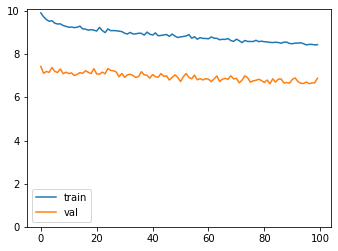

In [10]:
plot.keras_hist(hist.history)

In [31]:
custom_objects = {
    'matthews_correlation_coefficient': mcc,
}

model_recompiled = load_model(FILE_MODEL, custom_objects=custom_objects)
model_recompiled.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy')
model_recompiled.save(FILE_MODEL)

In [32]:
custom_objects = {
    'matthews_correlation_coefficient': mcc,
}

model_1 = load_model('C:/Users/arnal/Downloads/model.h5', custom_objects=custom_objects)
model_2 = load_model(FILE_MODEL)

y_pred_1 = model_1.predict(x_val)
y_pred_2 = model_2.predict(x_val)

assert(np.allclose(y_pred_1, y_pred_2))

In [38]:
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']

im = load.images_from_list_files(list_files, output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

merged_model = load_model(FILE_MODEL)
y_pred = merged_model.predict(im)
for pred in y_pred:
    print(pred)

1 of 1
[[0.9999198]]
[[0.45521107]]
[[0.4571296]]
[[0.9701526]]
[[0.9519345]]
[[1.]]
[[0.7164053]]
[[0.77786565]]
[[0.40396678]]
[[0.45683917]]
[[0.8684589]]
[[0.96776086]]
[[0.3439451]]
[[0.998147]]
[[0.97958916]]
[[0.8744572]]
[[0.13116488]]
[[1.]]
[[0.7216161]]
[[0.999992]]
[[0.9995807]]
[[0.5354815]]
[[1.]]
